In [1]:
%config IPCompleter.use_jedi = False
# %xmode Verbose
# %xmode context
%pdb off
%load_ext viztracer
from viztracer import VizTracer
%load_ext autoreload
%autoreload 3
import sys
from typing import Dict, List, Tuple, Optional
from pathlib import Path

# required to enable non-blocking interaction:
%gui qt5

from copy import deepcopy
from numba import jit
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
# pd.options.mode.dtype_backend = 'pyarrow' # use new pyarrow backend instead of numpy
from attrs import define, field, fields, Factory
import tables as tb
from datetime import datetime, timedelta

# Pho's Formatting Preferences
from pyphocorehelpers.preferences_helpers import set_pho_preferences, set_pho_preferences_concise, set_pho_preferences_verbose
set_pho_preferences_concise()
# Jupyter-lab enable printing for any line on its own (instead of just the last one in the cell)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from pyphocorehelpers.print_helpers import get_now_time_str, get_now_day_str

## Pho's Custom Libraries:
from pyphocorehelpers.Filesystem.path_helpers import find_first_extant_path
from pyphocorehelpers.Filesystem.open_in_system_file_manager import reveal_in_system_file_manager

# NeuroPy (Diba Lab Python Repo) Loading
# from neuropy import core
from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.core.epoch import NamedTimerange, Epoch
from neuropy.core.ratemap import Ratemap
from neuropy.core.session.Formats.BaseDataSessionFormats import DataSessionFormatRegistryHolder
from neuropy.core.session.Formats.Specific.KDibaOldDataSessionFormat import KDibaOldDataSessionFormatRegisteredClass
from neuropy.utils.matplotlib_helpers import matplotlib_file_only, matplotlib_configuration, matplotlib_configuration_update
from neuropy.core.neuron_identities import NeuronIdentityTable, neuronTypesList, neuronTypesEnum
from neuropy.utils.mixins.AttrsClassHelpers import AttrsBasedClassHelperMixin, serialized_field, serialized_attribute_field, non_serialized_field, custom_define
from neuropy.utils.mixins.HDF5_representable import HDF_DeserializationMixin, post_deserialize, HDF_SerializationMixin, HDFMixin, HDF_Converter

## For computation parameters:
from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.utils.dynamic_container import DynamicContainer
from neuropy.utils.result_context import IdentifyingContext
from neuropy.core.session.Formats.BaseDataSessionFormats import find_local_session_paths
from neuropy.core.neurons import NeuronType
from neuropy.core.user_annotations import UserAnnotationsManager
from neuropy.core.position import Position
from neuropy.core.session.dataSession import DataSession
from neuropy.analyses.time_dependent_placefields import PfND_TimeDependent, PlacefieldSnapshot
from neuropy.utils.debug_helpers import debug_print_placefield, debug_print_subsession_neuron_differences, debug_print_ratemap, debug_print_spike_counts, debug_plot_2d_binning, print_aligned_columns
from neuropy.utils.debug_helpers import parameter_sweeps, _plot_parameter_sweep, compare_placefields_info
from neuropy.utils.indexing_helpers import NumpyHelpers, union_of_arrays, intersection_of_arrays, find_desired_sort_indicies, paired_incremental_sorting
from pyphocorehelpers.print_helpers import print_object_memory_usage, print_dataframe_memory_usage, print_value_overview_only, DocumentationFilePrinter, print_keys_if_possible, generate_html_string, CapturedException, document_active_variables

## Pho Programming Helpers:
import inspect
from pyphocorehelpers.general_helpers import inspect_callable_arguments, get_arguments_as_optional_dict, GeneratedClassDefinitionType, CodeConversion
from pyphocorehelpers.print_helpers import DocumentationFilePrinter, TypePrintMode, print_keys_if_possible, debug_dump_object_member_shapes, print_value_overview_only, document_active_variables, CapturedException
from pyphocorehelpers.programming_helpers import IPythonHelpers, PythonDictionaryDefinitionFormat, MemoryManagement
from pyphocorehelpers.gui.Qt.TopLevelWindowHelper import TopLevelWindowHelper, print_widget_hierarchy

# pyPhoPlaceCellAnalysis:
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import NeuropyPipeline # get_neuron_identities
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import export_pyqtgraph_plot
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_load_session, batch_extended_computations, batch_extended_programmatic_figures
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import PipelineSavingScheme

import pyphoplacecellanalysis.External.pyqtgraph as pg

from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_perform_all_plots
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import JonathanFiringRateAnalysisResult
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import _find_any_context_neurons
from pyphoplacecellanalysis.General.Batch.runBatch import BatchSessionCompletionHandler # for `post_compute_validate(...)`
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import BasePositionDecoder
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsResults
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.SpikeAnalysis import SpikeRateTrends # for `_perform_long_short_instantaneous_spike_rate_groups_analysis`
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import SingleBarResult, InstantaneousSpikeRateGroupsComputation, TruncationCheckingResults # for `BatchSessionCompletionHandler`, `AcrossSessionsAggregator`
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import SplitPartitionMembership
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalPlacefieldGlobalComputationFunctions, DirectionalLapsResult, TrackTemplates
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderGlobalComputationFunctions
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrackTemplates
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderComputationsContainer, RankOrderResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderAnalyses


# Plotting
# import pylustrator # customization of figures
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
_bak_rcParams = mpl.rcParams.copy()

matplotlib.use('Qt5Agg')
# %matplotlib inline
# %matplotlib auto

# _restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')


# import pylustrator # call `pylustrator.start()` before creating your first figure in code.
from pyphoplacecellanalysis.Pho2D.matplotlib.visualize_heatmap import visualize_heatmap
from pyphoplacecellanalysis.Pho2D.matplotlib.visualize_heatmap import visualize_heatmap_pyqtgraph # used in `plot_kourosh_activity_style_figure`
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.SpikeRasters import plot_multiple_raster_plot, plot_raster_plot
from pyphoplacecellanalysis.General.Mixins.DataSeriesColorHelpers import UnitColoringMode, DataSeriesColorHelpers
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.SpikeRasters import _build_default_tick, build_scatter_plot_kwargs
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.Render2DScrollWindowPlot import Render2DScrollWindowPlotMixin, ScatterItemData
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_extended_programmatic_figures, batch_programmatic_figures
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.SpikeAnalysis import SpikeRateTrends
from pyphoplacecellanalysis.General.Mixins.SpikesRenderingBaseMixin import SpikeEmphasisState

from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import PAPER_FIGURE_figure_1_add_replay_epoch_rasters, PAPER_FIGURE_figure_1_full, PAPER_FIGURE_figure_3, main_complete_figure_generations
from pyphoplacecellanalysis.SpecificResults.fourthYearPresentation import *

# Jupyter Widget Interactive
import ipywidgets as widgets
from IPython.display import display, HTML
from pyphocorehelpers.Filesystem.open_in_system_file_manager import reveal_in_system_file_manager
from pyphoplacecellanalysis.GUI.IPyWidgets.pipeline_ipywidgets import interactive_pipeline_widget, interactive_pipeline_files
from pyphocorehelpers.gui.Jupyter.simple_widgets import fullwidth_path_widget, render_colors

from datetime import datetime, date, timedelta
from pyphocorehelpers.print_helpers import get_now_day_str, get_now_rounded_time_str

DAY_DATE_STR: str = date.today().strftime("%Y-%m-%d")
DAY_DATE_TO_USE = f'{DAY_DATE_STR}' # used for filenames throught the notebook
print(f'DAY_DATE_STR: {DAY_DATE_STR}, DAY_DATE_TO_USE: {DAY_DATE_TO_USE}')

NOW_DATETIME: str = get_now_rounded_time_str()
NOW_DATETIME_TO_USE = f'{NOW_DATETIME}' # used for filenames throught the notebook
print(f'NOW_DATETIME: {NOW_DATETIME}, NOW_DATETIME_TO_USE: {NOW_DATETIME_TO_USE}')


from pyphocorehelpers.gui.Jupyter.simple_widgets import build_global_data_root_parent_path_selection_widget

all_paths = [Path(r'/home/halechr/FastData'), Path(r'/media/MAX/Data'), Path(r'W:\Data'), Path(r'/home/halechr/cloud/turbo/Data'), Path(r'/Volumes/MoverNew/data'), Path(r'/home/halechr/turbo/Data')]
global_data_root_parent_path = None
def on_user_update_path_selection(new_path: Path):
	global global_data_root_parent_path
	new_global_data_root_parent_path = new_path.resolve()
	global_data_root_parent_path = new_global_data_root_parent_path
	print(f'global_data_root_parent_path changed to {global_data_root_parent_path}')
	assert global_data_root_parent_path.exists(), f"global_data_root_parent_path: {global_data_root_parent_path} does not exist! Is the right computer's config commented out above?"
			
global_data_root_parent_path_widget = build_global_data_root_parent_path_selection_widget(all_paths, on_user_update_path_selection)
global_data_root_parent_path_widget

Automatic pdb calling has been turned OFF
build_module_logger(module_name="Spike3D.pipeline"):
	 Module logger com.PhoHale.Spike3D.pipeline has file logging enabled and will log to EXTERNAL\TESTING\Logging\debug_com.PhoHale.Spike3D.pipeline.log
DAY_DATE_STR: 2024-01-12, DAY_DATE_TO_USE: 2024-01-12
NOW_DATETIME: 2024-01-12_1210PM, NOW_DATETIME_TO_USE: 2024-01-12_1210PM
global_data_root_parent_path changed to W:\Data


ToggleButtons(description='Data Root:', layout=Layout(width='auto'), options=(WindowsPath('W:/Data'),), style=…

# Load Pipeline

In [2]:
# ==================================================================================================================== #
# Load Data                                                                                                            #
# ==================================================================================================================== #

active_data_mode_name = 'kdiba'
local_session_root_parent_context = IdentifyingContext(format_name=active_data_mode_name) # , animal_name='', configuration_name='one', session_name=a_sess.session_name
local_session_root_parent_path = global_data_root_parent_path.joinpath('KDIBA')

# [*] - indicates bad or session with a problem
# 0, 1, 2, 3, 4, 5, 6, 7, [8], [9], 10, 11, [12], 13, 14, [15], [16], 17, 
# curr_context: IdentifyingContext = good_contexts_list[1] # select the session from all of the good sessions here.
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-08_14-26-15') # DONE. Very good. Many good Pfs, many good replays.
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-09_1-22-43') # DONE, might be the BEST SESSION, good example session with lots of place cells, clean replays, and clear bar graphs.
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-12_15-55-31') # DONE, Good Pfs but no good replays ---- VERY weird effect of the replays, a sharp drop to strongly negative values more than 3/4 through the experiment.

# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-13_14-42-6') # BAD, 2023-07-14, unsure why still.
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-07_16-40-19') # DONE, GREAT, both good Pfs and replays! Interesting see-saw!

# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-08_21-16-25') # DONE, Added replay selections. Very "jumpy" between the starts and ends of the track.
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-09_22-24-40') # 2024-01-10 new RANKORDER APOGEE | DONE, Added replay selections. A TON of putative replays in general, most bad, but some good. LOOKIN GOOD!
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='twolong_LR_pf1Dsession_name='2006-4-12_15-25-59') # BAD, No Epochs
# curr_context = IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-16_18-47-52')
# curr_context = IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-17_12-52-15')
# curr_context = IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-25_13-20-55')
# curr_context = IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-28_12-38-13')
# curr_context = IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-02_17-46-44') # DONE, good. Many good pfs, many good replays. Noticed very strange jumping off the track in the 3D behavior/spikes viewer. Is there something wrong with this session?
# curr_context = IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-02_19-28-0') # DONE, good?, replays selected, few --- "ZeroDivisionError: float division by zero"
# curr_context = IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-03_12-3-25') # DONE, very few replays

# curr_context = IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-09_12-15-3') ### KeyError: 'maze1_odd'
# curr_context = IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-09_22-4-5') ### 

curr_context = IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='fet11-01_12-58-54') # DONE, replays selected, quite a few replays but few are very good.

# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-08_21-16-25')

local_session_parent_path: Path = local_session_root_parent_path.joinpath(curr_context.animal, curr_context.exper_name) # 'gor01', 'one' - probably not needed anymore
basedir: Path = local_session_parent_path.joinpath(curr_context.session_name).resolve()
print(f'basedir: {str(basedir)}')

# Read if possible:
saving_mode = PipelineSavingScheme.SKIP_SAVING
force_reload = False
# 
# # Force write:
# saving_mode = PipelineSavingScheme.TEMP_THEN_OVERWRITE
# saving_mode = PipelineSavingScheme.OVERWRITE_IN_PLACE
# force_reload = True

## TODO: if loading is not possible, we need to change the `saving_mode` so that the new results are properly saved.

# ==================================================================================================================== #
# Load Pipeline                                                                                                        #
# ==================================================================================================================== #
# with VizTracer(output_file=f"viztracer_{get_now_time_str()}-full_session_LOO_decoding_analysis.json", min_duration=200, tracer_entries=3000000, ignore_frozen=True) as tracer:
# epoch_name_includelist = ['maze']
epoch_name_includelist = None
active_computation_functions_name_includelist=['pf_computation',
                                            #    'pfdt_computation',
                                                'firing_rate_trends',
                                                # 'pf_dt_sequential_surprise', 
                                            #    'ratemap_peaks_prominence2d',
                                                'position_decoding', 
                                                # 'position_decoding_two_step', 
                                            #    'long_short_decoding_analyses', 'jonathan_firing_rate_analysis', 'long_short_fr_indicies_analyses', 'short_long_pf_overlap_analyses', 'long_short_post_decoding', 'long_short_rate_remapping',
                                            #     'long_short_inst_spike_rate_groups',
                                            #     'long_short_endcap_analysis',
                                            # 'split_to_directional_laps',
]

curr_active_pipeline: NeuropyPipeline = batch_load_session(global_data_root_parent_path, active_data_mode_name, basedir, epoch_name_includelist=epoch_name_includelist,
                                        computation_functions_name_includelist=active_computation_functions_name_includelist,
                                        saving_mode=saving_mode, force_reload=force_reload,
                                        skip_extended_batch_computations=True, debug_print=False, fail_on_exception=True) # , active_pickle_filename = 'loadedSessPickle_withParameters.pkl'



## Post Compute Validate 2023-05-16:
was_updated = BatchSessionCompletionHandler.post_compute_validate(curr_active_pipeline) ## TODO: need to potentially re-save if was_updated. This will fail because constained versions not ran yet.
if was_updated:
    print(f'was_updated: {was_updated}')
    try:
        curr_active_pipeline.save_pipeline(saving_mode=saving_mode)
    except Exception as e:
        ## TODO: catch/log saving error and indicate that it isn't saved.
        exception_info = sys.exc_info()
        e = CapturedException(e, exception_info)
        print(f'ERROR RE-SAVING PIPELINE after update. error: {e}')


basedir: W:\Data\KDIBA\pin01\one\fet11-01_12-58-54
Loading loaded session pickle file results : W:\Data\KDIBA\pin01\one\fet11-01_12-58-54\loadedSessPickle.pkl... 

INFO:com.PhoHale.Spike3D.pipeline:NeuropyPipeline.__setstate__(state="{'pipeline_name': 'kdiba_pipeline', 'session_data_type': 'kdiba', '_stage': <pyphoplacecellanalysis.General.Pipeline.Stages.Display.DisplayPipelineStage object at 0x00000184F273F250>}")
INFO:com.PhoHale.Spike3D.pipeline:select_filters(...) with: []
INFO:com.PhoHale.Spike3D.pipeline:Performing perform_action_for_all_contexts with action EvaluationActions.EVALUATE_COMPUTATIONS on filtered_session with filter named "maze1_odd"...
INFO:com.PhoHale.Spike3D.pipeline:WARNING: skipping computation because overwrite_extant_results=False and active_computation_results[maze1_odd] already exists and is non-None
INFO:com.PhoHale.Spike3D.pipeline:	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
INFO:com.PhoHale.Spike3D.pipeline:Performing perform_action_for_all_contexts with action EvaluationActions.EVALUATE_COMPUTATIONS on fil

done.
Loading pickled pipeline success: W:\Data\KDIBA\pin01\one\fet11-01_12-58-54\loadedSessPickle.pkl.
properties already present in pickled version. No need to save.
pipeline load success!
using provided computation_functions_name_includelist: ['pf_computation', 'firing_rate_trends', 'position_decoding']
	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
	 TODO: this will prevent recomputation even when the excludelist/includelis

In [3]:
### GLOBAL COMPUTATIONS:
if not force_reload: # not just force_reload, needs to recompute whenever the computation fails.
    try:
        curr_active_pipeline.load_pickled_global_computation_results()
    except Exception as e:
        exception_info = sys.exc_info()
        e = CapturedException(e, exception_info)
        print(f'cannot load global results: {e}')
        raise

curr_active_pipeline.reload_default_computation_functions()

extended_computations_include_includelist=['pf_computation', 'firing_rate_trends', # 'pfdt_computation',
    # 'pf_dt_sequential_surprise',
    #  'ratemap_peaks_prominence2d',
    # 'long_short_decoding_analyses', 'jonathan_firing_rate_analysis', 'long_short_fr_indicies_analyses', 'short_long_pf_overlap_analyses', 'long_short_post_decoding',
    # 'long_short_rate_remapping',
    # 'long_short_inst_spike_rate_groups',
    # 'long_short_endcap_analysis',
    # 'spike_burst_detection',
    'split_to_directional_laps',
    'merged_directional_placefields',
    'rank_order_shuffle_analysis'
] # do only specified

force_recompute_override_computations_includelist = None
# force_recompute_override_computations_includelist = ['merged_directional_placefields']
# force_recompute_override_computations_includelist = ['merged_directional_placefields', 'rank_order_shuffle_analysis']

force_recompute_global = force_reload
# force_recompute_global = True
newly_computed_values = batch_extended_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=True, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
if (len(newly_computed_values) > 0):
    print(f'newly_computed_values: {newly_computed_values}.')
    if (saving_mode.value != 'skip_saving'):
        print(f'Saving global results...')
        try:
            # curr_active_pipeline.global_computation_results.persist_time = datetime.now()
            # Try to write out the global computation function results:
            curr_active_pipeline.save_global_computation_results()
        except Exception as e:
            exception_info = sys.exc_info()
            e = CapturedException(e, exception_info)
            print(f'\n\n!!WARNING!!: saving the global results threw the exception: {e}')
            print(f'\tthe global results are currently unsaved! proceed with caution and save as soon as you can!\n\n\n')
    else:
        print(f'\n\n!!WARNING!!: changes to global results have been made but they will not be saved since saving_mode.value == "skip_saving"')
        print(f'\tthe global results are currently unsaved! proceed with caution and save as soon as you can!\n\n\n')
else:
    print(f'no changes in global results.')

# except Exception as e:
#     exception_info = sys.exc_info()
#     e = CapturedException(e, exception_info)
#     print(f'second half threw: {e}')

# 4m 5.2s for inst fr computations


Loading loaded session pickle file results : W:\Data\KDIBA\pin01\one\fet11-01_12-58-54\output\global_computation_results.pkl... done.


(['DirectionalLaps',
  'RankOrder',
  'long_short_leave_one_out_decoding_analysis',
  'short_long_pf_overlap_analyses',
  'long_short_fr_indicies_analysis',
  'jonathan_firing_rate_analysis',
  'long_short_post_decoding',
  'DirectionalMergedDecoders'],
 ['DirectionalLaps',
  'RankOrder',
  'long_short_leave_one_out_decoding_analysis',
  'short_long_pf_overlap_analyses',
  'long_short_fr_indicies_analysis',
  'jonathan_firing_rate_analysis',
  'long_short_post_decoding',
  'DirectionalMergedDecoders'])

included includelist is specified: ['pf_computation', 'firing_rate_trends', 'split_to_directional_laps', 'merged_directional_placefields', 'rank_order_shuffle_analysis'], so only performing these extended computations.
Running batch_extended_computations(...) with global_epoch_name: "maze_any"
pf_computation, maze_any already computed.
firing_rate_trends, maze_any already computed.
split_to_directional_laps, maze_any already computed.
merged_directional_placefields, maze_any already computed.
rank_order_shuffle_analysis, maze_any already computed.
done with all batch_extended_computations(...).
no changes in global results.


In [ ]:
curr_active_pipeline.save_global_computation_results()

In [ ]:
# Determine most recent computation times:
curr_active_pipeline.get_computation_times(debug_print=False)

In [ ]:
curr_active_pipeline.global_computation_results.computation_times

In [ ]:
curr_active_pipeline.reload_default_computation_functions()
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['pfdt_computation'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

# curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['_perform_PBE_stats_analyses'], enabled_filter_names=[global_epoch_name], fail_on_exception=True, debug_print=False)

In [ ]:
curr_active_pipeline.export_pipeline_to_h5()

In [ ]:
curr_active_pipeline.clear_display_outputs()
curr_active_pipeline.clear_registered_output_files()

In [ ]:
# Determine most recent computation times:
out_times = curr_active_pipeline.get_computation_times(debug_print=True)
out_times

In [ ]:
from pyphocorehelpers.Filesystem.metadata_helpers import FilesystemMetadata

# Stores no global times
global_pickle_path = curr_active_pipeline.global_computation_results_pickle_path.resolve()
assert global_pickle_path.exists()
global_pickle_path

file_metadata = FilesystemMetadata.get_file_metadata(global_pickle_path)
file_metadata['modification_time']

collected_global_computations_pickle_paths: List[Path] = []

FilesystemMetadata.get_files_metadata(collected_global_computations_pickle_paths)

In [ ]:

## Global computations:

# global_computation_completion_times = {k.__name__:v for k,v in self.global_computation_results.computation_times.items()}
# global_computations_latest_computation_time: datetime = max(list(global_computation_completion_times.values()), default=datetime.min)

# ## Any (global or non-global) computation most recent time):
# any_most_recent_computation_time: datetime = max(non_global_any_most_recent_computation_time, global_computations_latest_computation_time, datetime.min) # returns `datetime.min` if the first arguments are empty


In [ ]:
curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.TEMP_THEN_OVERWRITE)

# Pho Interactive Pipeline Jupyter Widget

In [4]:
import ipywidgets as widgets
from IPython.display import display
from pyphocorehelpers.Filesystem.open_in_system_file_manager import reveal_in_system_file_manager
from pyphoplacecellanalysis.GUI.IPyWidgets.pipeline_ipywidgets import interactive_pipeline_widget, interactive_pipeline_files

_pipeline_jupyter_widget = interactive_pipeline_widget(curr_active_pipeline=curr_active_pipeline)
# display(_pipeline_jupyter_widget)
_pipeline_jupyter_widget

# End Run

In [5]:
# (long_one_step_decoder_1D, short_one_step_decoder_1D), (long_one_step_decoder_2D, short_one_step_decoder_2D) = compute_short_long_constrained_decoders(curr_active_pipeline, recalculate_anyway=True)
long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
long_epoch_context, short_epoch_context, global_epoch_context = [curr_active_pipeline.filtered_contexts[a_name] for a_name in (long_epoch_name, short_epoch_name, global_epoch_name)]
long_epoch_obj, short_epoch_obj = [Epoch(curr_active_pipeline.sess.epochs.to_dataframe().epochs.label_slice(an_epoch_name.removesuffix('_any'))) for an_epoch_name in [long_epoch_name, short_epoch_name]] #TODO 2023-11-10 20:41: - [ ] Issue with getting actual Epochs from sess.epochs for directional laps: emerges because long_epoch_name: 'maze1_any' and the actual epoch label in curr_active_pipeline.sess.epochs is 'maze1' without the '_any' part.
long_session, short_session, global_session = [curr_active_pipeline.filtered_sessions[an_epoch_name] for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
long_results, short_results, global_results = [curr_active_pipeline.computation_results[an_epoch_name].computed_data for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
long_computation_config, short_computation_config, global_computation_config = [curr_active_pipeline.computation_results[an_epoch_name].computation_config for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
long_pf1D, short_pf1D, global_pf1D = long_results.pf1D, short_results.pf1D, global_results.pf1D
long_pf2D, short_pf2D, global_pf2D = long_results.pf2D, short_results.pf2D, global_results.pf2D

assert short_epoch_obj.n_epochs > 0, f'long_epoch_obj: {long_epoch_obj}, short_epoch_obj: {short_epoch_obj}'
assert long_epoch_obj.n_epochs > 0, f'long_epoch_obj: {long_epoch_obj}, short_epoch_obj: {short_epoch_obj}'

In [ ]:
## long_short_decoding_analyses:
curr_long_short_decoding_analyses = curr_active_pipeline.global_computation_results.computed_data['long_short_leave_one_out_decoding_analysis']
long_one_step_decoder_1D, short_one_step_decoder_1D, long_replays, short_replays, global_replays, long_shared_aclus_only_decoder, short_shared_aclus_only_decoder, shared_aclus, long_short_pf_neurons_diff, n_neurons, long_results_obj, short_results_obj, is_global = curr_long_short_decoding_analyses.long_decoder, curr_long_short_decoding_analyses.short_decoder, curr_long_short_decoding_analyses.long_replays, curr_long_short_decoding_analyses.short_replays, curr_long_short_decoding_analyses.global_replays, curr_long_short_decoding_analyses.long_shared_aclus_only_decoder, curr_long_short_decoding_analyses.short_shared_aclus_only_decoder, curr_long_short_decoding_analyses.shared_aclus, curr_long_short_decoding_analyses.long_short_pf_neurons_diff, curr_long_short_decoding_analyses.n_neurons, curr_long_short_decoding_analyses.long_results_obj, curr_long_short_decoding_analyses.short_results_obj, curr_long_short_decoding_analyses.is_global 
decoding_time_bin_size = long_one_step_decoder_1D.time_bin_size # 1.0/30.0 # 0.03333333333333333

## Get global `long_short_fr_indicies_analysis`:
long_short_fr_indicies_analysis_results = curr_active_pipeline.global_computation_results.computed_data['long_short_fr_indicies_analysis']
long_laps, long_replays, short_laps, short_replays, global_laps, global_replays = [long_short_fr_indicies_analysis_results[k] for k in ['long_laps', 'long_replays', 'short_laps', 'short_replays', 'global_laps', 'global_replays']]
long_short_fr_indicies_df = long_short_fr_indicies_analysis_results['long_short_fr_indicies_df']

## Get global 'long_short_post_decoding' results:
curr_long_short_post_decoding = curr_active_pipeline.global_computation_results.computed_data['long_short_post_decoding']
expected_v_observed_result, curr_long_short_rr = curr_long_short_post_decoding.expected_v_observed_result, curr_long_short_post_decoding.rate_remapping
rate_remapping_df, high_remapping_cells_only = curr_long_short_rr.rr_df, curr_long_short_rr.high_only_rr_df
Flat_epoch_time_bins_mean, Flat_decoder_time_bin_centers, num_neurons, num_timebins_in_epoch, num_total_flat_timebins, is_short_track_epoch, is_long_track_epoch, short_short_diff, long_long_diff = expected_v_observed_result.Flat_epoch_time_bins_mean, expected_v_observed_result.Flat_decoder_time_bin_centers, expected_v_observed_result.num_neurons, expected_v_observed_result.num_timebins_in_epoch, expected_v_observed_result.num_total_flat_timebins, expected_v_observed_result.is_short_track_epoch, expected_v_observed_result.is_long_track_epoch, expected_v_observed_result.short_short_diff, expected_v_observed_result.long_long_diff

jonathan_firing_rate_analysis_result: JonathanFiringRateAnalysisResult = curr_active_pipeline.global_computation_results.computed_data.jonathan_firing_rate_analysis
(epochs_df_L, epochs_df_S), (filter_epoch_spikes_df_L, filter_epoch_spikes_df_S), (good_example_epoch_indicies_L, good_example_epoch_indicies_S), (short_exclusive, long_exclusive, BOTH_subset, EITHER_subset, XOR_subset, NEITHER_subset), new_all_aclus_sort_indicies, assigning_epochs_obj = PAPER_FIGURE_figure_1_add_replay_epoch_rasters(curr_active_pipeline)
neuron_replay_stats_df, short_exclusive, long_exclusive, BOTH_subset, EITHER_subset, XOR_subset, NEITHER_subset = jonathan_firing_rate_analysis_result.get_cell_track_partitions(frs_index_inclusion_magnitude=0.05)

## Update long_exclusive/short_exclusive properties with `long_short_fr_indicies_df`
# long_exclusive.refine_exclusivity_by_inst_frs_index(long_short_fr_indicies_df, frs_index_inclusion_magnitude=0.5)
# short_exclusive.refine_exclusivity_by_inst_frs_index(long_short_fr_indicies_df, frs_index_inclusion_magnitude=0.5)




In [ ]:
expected_v_observed_result.observed_from_expected_diff_ptp_LONG

In [6]:
# Unpack all directional variables:
## {"even": "RL", "odd": "LR"}
long_LR_name, short_LR_name, global_LR_name, long_RL_name, short_RL_name, global_RL_name, long_any_name, short_any_name, global_any_name = ['maze1_odd', 'maze2_odd', 'maze_odd', 'maze1_even', 'maze2_even', 'maze_even', 'maze1_any', 'maze2_any', 'maze_any']

# Most popular
# long_LR_name, short_LR_name, long_RL_name, short_RL_name, global_any_name

# Unpacking for `(long_LR_name, long_RL_name, short_LR_name, short_RL_name)`
(long_LR_context, long_RL_context, short_LR_context, short_RL_context) = [curr_active_pipeline.filtered_contexts[a_name] for a_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
long_LR_epochs_obj, long_RL_epochs_obj, short_LR_epochs_obj, short_RL_epochs_obj, global_any_laps_epochs_obj = [curr_active_pipeline.computation_results[an_epoch_name].computation_config.pf_params.computation_epochs for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name, global_any_name)] # note has global also
(long_LR_session, long_RL_session, short_LR_session, short_RL_session) = [curr_active_pipeline.filtered_sessions[an_epoch_name] for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)] # sessions are correct at least, seems like just the computation parameters are messed up
(long_LR_results, long_RL_results, short_LR_results, short_RL_results) = [curr_active_pipeline.computation_results[an_epoch_name].computed_data for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
(long_LR_computation_config, long_RL_computation_config, short_LR_computation_config, short_RL_computation_config) = [curr_active_pipeline.computation_results[an_epoch_name].computation_config for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
(long_LR_pf1D, long_RL_pf1D, short_LR_pf1D, short_RL_pf1D) = (long_LR_results.pf1D, long_RL_results.pf1D, short_LR_results.pf1D, short_RL_results.pf1D)
(long_LR_pf2D, long_RL_pf2D, short_LR_pf2D, short_RL_pf2D) = (long_LR_results.pf2D, long_RL_results.pf2D, short_LR_results.pf2D, short_RL_results.pf2D)
(long_LR_pf1D_Decoder, long_RL_pf1D_Decoder, short_LR_pf1D_Decoder, short_RL_pf1D_Decoder) = (long_LR_results.pf1D_Decoder, long_RL_results.pf1D_Decoder, short_LR_results.pf1D_Decoder, short_RL_results.pf1D_Decoder)


In [7]:
directional_laps_results = curr_active_pipeline.global_computation_results.computed_data['DirectionalLaps']
directional_merged_decoders_result = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders']   
rank_order_results: RankOrderComputationsContainer = curr_active_pipeline.global_computation_results.computed_data['RankOrder']
minimum_inclusion_fr_Hz: float = rank_order_results.minimum_inclusion_fr_Hz
included_qclu_values: float = rank_order_results.included_qclu_values
print(f'minimum_inclusion_fr_Hz: {minimum_inclusion_fr_Hz}')
print(f'included_qclu_values: {included_qclu_values}')

minimum_inclusion_fr_Hz: 5.0
included_qclu_values: [1, 2]


In [ ]:
directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result.to_hdf(Path('output/all_directional_laps_filter_epochs_decoder_result.hdf').resolve(), 'all_directional_laps_filter_epochs_decoder_result', enable_hdf_testing_mode=True, debug_print=True)



In [ ]:
directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result.filter_epochs.to_hdf('output/all_directional_laps_filter_epochs_decoder_result-filter_epochs.hdf', 'filter_epochs')

In [ ]:
directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result.filter_epochs.to_dataframe()

In [ ]:
# Export the decoded epochs to a file so they can be compared across sessions?



In [ ]:

# # SerializedAttributesAllowBlockSpecifyingClass
# hasattr(a_field_attr.type, 'to_hdf')


from typing import Callable, Type

@define(slots=False, repr=False)
class HDFSerializationRegister:
	""" 2024-01-10 - A dramatically simplified HDF serialization type handler that avoids all of the hard crap and just allows users to register conversion functions directly for items of different types
	
	a_register = HDFSerializationRegister()

	a_register.converion_registery[pd.DataFrame] = lambda x, *hdf_args, **hdf_kwargs: x.to_hdf(*hdf_args, **hdf_kwargs)
	a_register.converion_registery[Epoch] = lambda x, *hdf_args, **hdf_kwargs: x.to_dataframe().to_hdf(*hdf_args, **hdf_kwargs)


	# works!
	a_register.to_hdf(directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result.filter_epochs, 'output/all_directional_laps_filter_epochs_decoder_result-filter_epochs.hdf', 'filter_epochs')


	"""
	converion_registery: Dict[Type, Callable] = field(default=Factory(dict))

	def to_hdf(self, v, *hdf_args, **hdf_kwargs):
		found_conversion_fn = self.converion_registery.get(type(v), None)
		if found_conversion_fn is None:
			print(f'could not find conversion function for v of type {type(v)} in registery.')
			return None
		
		return found_conversion_fn(v, *hdf_args, **hdf_kwargs) # call the function with v
		# return found_conversion_fn
	

a_register = HDFSerializationRegister()

a_register.converion_registery[pd.DataFrame] = lambda x, *hdf_args, **hdf_kwargs: x.to_hdf(*hdf_args, **hdf_kwargs)
a_register.converion_registery[Epoch] = lambda x, *hdf_args, **hdf_kwargs: x.to_dataframe().to_hdf(*hdf_args, **hdf_kwargs)


# works!
a_register.to_hdf(directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result.filter_epochs, 'output/all_directional_laps_filter_epochs_decoder_result-filter_epochs.hdf', 'filter_epochs')


In [ ]:


# print_keys_if_possible('DirectionalMergedDecoders', directional_merged_decoders_result)

from ansi2html import Ansi2HTMLConverter # used by DocumentationFilePrinter to build html document from ansi-color coded version
from pyphocorehelpers.print_helpers import DocumentationFilePrinter

doc_printer = DocumentationFilePrinter(doc_output_parent_folder=Path('EXTERNAL/DEVELOPER_NOTES/DataStructureDocumentation'), doc_name='DirectionalMergedDecodersResult')
doc_printer.save_documentation('DirectionalMergedDecodersResult', directional_merged_decoders_result, non_expanded_item_keys=['_reverse_cellID_index_map'], additional_excluded_item_classes='neuropy.analyses.PfND', max_depth=2)


In [8]:
# NEW 2023-11-22 method: Get the templates (which can be filtered by frate first) and the from those get the decoders):        
# track_templates: TrackTemplates = directional_laps_results.get_shared_aclus_only_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz) # shared-only
track_templates: TrackTemplates = directional_laps_results.get_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz) # non-shared-only
long_LR_decoder, long_RL_decoder, short_LR_decoder, short_RL_decoder = track_templates.get_decoders()

# Unpack all directional variables:
## {"even": "RL", "odd": "LR"}
long_LR_name, short_LR_name, global_LR_name, long_RL_name, short_RL_name, global_RL_name, long_any_name, short_any_name, global_any_name = ['maze1_odd', 'maze2_odd', 'maze_odd', 'maze1_even', 'maze2_even', 'maze_even', 'maze1_any', 'maze2_any', 'maze_any']
# Unpacking for `(long_LR_name, long_RL_name, short_LR_name, short_RL_name)`
(long_LR_context, long_RL_context, short_LR_context, short_RL_context) = [curr_active_pipeline.filtered_contexts[a_name] for a_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
long_LR_epochs_obj, long_RL_epochs_obj, short_LR_epochs_obj, short_RL_epochs_obj, global_any_laps_epochs_obj = [curr_active_pipeline.computation_results[an_epoch_name].computation_config.pf_params.computation_epochs for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name, global_any_name)] # note has global also
(long_LR_session, long_RL_session, short_LR_session, short_RL_session) = [curr_active_pipeline.filtered_sessions[an_epoch_name] for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)] # sessions are correct at least, seems like just the computation parameters are messed up
(long_LR_results, long_RL_results, short_LR_results, short_RL_results) = [curr_active_pipeline.computation_results[an_epoch_name].computed_data for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
(long_LR_computation_config, long_RL_computation_config, short_LR_computation_config, short_RL_computation_config) = [curr_active_pipeline.computation_results[an_epoch_name].computation_config for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
(long_LR_pf1D, long_RL_pf1D, short_LR_pf1D, short_RL_pf1D) = (long_LR_results.pf1D, long_RL_results.pf1D, short_LR_results.pf1D, short_RL_results.pf1D)
(long_LR_pf2D, long_RL_pf2D, short_LR_pf2D, short_RL_pf2D) = (long_LR_results.pf2D, long_RL_results.pf2D, short_LR_results.pf2D, short_RL_results.pf2D)
(long_LR_pf1D_Decoder, long_RL_pf1D_Decoder, short_LR_pf1D_Decoder, short_RL_pf1D_Decoder) = (long_LR_results.pf1D_Decoder, long_RL_results.pf1D_Decoder, short_LR_results.pf1D_Decoder, short_RL_results.pf1D_Decoder)

# `LongShortStatsItem` form (2024-01-02):
# LR_results_real_values = np.array([(a_result_item.long_stats_z_scorer.real_value, a_result_item.short_stats_z_scorer.real_value) for epoch_id, a_result_item in rank_order_results.LR_ripple.ranked_aclus_stats_dict.items()])
# RL_results_real_values = np.array([(a_result_item.long_stats_z_scorer.real_value, a_result_item.short_stats_z_scorer.real_value) for epoch_id, a_result_item in rank_order_results.RL_ripple.ranked_aclus_stats_dict.items()])
LR_results_long_short_z_diffs = np.array([a_result_item.long_short_z_diff for epoch_id, a_result_item in rank_order_results.LR_ripple.ranked_aclus_stats_dict.items()])
RL_results_long_short_z_diff = np.array([a_result_item.long_short_z_diff for epoch_id, a_result_item in rank_order_results.RL_ripple.ranked_aclus_stats_dict.items()])


In [ ]:
active_burst_intervals = curr_active_pipeline.computation_results[global_epoch_name].computed_data['burst_detection']['burst_intervals']
# active_burst_intervals

In [ ]:
# Relative Entropy/Surprise Results:
active_extended_stats = global_results['extended_stats']
active_relative_entropy_results = active_extended_stats['pf_dt_sequential_surprise'] # DynamicParameters
historical_snapshots = active_relative_entropy_results['historical_snapshots']
post_update_times: np.ndarray = active_relative_entropy_results['post_update_times'] # (4152,) = (n_post_update_times,)
snapshot_differences_result_dict = active_relative_entropy_results['snapshot_differences_result_dict']
time_intervals: np.ndarray = active_relative_entropy_results['time_intervals']
surprise_time_bin_duration = (post_update_times[2]-post_update_times[1])
long_short_rel_entr_curves_frames: np.ndarray = active_relative_entropy_results['long_short_rel_entr_curves_frames'] # (4152, 108, 63) = (n_post_update_times, n_neurons, n_xbins)
short_long_rel_entr_curves_frames: np.ndarray = active_relative_entropy_results['short_long_rel_entr_curves_frames'] # (4152, 108, 63) = (n_post_update_times, n_neurons, n_xbins)
flat_relative_entropy_results: np.ndarray = active_relative_entropy_results['flat_relative_entropy_results'] # (149, 63) - (nSnapshots, nXbins)
flat_jensen_shannon_distance_results: np.ndarray = active_relative_entropy_results['flat_jensen_shannon_distance_results'] # (149, 63) - (nSnapshots, nXbins)
flat_jensen_shannon_distance_across_all_positions: np.ndarray = np.sum(np.abs(flat_jensen_shannon_distance_results), axis=1) # sum across all position bins # (4152,) - (nSnapshots)
flat_surprise_across_all_positions: np.ndarray = np.sum(np.abs(flat_relative_entropy_results), axis=1) # sum across all position bins # (4152,) - (nSnapshots)

## Get the placefield dt matrix:
if 'snapshot_occupancy_weighted_tuning_maps' not in active_relative_entropy_results:
	## Compute it if missing:
	occupancy_weighted_tuning_maps_over_time = np.stack([placefield_snapshot.occupancy_weighted_tuning_maps_matrix for placefield_snapshot in historical_snapshots.values()])
	active_relative_entropy_results['snapshot_occupancy_weighted_tuning_maps'] = occupancy_weighted_tuning_maps_over_time
else:
	occupancy_weighted_tuning_maps_over_time = active_relative_entropy_results['snapshot_occupancy_weighted_tuning_maps'] # (n_post_update_times, n_neurons, n_xbins)


In [ ]:
# Time-dependent
long_pf1D_dt, short_pf1D_dt, global_pf1D_dt = long_results.pf1D_dt, short_results.pf1D_dt, global_results.pf1D_dt
long_pf2D_dt, short_pf2D_dt, global_pf2D_dt = long_results.pf2D_dt, short_results.pf2D_dt, global_results.pf2D_dt
global_pf1D_dt: PfND_TimeDependent = global_results.pf1D_dt
global_pf2D_dt: PfND_TimeDependent = global_results.pf2D_dt

In [ ]:
## long_short_endcap_analysis: checks for cells localized to the endcaps that have their placefields truncated after shortening the track
truncation_checking_result: TruncationCheckingResults = curr_active_pipeline.global_computation_results.computed_data.long_short_endcap
disappearing_endcap_aclus = truncation_checking_result.disappearing_endcap_aclus
# disappearing_endcap_aclus
trivially_remapping_endcap_aclus = truncation_checking_result.minor_remapping_endcap_aclus
# trivially_remapping_endcap_aclus
significant_distant_remapping_endcap_aclus = truncation_checking_result.significant_distant_remapping_endcap_aclus
# significant_distant_remapping_endcap_aclus
appearing_aclus = jonathan_firing_rate_analysis_result.neuron_replay_stats_df[jonathan_firing_rate_analysis_result.neuron_replay_stats_df['track_membership'] == SplitPartitionMembership.RIGHT_ONLY].index
# appearing_aclus

In [ ]:
curr_active_pipeline.prepare_for_display()
curr_active_pipeline.display('_display_1d_placefields', 'maze1_odd') # , 'maze1_odd'


In [ ]:
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import programmatic_render_to_file

programmatic_render_to_file(curr_active_pipeline, curr_display_function_name='_display_1d_placefields', write_vector_format=True, write_png=True, debug_print=True)

In [ ]:
curr_active_pipeline.reload_default_display_functions()
curr_active_pipeline.prepare_for_display()

In [ ]:
_out = curr_active_pipeline.display('_display_1d_placefields', 'maze_any')

In [ ]:
curr_active_pipeline.display('_display_1d_placefields', 'maze_any')

In [ ]:
curr_active_pipeline.display('_display_placemaps_pyqtplot_2D', 'maze2_odd')

In [ ]:
curr_active_pipeline.display('_display_1d_placefields', 'maze2_odd')

In [ ]:
curr_active_pipeline.display('_display_3d_interactive_spike_and_behavior_browser', 'maze1_odd')

In [ ]:

# Adjust layout to make space for the footer
# plt.subplots_adjust(bottom=0.35)

plt.tight_layout(pad=2.0)

In [ ]:
_display_placemaps_pyqtplot_2D

In [ ]:
curr_active_pipeline.registered_display_function_docs_dict

In [ ]:
from mpl_multitab import MplMultiTab, MplMultiTab2D
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import programmatic_display_to_PDF, programmatic_render_to_file
from pyphoplacecellanalysis.PhoPositionalData.plotting.placefield import plot_single_cell_1D_placecell_validation
from pyphoplacecellanalysis.PhoPositionalData.plotting.placefield import plot_1d_placecell_validations


# matplotlib_configuration_update(is_interactive=True)

# curr_active_pipeline.display('_display_grid_bin_bounds_validation')
_out = curr_active_pipeline.display('_display_1d_placefield_validations', 'maze1_odd')
_out.ui.show()

In [ ]:

programmatic_display_to_PDF(curr_active_pipeline, curr_display_function_name='_display_1d_placefield_validations', filter_name='maze1_odd', debug_print=True)

# plt.show()

In [ ]:
placefield_cell_index = 0
active_epoch_placefields1D = deepcopy(long_pf1D)
curr_cell_normalized_tuning_curve = active_epoch_placefields1D.ratemap.normalized_tuning_curves[placefield_cell_index, :].squeeze()
{'xbin_centers': active_epoch_placefields1D.ratemap.xbin_centers, 'curr_cell_normalized_tuning_curve': curr_cell_normalized_tuning_curve}

{'xbin_centers': np.array([31.0565, 34.8495, 38.6426, 42.4356, 46.2286, 50.0216, 53.8147, 57.6077, 61.4007, 65.1937, 68.9867, 72.7798, 76.5728, 80.3658, 84.1588, 87.9519, 91.7449, 95.5379, 99.3309, 103.124, 106.917, 110.71, 114.503, 118.296, 122.089, 125.882, 129.675, 133.468, 137.261, 141.054, 144.847, 148.64, 152.433, 156.226, 160.019, 163.812, 167.605, 171.398, 175.191, 178.984, 182.777, 186.57, 190.363, 194.157, 197.95, 201.743, 205.536, 209.329, 213.122, 216.915, 220.708, 224.501, 228.294, 232.087, 235.88, 239.673, 243.466, 247.259, 251.052, 254.845, 258.638, 262.431]),
 'curr_cell_normalized_tuning_curve': np.array([5.92979e-05, 0.000150933, 0.00036895, 0.000736517, 0.00121915, 0.00173714, 0.0022042, 0.00252859, 0.0026496, 0.0027108, 0.00312627, 0.00423033, 0.00579314, 0.00709557, 0.00766535, 0.00789647, 0.00884807, 0.0115452, 0.0165549, 0.0238423, 0.0323681, 0.039895, 0.0442459, 0.0452642, 0.0449909, 0.0457691, 0.0485138, 0.0525281, 0.0562324, 0.0581433, 0.0575758, 0.0544383, 0.0486438, 0.0404683, 0.0315115, 0.0243731, 0.0207242, 0.0199181, 0.0197507, 0.0183449, 0.0153819, 0.0119837, 0.00951012, 0.00827676, 0.00740415, 0.00596512, 0.00396809, 0.00210018, 0.000875453, 0.000302685, 0.000153468, 0.00027615, 0.000667689, 0.00135676, 0.00224608, 0.00305331, 0.0034339, 0.0031979, 0.0024518, 0.00153458, 0.00079294, 0.000405152])}


In [ ]:
# batch_extended_programmatic_figures


In [ ]:
curr_active_pipeline.display('_display_1d_placefields', 'maze1_odd')

In [ ]:
curr_active_pipeline.display('_display_1d_placefields', 'maze2_even')

In [ ]:

#TODO 2023-11-29 09:18: - [ ] Not good, the self.filtered_contexts are not unique!
list(curr_active_pipeline.filtered_contexts.values())
# [IdentifyingContext<(... 'maze2')>, IdentifyingContext<(... 'maze2')>, IdentifyingContext<(..., 'maze')>, IdentifyingContext<(... 'maze2')>, IdentifyingContext<(... 'maze2')>, IdentifyingContext<(..., 'maze')>, IdentifyingContext<(...ze1_any')>, IdentifyingContext<(... 'maze2')>, IdentifyingContext<(..., 'maze')>]
[(v == curr_active_pipeline.filtered_contexts['maze1_even']) for v in list(curr_active_pipeline.filtered_contexts.values())]
# [True, True, False, True, True, False, False, True, False]
# meaning `curr_active_pipeline.display('_display_1d_placefields', curr_active_pipeline.filtered_contexts['maze1_even'])` doesn't work
curr_active_pipeline.filtered_contexts.index(curr_active_pipeline.filtered_contexts['maze1_even'])

In [ ]:
curr_active_pipeline.display('_display_1d_placefields', 'maze2_odd')


In [ ]:
write_vector_format = False
write_png = True
debug_print = True
from neuropy.plotting.ratemaps import BackgroundRenderingOptions

programmatic_render_to_file(curr_active_pipeline, curr_display_function_name='_display_2d_placefield_result_plot_ratemaps_2D', write_vector_format=write_vector_format, write_png=write_png, debug_print=debug_print, bg_rendering_mode=BackgroundRenderingOptions.EMPTY) #  🟢✅ Now seems to be working and saving to PDF!! Still using matplotlib.use('Qt5Agg') mode and plots still appear.


In [ ]:
_out = curr_active_pipeline.display('_display_2d_placefield_occupancy', 'maze2_any')

In [ ]:
_out = curr_active_pipeline.display('_display_2d_placefield_occupancy', 'maze1_any')
occupancy_ax = _out.axes #.get_aspect()
pf = long_pf2D
# pf.xbin
# pf.ybin
# pf.xbin_centers
# pf.ybin_centers

# aspect_ratio = np.ptp(pf.xbin) / np.ptp(pf.ybin)  # ptp: peak to peak (range)
# aspect_ratio = 0.102803738317757
# print(f'aspect_ratio: {aspect_ratio}')
# occupancy_ax.set_aspect(aspect_ratio, adjustable='box') # If 'box', change the physical dimensions of the Axes. If 'datalim', change the x or y data limits.


## See 
# https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_anchor.html#


occupancy_ax.set_aspect('equal', adjustable=None)


In [ ]:
occupancy_ax.set_aspect('equal', adjustable='datalim')

In [ ]:
occupancy_ax.set_aspect('equal', adjustable='box')

In [ ]:
curr_active_pipeline.reload_default_display_functions()

In [ ]:
programmatic_render_to_file(curr_active_pipeline, curr_display_function_name='_display_2d_placefield_occupancy', write_vector_format=write_vector_format, write_png=write_png, debug_print=debug_print)

# EVEN: "RL", ODD: "LR"
Starts with Even (idx=0)
- EVEN: "RL"
shared_RL_aclus_only_neuron_IDs
`is_even = (an_epoch.lap_dir == 0)`
- ODD: "LR"
shared_LR_aclus_only_neuron_IDs
`is_odd = (an_epoch.lap_dir == 1)`

# 🟢 2023-10-20 - Z-Score Comparisons with Neuron_ID Shuffled templates
1. Take the intersection of the long and short templates to get only the common cells
2. Determine the long and short "tempaltes": this is done by ranking the aclus for each by their placefields' center of mass. `compute_placefield_center_of_masses`
	2a. `long_pf_peak_ranks`, `short_pf_peak_ranks` - there are one of each of these for each shared aclu.
3. Generate the unit_id shuffled (`shuffled_aclus`, `shuffle_IDXs`) ahead of time to use to shuffle the two templates during the epochs.
4. For each replay event, take each shuffled template
	4a. Iterate through each shuffle and obtain the shuffled templates like `long_pf_peak_ranks[epoch_specific_shuffled_indicies]`, `short_pf_peak_ranks[epoch_specific_shuffled_indicies]`
	4b. compute the spearman rank-order of the event and each shuffled template, and accumulate the results in `long_spearmanr_rank_stats_results`, `short_spearmanr_rank_stats_results`

5. After we're done with the shuffle loop, accumulate the results and convert to the right output format.

6. When all epochs are done, loop through the results (the epochs again) and compute the z-scores for each epoch so they can be compared to each other. Keep track of the means and std_dev for comparisons later, and subtract the two sets of z-scores (long/short) to get the delta_Z for each template.

7. TODO: Next figure out what to do with the array of z-scores and delta_Z. We have:
	n_epochs sets of results
		n_shuffles scores of delta_Z



## Convo with Kamran 2023-10-23:
- Use directional templates **
- No need to worry about re-ranking
[X] Plot the long and short separately in addition to the difference, so we show significant reqplay on each as a sanity check
[X] Absolute value difference?
[X] Fisher transform the correlation values (check if there is a difference) because correlation coefficients aren't going to be normally distributed.
	[ ] Then Z-score releative to fisher.

- T-test to compare to mean of zero (if looking at the difference)

In [ ]:
## Concerns:
# 1. Permutation recommended over shuffling for small numbers of ids
# 2.

# 5Hz thresholding of templates


In [9]:
from nptyping import NDArray
from attrs import define, field, Factory, astuple
import scipy.stats
from scipy import ndimage
from neuropy.utils.misc import build_shuffled_ids # used in _SHELL_analyze_leave_one_out_decoding_results
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import pho_stats_paired_t_test

# minimum_inclusion_fr_Hz: float = 2.0
rank_order_results: RankOrderComputationsContainer = curr_active_pipeline.global_computation_results.computed_data['RankOrder']
minimum_inclusion_fr_Hz: float = rank_order_results.minimum_inclusion_fr_Hz

# Recover from the saved global result:
directional_laps_results = curr_active_pipeline.global_computation_results.computed_data['DirectionalLaps']
# NEW 2023-11-22 method: Get the templates (which can be filtered by frate first) and the from those get the decoders):        
# track_templates: TrackTemplates = directional_laps_results.get_shared_aclus_only_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz) # shared-only
track_templates: TrackTemplates = directional_laps_results.get_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz) # non-shared-only
long_LR_decoder, long_RL_decoder, short_LR_decoder, short_RL_decoder = track_templates.get_decoders()

## Pre 2023-11-22 method: building a TrackTemplates object after getting the raw decoders:
# long_LR_one_step_decoder_1D, long_RL_one_step_decoder_1D, short_LR_one_step_decoder_1D, short_RL_one_step_decoder_1D = directional_laps_results.get_decoders()
# long_LR_decoder, long_RL_decoder, short_LR_decoder, short_RL_decoder = directional_laps_results.get_shared_aclus_only_decoders()
# track_templates: TrackTemplates = TrackTemplates.init_from_paired_decoders(LR_decoder_pair=(long_LR_decoder, short_LR_decoder), RL_decoder_pair=(long_RL_decoder, short_RL_decoder))
# # track_templates: TrackTemplates = TrackTemplates.init_from_paired_decoders(LR_decoder_pair=(long_LR_one_step_decoder_1D, short_LR_one_step_decoder_1D), RL_decoder_pair=(long_RL_one_step_decoder_1D, short_RL_one_step_decoder_1D)) # NOTE: now use the un-constrained versions

# Unpack all directional variables:
## {"even": "RL", "odd": "LR"}
long_LR_name, short_LR_name, global_LR_name, long_RL_name, short_RL_name, global_RL_name, long_any_name, short_any_name, global_any_name = ['maze1_odd', 'maze2_odd', 'maze_odd', 'maze1_even', 'maze2_even', 'maze_even', 'maze1_any', 'maze2_any', 'maze_any']
# Unpacking for `(long_LR_name, long_RL_name, short_LR_name, short_RL_name)`
(long_LR_context, long_RL_context, short_LR_context, short_RL_context) = [curr_active_pipeline.filtered_contexts[a_name] for a_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
long_LR_epochs_obj, long_RL_epochs_obj, short_LR_epochs_obj, short_RL_epochs_obj, global_any_laps_epochs_obj = [curr_active_pipeline.computation_results[an_epoch_name].computation_config.pf_params.computation_epochs for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name, global_any_name)] # note has global also
(long_LR_session, long_RL_session, short_LR_session, short_RL_session) = [curr_active_pipeline.filtered_sessions[an_epoch_name] for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)] # sessions are correct at least, seems like just the computation parameters are messed up
(long_LR_results, long_RL_results, short_LR_results, short_RL_results) = [curr_active_pipeline.computation_results[an_epoch_name].computed_data for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
(long_LR_computation_config, long_RL_computation_config, short_LR_computation_config, short_RL_computation_config) = [curr_active_pipeline.computation_results[an_epoch_name].computation_config for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
(long_LR_pf1D, long_RL_pf1D, short_LR_pf1D, short_RL_pf1D) = (long_LR_results.pf1D, long_RL_results.pf1D, short_LR_results.pf1D, short_RL_results.pf1D)
(long_LR_pf2D, long_RL_pf2D, short_LR_pf2D, short_RL_pf2D) = (long_LR_results.pf2D, long_RL_results.pf2D, short_LR_results.pf2D, short_RL_results.pf2D)
(long_LR_pf1D_Decoder, long_RL_pf1D_Decoder, short_LR_pf1D_Decoder, short_RL_pf1D_Decoder) = (long_LR_results.pf1D_Decoder, long_RL_results.pf1D_Decoder, short_LR_results.pf1D_Decoder, short_RL_results.pf1D_Decoder)

# `LongShortStatsItem` form (2024-01-02):
# LR_results_real_values = np.array([(a_result_item.long_stats_z_scorer.real_value, a_result_item.short_stats_z_scorer.real_value) for epoch_id, a_result_item in rank_order_results.LR_ripple.ranked_aclus_stats_dict.items()])
# RL_results_real_values = np.array([(a_result_item.long_stats_z_scorer.real_value, a_result_item.short_stats_z_scorer.real_value) for epoch_id, a_result_item in rank_order_results.RL_ripple.ranked_aclus_stats_dict.items()])
LR_results_long_short_z_diffs = np.array([a_result_item.long_short_z_diff for epoch_id, a_result_item in rank_order_results.LR_ripple.ranked_aclus_stats_dict.items()])
RL_results_long_short_z_diff = np.array([a_result_item.long_short_z_diff for epoch_id, a_result_item in rank_order_results.RL_ripple.ranked_aclus_stats_dict.items()])


In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import plot_rank_order_histograms

# Plot histograms:
post_title_info: str = f'{minimum_inclusion_fr_Hz} Hz\n{curr_active_pipeline.get_session_context().get_description()}'
_out_z_score, _out_real, _out_most_likely_z = plot_rank_order_histograms(rank_order_results, post_title_info=post_title_info)


#TODO 2023-12-10 19:56: - [ ] Histogram Display Helpers

#TODO 2023-12-10 19:56: - [ ] Pf1D Helpers

#TODO 2023-12-10 19:57: - [ ] Variant Saving
 

In [ ]:
track_templates: TrackTemplates = directional_laps_results.get_templates(minimum_inclusion_fr_Hz=0.0) # non-shared-only
long_LR_decoder, long_RL_decoder, short_LR_decoder, short_RL_decoder = track_templates.get_decoders()

# filtered_decoder_list = [filtered_by_frate(a_decoder, minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz, debug_print=True) for a_decoder in (long_LR_one_step_decoder_1D, long_RL_one_step_decoder_1D, short_LR_one_step_decoder_1D, short_RL_one_step_decoder_1D)]
original_neuron_ids_list = [a_decoder.pf.ratemap.neuron_ids for a_decoder in (long_LR_decoder, long_RL_decoder, short_LR_decoder, short_RL_decoder)]
is_aclu_included_list = [a_decoder.pf.ratemap.tuning_curve_unsmoothed_peak_firing_rates >= minimum_inclusion_fr_Hz for a_decoder in (long_LR_decoder, long_RL_decoder, short_LR_decoder, short_RL_decoder)]
filtered_aclus_list = [np.array(a_decoder.pf.ratemap.neuron_ids)[a_decoder.pf.ratemap.tuning_curve_unsmoothed_peak_firing_rates >= minimum_inclusion_fr_Hz] for a_decoder in (long_LR_decoder, long_RL_decoder, short_LR_decoder, short_RL_decoder)]

## For a given run direction (LR/RL) let's require inclusion in either (OR) long v. short to be included.
filtered_included_LR_aclus = np.union1d(filtered_aclus_list[0], filtered_aclus_list[2])
filtered_included_RL_aclus = np.union1d(filtered_aclus_list[1], filtered_aclus_list[3])
# build the final shared aclus:
filtered_direction_shared_aclus_list = [filtered_included_LR_aclus, filtered_included_RL_aclus, filtered_included_LR_aclus, filtered_included_RL_aclus] # contains the shared aclus for that direction
# rebuild the is_aclu_included_list from the shared aclus
is_aclu_included_list = [np.isin(an_original_neuron_ids, a_filtered_neuron_ids) for an_original_neuron_ids, a_filtered_neuron_ids in zip(original_neuron_ids_list, filtered_direction_shared_aclus_list)]

# is_aclu_included_list[0]
filtered_direction_shared_aclus_list

In [ ]:
# # for 5Hz:
# [array([  5,   7,  31,  39,  41,  45,  46,  48,  50,  55,  61,  62,  64,  69,  72,  75,  76,  78,  79,  83,  84,  86,  88,  90,  91,  92,  95,  99, 100, 108]),
#  array([  5,   7,   9,  31,  32,  39,  41,  45,  46,  48,  50,  55,  61,  62,  64,  69,  72,  75,  76,  78,  79,  83,  84,  86,  88,  90,  91,  92,  93,  95,  99, 101, 108]),
#  array([  5,   7,  31,  39,  41,  45,  46,  48,  50,  55,  61,  62,  64,  69,  72,  75,  76,  78,  79,  83,  84,  86,  88,  90,  91,  92,  95,  99, 100, 108]),
#  array([  5,   7,   9,  31,  32,  39,  41,  45,  46,  48,  50,  55,  61,  62,  64,  69,  72,  75,  76,  78,  79,  83,  84,  86,  88,  90,  91,  92,  93,  95,  99, 101, 108])]

# # for 20Hz:
# [array([  5,  41,  46,  48,  69,  78,  79,  83,  86,  88,  90, 108]),
#  array([ 62,  64,  75,  78,  83,  91, 101]),
#  array([  5,  41,  46,  48,  69,  78,  79,  83,  86,  88,  90, 108]),
#  array([ 62,  64,  75,  78,  83,  91, 101])]

# 2023-11-22 - RECOMPUTE

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalLapsHelpers
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderGlobalComputationFunctions

curr_active_pipeline.reload_default_computation_functions()

## clear the old values to prepare for the new ones:
curr_active_pipeline.global_computation_results.computed_data['DirectionalLaps'] = None
curr_active_pipeline.global_computation_results.computed_data['RankOrder'] = None
del curr_active_pipeline.global_computation_results.computed_data['DirectionalLaps']
del curr_active_pipeline.global_computation_results.computed_data['RankOrder']


In [ ]:
curr_active_pipeline.global_computation_results.computed_data['DirectionalLaps'] = DirectionalLapsHelpers.build_global_directional_result_from_natural_epochs(curr_active_pipeline, progress_print=True) # repalce the directional laps object
directional_laps_results: DirectionalLapsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalLaps']

num_shuffles = 500

minimum_inclusion_fr_Hz = 5.0
included_qclu_values = [1,2]

# minimum_inclusion_fr_Hz = 1.0
# included_qclu_values = [1,2,4,9]

# perform_rank_order_shuffle_analysis
with VizTracer(output_file=f"viztracer_{get_now_time_str()}-perform_rank_order_shuffle_analysis_{curr_active_pipeline.session_name}_num_shuffles-{num_shuffles}.json", min_duration=200, tracer_entries=3000000, ignore_frozen=True) as tracer:
    ## DO ALL:
    RankOrderGlobalComputationFunctions.perform_rank_order_shuffle_analysis(curr_active_pipeline, curr_active_pipeline.global_computation_results, None, None, include_includelist=None, debug_print=False,
                                                                            num_shuffles=num_shuffles, minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz, included_qclu_values=included_qclu_values, skip_laps=False)


In [ ]:
## Custom `RankOrderAnalyses.most_likely_directional_rank_order_shuffling(...)`
# Requires "New method 2023-12-15" result
# Set the global result:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderAnalyses

try:
	print(f'\tdone. building global result.')
	curr_active_pipeline.global_computation_results.computed_data['RankOrder'].adding_active_aclus_info()
	curr_active_pipeline.global_computation_results.computed_data['RankOrder'].ripple_most_likely_result_tuple, curr_active_pipeline.global_computation_results.computed_data['RankOrder'].laps_most_likely_result_tuple = RankOrderAnalyses.most_likely_directional_rank_order_shuffling(curr_active_pipeline)

except (AssertionError, BaseException) as e:
	print(f'Issue with `RankOrderAnalyses.most_likely_directional_rank_order_shuffling(...)` e: {e}')
	raise

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderAnalyses

curr_active_pipeline.global_computation_results.computed_data['RankOrder'].ripple_most_likely_result_tuple, curr_active_pipeline.global_computation_results.computed_data['RankOrder'].laps_most_likely_result_tuple = RankOrderAnalyses.most_likely_directional_rank_order_shuffling(curr_active_pipeline)

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalMergedDecodersResult

## Extract the rank_order_results:
rank_order_results: RankOrderComputationsContainer = curr_active_pipeline.global_computation_results.computed_data['RankOrder']
rank_order_results.adding_active_aclus_info()

directional_laps_results = curr_active_pipeline.global_computation_results.computed_data['DirectionalLaps']
track_templates: TrackTemplates = directional_laps_results.get_templates(minimum_inclusion_fr_Hz=rank_order_results.minimum_inclusion_fr_Hz) # non-shared-only
decoders_dict = track_templates.get_decoders_dict() # decoders_dict = {'long_LR': track_templates.long_LR_decoder, 'long_RL': track_templates.long_RL_decoder, 'short_
# LR': track_templates.short_LR_decoder, 'short_RL': track_templates.short_RL_decoder, }

# Get the `directional_merged_decoders_result` to determining most-likely direction from the merged pseudo-2D decoder:
directional_merged_decoders_result = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders']
# directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result
# directional_merged_decoders_result.all_directional_pf1D_Decoder
# directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result

laps_marginals = DirectionalMergedDecodersResult.determine_directional_likelihoods(directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result)
laps_directional_marginals, laps_directional_all_epoch_bins_marginal, laps_most_likely_direction_from_decoder, laps_is_most_likely_direction_LR_dir = laps_marginals

ripple_marginals = DirectionalMergedDecodersResult.determine_directional_likelihoods(directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result)
ripple_directional_marginals, ripple_directional_all_epoch_bins_marginal, ripple_most_likely_direction_from_decoder, ripple_is_most_likely_direction_LR_dir = ripple_marginals


# directional_merged_decoders_result.
# ripple_most_likely_result_tuple

In [ ]:
ripple_directional_all_epoch_bins_marginal

In [ ]:
rank_order_results.ripple_combined_epoch_stats_df

In [ ]:
active_replay_epochs_df # 'Long_normed_LR_evidence', 'Long_normed_RL_evidence', 'Short_normed_LR_evidence', 'Short_normed_RL_evidence'
# active_replay_epochs_df[['Long_normed_LR_evidence', 'Short_normed_RL_evidence']]

In [ ]:
## 2024-01-04 - DirectionalMergedDecoders version:
# NOTE: ripple_most_likely_direction_from_decoder comes with with more epochs than the already filtered `rank_order_results.ripple_combined_epoch_stats_df` version. We'll get only the active indicies from `rank_order_results.ripple_combined_epoch_stats_df.index`
# needs: rank_order_results, ripple_most_likely_direction_from_decoder, ripple_directional_all_epoch_bins_marginal, 
combined_best_direction_indicies = deepcopy(ripple_most_likely_direction_from_decoder) # .shape (611,)
# np.shape(combined_best_direction_indicies)
combined_best_direction_indicies = combined_best_direction_indicies[rank_order_results.ripple_combined_epoch_stats_df['label'].to_numpy()] # get only the indicies for the active epochs
# np.shape(combined_best_direction_indicies)
assert np.shape(combined_best_direction_indicies)[0] == np.shape(rank_order_results.ripple_combined_epoch_stats_df)[0]
long_best_direction_indicies = combined_best_direction_indicies.copy() # use same (globally best) indicies for Long/Short
short_best_direction_indicies = combined_best_direction_indicies.copy() # use same (globally best) indicies for Long/Short

# gets the LR likelihood for each of these (long/short)
long_relative_direction_likelihoods = ripple_directional_all_epoch_bins_marginal[rank_order_results.ripple_combined_epoch_stats_df['label'].to_numpy(), 0] # (n_epochs, 2)
short_relative_direction_likelihoods = ripple_directional_all_epoch_bins_marginal[rank_order_results.ripple_combined_epoch_stats_df['label'].to_numpy(), 0] # (n_epochs, 2)

ripple_directional_likelihoods_tuple: DirectionalRankOrderLikelihoods = DirectionalRankOrderLikelihoods(long_relative_direction_likelihoods=long_relative_direction_likelihoods,
																				short_relative_direction_likelihoods=short_relative_direction_likelihoods,
																				long_best_direction_indices=long_best_direction_indicies, 
																				short_best_direction_indices=short_best_direction_indicies,
																				)


In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderAnalyses

## Main
ripple_result_tuple, laps_result_tuple = RankOrderAnalyses.most_likely_directional_rank_order_shuffling(curr_active_pipeline, decoding_time_bin_size=0.003)

In [ ]:
## 2024-01-04 - DirectionalMergedDecoders version:
# NOTE: laps_most_likely_direction_from_decoder comes with with more epochs than the already filtered `rank_order_results.laps_combined_epoch_stats_df` version. We'll get only the active indicies from `rank_order_results.ripple_combined_epoch_stats_df.index`
# needs: rank_order_results, laps_most_likely_direction_from_decoder, laps_directional_all_epoch_bins_marginal, 
laps_marginals = DirectionalMergedDecodersResult.determine_directional_likelihoods(directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result)
laps_directional_marginals, laps_directional_all_epoch_bins_marginal, laps_most_likely_direction_from_decoder, laps_is_most_likely_direction_LR_dir = laps_marginals

combined_best_direction_indicies = deepcopy(laps_most_likely_direction_from_decoder) # .shape (611,)
# np.shape(combined_best_direction_indicies)
combined_best_direction_indicies = combined_best_direction_indicies[rank_order_results.laps_combined_epoch_stats_df['label'].to_numpy()] # get only the indicies for the active epochs
# np.shape(combined_best_direction_indicies)
assert np.shape(combined_best_direction_indicies)[0] == np.shape(rank_order_results.laps_combined_epoch_stats_df)[0]
long_best_direction_indicies = combined_best_direction_indicies.copy() # use same (globally best) indicies for Long/Short
short_best_direction_indicies = combined_best_direction_indicies.copy() # use same (globally best) indicies for Long/Short

# gets the LR likelihood for each of these (long/short)
long_relative_direction_likelihoods = laps_directional_all_epoch_bins_marginal[rank_order_results.laps_combined_epoch_stats_df['label'].to_numpy(), 0] # (n_epochs, 2)
short_relative_direction_likelihoods = laps_directional_all_epoch_bins_marginal[rank_order_results.laps_combined_epoch_stats_df['label'].to_numpy(), 0] # (n_epochs, 2)

laps_directional_likelihoods_tuple: DirectionalRankOrderLikelihoods = DirectionalRankOrderLikelihoods(long_relative_direction_likelihoods=long_relative_direction_likelihoods,
																				short_relative_direction_likelihoods=short_relative_direction_likelihoods,
																				long_best_direction_indices=long_best_direction_indicies, 
																				short_best_direction_indices=short_best_direction_indicies,
																				)


In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderAnalyses

RankOrderAnalyses.percentiles_computations(rank_order_results=rank_order_results)
laps_merged_complete_epoch_stats_df: pd.DataFrame = rank_order_results.laps_merged_complete_epoch_stats_df ## New method
ripple_merged_complete_epoch_stats_df: pd.DataFrame = rank_order_results.ripple_merged_complete_epoch_stats_df ## New method

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalLapsHelpers
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderGlobalComputationFunctions

curr_active_pipeline.reload_default_computation_functions()

## DO just Pandas-based method and post-processing for best directions:
RankOrderGlobalComputationFunctions.perform_pandas_based_rank_order_shuffle_analysis(curr_active_pipeline, curr_active_pipeline.global_computation_results, None, None, include_includelist=None, debug_print=True,
                                                                        num_shuffles=1000, minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz, included_qclu_values=included_qclu_values, skip_laps=False)

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderAnalyses

directional_laps_results: DirectionalLapsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalLaps']
selected_spikes_df = deepcopy(curr_active_pipeline.global_computation_results.computed_data['RankOrder'].LR_ripple.selected_spikes_df)
# active_epochs = global_computation_results.computed_data['RankOrder'].ripple_most_likely_result_tuple.active_epochs
active_epochs = deepcopy(curr_active_pipeline.global_computation_results.computed_data['RankOrder'].LR_ripple.epochs_df)
track_templates = directional_laps_results.get_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz)

with VizTracer(output_file=f"viztracer_{get_now_time_str()}-pandas_df_based_correlation_computations.json", min_duration=200, tracer_entries=3000000, ignore_frozen=True) as tracer:
	ripple_combined_epoch_stats_df, ripple_new_output_tuple = RankOrderAnalyses.pandas_df_based_correlation_computations(selected_spikes_df=selected_spikes_df, active_epochs_df=active_epochs, track_templates=track_templates, num_shuffles=100)

ripple_combined_epoch_stats_df

# n_shuffles: [5, 50]
# time: ["10.4s", "1m 15.9s"]

In [ ]:
print(list(ripple_combined_epoch_stats_df.columns)) # ['long_RL_spearman', 'long_LR_pearson', 'short_RL_spearman', 'short_RL_pearson', 'long_LR_spearman', 'short_LR_pearson', 'short_LR_spearman', 'long_RL_pearson', 'long_RL_spearman_Z', 'long_LR_pearson_Z', 'short_RL_spearman_Z', 'short_RL_pearson_Z', 'long_LR_spearman_Z', 'short_LR_pearson_Z', 'short_LR_spearman_Z', 'long_RL_pearson_Z', 'label']

['LR_Long_spearman_Z', 'LR_Long_spearman_Z', 'LR_Long_spearman_Z', 'LR_Long_spearman_Z']

{'long_LR':'LR_Long'}

decoder_name_to_column_name_prefix_map: Dict[str, str] = dict(zip(['long_LR', 'long_RL', 'short_LR', 'short_RL'], ['LR_Long', 'RL_Long', 'LR_Short', 'RL_Short']))

rename_fn = lambda a_name: a_name.replace(

[a_name.replace( for a_name in list(ripple_combined_epoch_stats_df.columns)]


['long_RL_spearman', 'long_LR_pearson', 'short_RL_spearman', 'short_RL_pearson', 'long_LR_spearman', 'short_LR_pearson', 'short_LR_spearman', 'long_RL_pearson', 'long_RL_spearman_Z', 'long_LR_pearson_Z', 'short_RL_spearman_Z', 'short_RL_pearson_Z', 'long_LR_spearman_Z', 'short_LR_pearson_Z', 'short_LR_spearman_Z', 'long_RL_pearson_Z', 'label']



In [ ]:
def build_column_rename_dict(column_names: List[str], decoder_name_to_column_name_prefix_map:Optional[Dict[str,str]]=None) -> Dict[str,str]:
  """ 
  
  column_names = ['long_RL_spearman', 'long_LR_pearson', 'short_RL_spearman', 'short_RL_pearson', 'long_LR_spearman', 'short_LR_pearson', 'short_LR_spearman', 'long_RL_pearson', 'long_RL_spearman_Z', 'long_LR_pearson_Z', 'short_RL_spearman_Z', 'short_RL_pearson_Z', 'long_LR_spearman_Z', 'short_LR_pearson_Z', 'short_LR_spearman_Z', 'long_RL_pearson_Z']
  decoder_name_to_column_name_prefix_map = dict(zip(['long_LR', 'long_RL', 'short_LR', 'short_RL'], ['LR_Long', 'RL_Long', 'LR_Short', 'RL_Short']))

  old_to_new_names = build_column_rename_dict(column_names, decoder_name_to_column_name_prefix_map.copy())
  print(old_to_new_names)

  {'long_RL_spearman': 'RL_Long_spearman', 'long_LR_pearson': 'LR_Long_pearson', 'short_RL_spearman': 'RL_Short_spearman', 'short_RL_pearson': 'RL_Short_pearson', 'long_LR_spearman': 'LR_Long_spearman', 'short_LR_pearson': 'LR_Short_pearson', 'short_LR_spearman': 'LR_Short_spearman', 'long_RL_pearson': 'RL_Long_pearson', 'long_RL_spearman_Z': 'RL_Long_spearman_Z', 'long_LR_pearson_Z': 'LR_Long_pearson_Z', 'short_RL_spearman_Z': 'RL_Short_spearman_Z', 'short_RL_pearson_Z': 'RL_Short_pearson_Z', 'long_LR_spearman_Z': 'LR_Long_spearman_Z', 'short_LR_pearson_Z': 'LR_Short_pearson_Z', 'short_LR_spearman_Z': 'LR_Short_spearman_Z', 'long_RL_pearson_Z': 'RL_Long_pearson_Z'}
  """
  if decoder_name_to_column_name_prefix_map is None:
    decoder_name_to_column_name_prefix_map = dict(zip(['long_LR', 'long_RL', 'short_LR', 'short_RL'], ['LR_Long', 'RL_Long', 'LR_Short', 'RL_Short']))
  
  old_to_new_names = {}
  for col in column_names:
    for decoder_name, prefix in decoder_name_to_column_name_prefix_map.items():
      if decoder_name in col:
        new_col = prefix + col.split(decoder_name)[-1]
        old_to_new_names[col] = new_col
  return old_to_new_names
  
column_names = ['long_RL_spearman', 'long_LR_pearson', 'short_RL_spearman', 'short_RL_pearson', 'long_LR_spearman', 'short_LR_pearson', 'short_LR_spearman', 'long_RL_pearson', 'long_RL_spearman_Z', 'long_LR_pearson_Z', 'short_RL_spearman_Z', 'short_RL_pearson_Z', 'long_LR_spearman_Z', 'short_LR_pearson_Z', 'short_LR_spearman_Z', 'long_RL_pearson_Z']
old_to_new_names = build_column_rename_dict(column_names)
print(old_to_new_names)
ripple_combined_epoch_stats_df = ripple_combined_epoch_stats_df.rename(columns=old_to_new_names, inplace=False)
ripple_combined_epoch_stats_df

In [ ]:
ripple_combined_epoch_stats_df.LR_Long_spearman_Z

In [ ]:
curr_active_pipeline.global_computation_results.computed_data['RankOrder'].ripple_combined_epoch_stats_df, curr_active_pipeline.global_computation_results.computed_data['RankOrder'].ripple_new_output_tuple = ripple_combined_epoch_stats_df, ripple_new_output_tuple

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderAnalyses

decoder_aclu_peak_map_dict = track_templates.get_decoder_aclu_peak_map_dict()
override_decoder_aclu_peak_map_dict = deepcopy(decoder_aclu_peak_map_dict)
active_selected_spikes_df = RankOrderAnalyses._subfn_build_all_pf_peak_x_columns(track_templates, selected_spikes_df=selected_spikes_df, override_decoder_aclu_peak_map_dict=override_decoder_aclu_peak_map_dict)
epoch_id_grouped_selected_spikes_df =  active_selected_spikes_df.groupby('Probe_Epoch_id') # I can even compute this outside the loop?

In [ ]:

active_selected_spikes_df = deepcopy(epoch_id_grouped_selected_spikes_df)
active_selected_spikes_df = RankOrderAnalyses._subfn_build_all_pf_peak_x_columns(track_templates, selected_spikes_df=active_selected_spikes_df, override_decoder_aclu_peak_map_dict=override_decoder_aclu_peak_map_dict)
active_selected_spikes_df

In [ ]:


#TODO 2023-12-18 13:20: - [ ] This assumes that `'Probe_Epoch_id'` is correct and consistent for both directions, yeah?

## Compute real values here:
decoder_names = track_templates.get_decoder_names()

epoch_id_grouped_selected_spikes_df =  active_selected_spikes_df.groupby('Probe_Epoch_id') # I can even compute this outside the loop?
spearman_correlations = epoch_id_grouped_selected_spikes_df.apply(lambda group: RankOrderAnalyses._subfn_calculate_correlations(group, method='spearman', decoder_names=decoder_names)).reset_index() # Reset index to make 'Probe_Epoch_id' a column
pearson_correlations = epoch_id_grouped_selected_spikes_df.apply(lambda group: RankOrderAnalyses._subfn_calculate_correlations(group, method='pearson', decoder_names=decoder_names)).reset_index() # Reset index to make 'Probe_Epoch_id' a column

real_stats_df = pd.concat((spearman_correlations, pearson_correlations), axis='columns')
real_stats_df = real_stats_df.loc[:, ~real_stats_df.columns.duplicated()] # drop duplicated 'Probe_Epoch_id' column
# Change column type to uint64 for column: 'Probe_Epoch_id'
real_stats_df = real_stats_df.astype({'Probe_Epoch_id': 'uint64'})
# Rename column 'Probe_Epoch_id' to 'label'
real_stats_df = real_stats_df.rename(columns={'Probe_Epoch_id': 'label'})
real_stats_df

In [ ]:
rank_order_results: RankOrderComputationsContainer = curr_active_pipeline.global_computation_results.computed_data['RankOrder']
minimum_inclusion_fr_Hz: float = rank_order_results.minimum_inclusion_fr_Hz
included_qclu_values: List[int] = rank_order_results.included_qclu_values
ripple_result_tuple, laps_result_tuple = rank_order_results.ripple_most_likely_result_tuple, rank_order_results.laps_most_likely_result_tuple
directional_laps_results: DirectionalLapsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalLaps']
track_templates: TrackTemplates = directional_laps_results.get_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz) # non-shared-only -- !! Is minimum_inclusion_fr_Hz=None the issue/difference?
print(f'minimum_inclusion_fr_Hz: {minimum_inclusion_fr_Hz}')
print(f'included_qclu_values: {included_qclu_values}')

# 10m 29.5s for 1000 shuffles.  c:\Users\pho\repos\Spike3DWorkEnv\Spike3D\viztracer_2023-11-22_16-11-perform_rank_order_shuffle_analysis.json

# 3m 33.9s - 500
# 3m 26.4s - 1000

In [ ]:
_ripples_outputs = RankOrderAnalyses.main_ripples_analysis(curr_active_pipeline, num_shuffles=500, rank_alignment='median', minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz, included_qclu_values=included_qclu_values)
(LR_ripple_outputs, RL_ripple_outputs, ripple_evts_paired_tests) = _ripples_outputs


In [ ]:
# LR_ripple_outputs.epochs_df
LR_ripple_outputs.spikes_df

In [ ]:
RL_ripple_outputs.spikes_df

In [ ]:
LR_ripple_outputs.selected_spikes_df

In [ ]:
RL_ripple_outputs.



In [ ]:
## Ensure equivalence of the two LR_ripple_outputs and RL_ripple_outputs for the fields that matter:
assert LR_ripple_outputs.spikes_df.equals(RL_ripple_outputs.spikes_df), f"spikes_df are not equal"
assert LR_ripple_outputs.selected_spikes_df.equals(RL_ripple_outputs.selected_spikes_df), f"selected_spikes_df are not equal"
assert LR_ripple_outputs.epochs_df.equals(RL_ripple_outputs.epochs_df), f"epochs_df are not equal"

In [ ]:
_new_rank_order_event_raster_debugger = RankOrderRastersDebugger.init_rank_order_debugger(deepcopy(LR_ripple_outputs.selected_spikes_df), deepcopy(LR_ripple_outputs.epochs_df), track_templates, rank_order_results, None, None)



In [ ]:
# TypeError: <lambda>() missing 1 required positional argument


In [ ]:
## Recompute just the `most_likely_directional_rank_order_shuffling` part:
# from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderComputationsContainer
# from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import DirectionalRankOrderLikelihoods
# from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderAnalyses
## Main
ripple_result_tuple, laps_result_tuple = RankOrderAnalyses.most_likely_directional_rank_order_shuffling(curr_active_pipeline)
ripple_result_tuple

In [ ]:
rank_order_results.ripple_most_likely_result_tuple, rank_order_results.laps_most_likely_result_tuple = ripple_result_tuple, laps_result_tuple

In [ ]:
directional_likelihoods_tuple: DirectionalRankOrderLikelihoods = deepcopy(ripple_result_tuple.directional_likelihoods_tuple)
directional_likelihoods_tuple.long_best_direction_indices
directional_likelihoods_tuple.short_best_direction_indices
# directional_likelihoods_tuple.long_relative_direction_likelihoods





# Saving/Loading `DirectionalLaps_2Hz`

In [ ]:
from datetime import datetime, date, timedelta
from pyphocorehelpers.print_helpers import get_now_day_str, get_now_rounded_time_str
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import save_rank_order_results

# DAY_DATE_STR: str = date.today().strftime("%Y-%m-%d")
# DAY_DATE_TO_USE = f'{DAY_DATE_STR}' # used for filenames throught the notebook
# print(f'DAY_DATE_STR: {DAY_DATE_STR}, DAY_DATE_TO_USE: {DAY_DATE_TO_USE}')

# NOW_DATETIME: str = get_now_rounded_time_str()
# NOW_DATETIME_TO_USE = f'{NOW_DATETIME}' # used for filenames throught the notebook
# print(f'NOW_DATETIME: {NOW_DATETIME}, NOW_DATETIME_TO_USE: {NOW_DATETIME_TO_USE}')

formatted_time = get_now_rounded_time_str()
print(formatted_time)
save_rank_order_results(curr_active_pipeline, day_date=f"{formatted_time}") # "2024-01-02_301pm" "2024-01-02_322pm" 322pm # "2024-01-02_301pm" "2024-01-02_322pm" 322pm
# '2024-01-09_0125PM-minimum_inclusion_fr-5-included_qclu_values-[1, 2]'


In [ ]:

save_rank_order_results(owning_active_pipeline, day_date=f"{formatted_time}_partial")

In [ ]:
search_path = Path('/media/MAX/Data/KDIBA/gor01/one/2006-6-08_14-26-15/output/').resolve()
sorted(search_path.glob(f"{DAY_DATE_TO_USE}*"))


In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import SaveStringGenerator
from pyphoplacecellanalysis.General.Pipeline.Stages.Loading import loadData

# Load the data from a file into the pipeline:
# out_filename_str: str = '2023-12-11-minimum_inclusion_fr_Hz_2_included_qclu_values_1-2_' # specific

minimum_inclusion_fr_Hz: float = 5.0
included_qclu_values: List[int] = [1,2]
out_filename_str = SaveStringGenerator.generate_save_suffix(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz, included_qclu_values=included_qclu_values, day_date=f'{DAY_DATE_TO_USE}_11am') # '2023-12-21_349am'
# out_filename_str = SaveStringGenerator.generate_save_suffix(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz, included_qclu_values=included_qclu_values, day_date='2023-12-22_312pm') # '2023-12-21_349am'
print(f'out_filename_str: "{out_filename_str}"')
# day_date_str: str = '2023-12-11_with_tuple_newer_'
# day_date_str: str = ''
directional_laps_output_path = curr_active_pipeline.get_output_path().joinpath(f'{out_filename_str}DirectionalLaps.pkl').resolve()
assert directional_laps_output_path.exists()
# loaded_directional_laps, loaded_rank_order = loadData(directional_laps_output_path)
loaded_directional_laps = loadData(directional_laps_output_path)
assert (loaded_directional_laps is not None)
# assert (loaded_rank_order is not None)

rank_order_output_path = curr_active_pipeline.get_output_path().joinpath(f'{out_filename_str}RankOrder.pkl').resolve()
loaded_rank_order = loadData(rank_order_output_path)

In [ ]:
# Apply the loaded data to the pipeline:
curr_active_pipeline.global_computation_results.computed_data['DirectionalLaps'], curr_active_pipeline.global_computation_results.computed_data['RankOrder'] = loaded_directional_laps, loaded_rank_order
curr_active_pipeline.global_computation_results.computed_data['RankOrder']

In [ ]:
rank_order_results.RL_ripple.selected_spikes_df

In [ ]:
rank_order_results.LR_ripple.selected_spikes_df

# POST-Compute:

In [10]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalPlacefieldGlobalDisplayFunctions
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.SpikeRasters import plot_multi_sort_raster_browser
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.RankOrderRastersDebugger import RankOrderRastersDebugger

from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.SpikeRasters import paired_separately_sort_neurons, paired_incremental_sort_neurons # _display_directional_template_debugger
from neuropy.utils.indexing_helpers import paired_incremental_sorting, union_of_arrays, intersection_of_arrays, find_desired_sort_indicies
from pyphoplacecellanalysis.GUI.Qt.Widgets.ScrollBarWithSpinBox.ScrollBarWithSpinBox import ScrollBarWithSpinBox

from neuropy.utils.mixins.HDF5_representable import HDF_SerializationMixin
from pyphoplacecellanalysis.General.Model.ComputationResults import ComputedResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrackTemplates
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderAnalyses, RankOrderResult, ShuffleHelper, Zscorer, LongShortStatsTuple, DirectionalRankOrderLikelihoods, DirectionalRankOrderResult, RankOrderComputationsContainer
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import TimeColumnAliasesProtocol
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderComputationsContainer
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import DirectionalRankOrderResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalMergedDecodersResult

## Display Testing
# from pyphoplacecellanalysis.External.pyqtgraph import QtGui
from pyphoplacecellanalysis.Pho2D.PyQtPlots.Extensions.pyqtgraph_helpers import pyqtplot_build_image_bounds_extent, pyqtplot_plot_image

spikes_df = curr_active_pipeline.sess.spikes_df
rank_order_results: RankOrderComputationsContainer = curr_active_pipeline.global_computation_results.computed_data['RankOrder']
minimum_inclusion_fr_Hz: float = rank_order_results.minimum_inclusion_fr_Hz
included_qclu_values: List[int] = rank_order_results.included_qclu_values
ripple_result_tuple, laps_result_tuple = rank_order_results.ripple_most_likely_result_tuple, rank_order_results.laps_most_likely_result_tuple
directional_laps_results: DirectionalLapsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalLaps']
track_templates: TrackTemplates = directional_laps_results.get_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz) # non-shared-only -- !! Is minimum_inclusion_fr_Hz=None the issue/difference?
print(f'minimum_inclusion_fr_Hz: {minimum_inclusion_fr_Hz}')
print(f'included_qclu_values: {included_qclu_values}')
# ripple_result_tuple

## Unpacks `rank_order_results`: 
# global_replays = Epoch(deepcopy(curr_active_pipeline.filtered_sessions[global_epoch_name].replay))
# global_replays = TimeColumnAliasesProtocol.renaming_synonym_columns_if_needed(deepcopy(curr_active_pipeline.filtered_sessions[global_epoch_name].replay))
# active_replay_epochs, active_epochs_df, active_selected_spikes_df = combine_rank_order_results(rank_order_results, global_replays, track_templates=track_templates)
# active_epochs_df

# ripple_result_tuple.directional_likelihoods_tuple.long_best_direction_indices
dir_index_to_direction_name_map: Dict[int, str] = {0:'LR', 1:"RL"}


## All three DataFrames are the same number of rows, each with one row corresponding to an Epoch:
active_replay_epochs_df = deepcopy(rank_order_results.LR_ripple.epochs_df)
# active_replay_epochs_df

# Change column type to int8 for columns: 'long_best_direction_indices', 'short_best_direction_indices'
# directional_likelihoods_df = pd.DataFrame.from_dict(ripple_result_tuple.directional_likelihoods_tuple._asdict()).astype({'long_best_direction_indices': 'int8', 'short_best_direction_indices': 'int8'})
directional_likelihoods_df = ripple_result_tuple.directional_likelihoods_df
# directional_likelihoods_df

# 2023-12-15 - Newest method:
# laps_combined_epoch_stats_df = rank_order_results.laps_combined_epoch_stats_df

# ripple_combined_epoch_stats_df: pd.DataFrame  = rank_order_results.ripple_combined_epoch_stats_df
# ripple_combined_epoch_stats_df


# # Concatenate the three DataFrames along the columns axis:
# # Assert that all DataFrames have the same number of rows:
# assert len(active_replay_epochs_df) == len(directional_likelihoods_df) == len(ripple_combined_epoch_stats_df), "DataFrames have different numbers of rows."
# # Assert that all DataFrames have at least one row:
# assert len(active_replay_epochs_df) > 0, "active_replay_epochs_df is empty."
# assert len(directional_likelihoods_df) > 0, "directional_likelihoods_df is empty."
# assert len(ripple_combined_epoch_stats_df) > 0, "ripple_combined_epoch_stats_df is empty."
# merged_complete_epoch_stats_df: pd.DataFrame = pd.concat([active_replay_epochs_df.reset_index(drop=True, inplace=False), directional_likelihoods_df.reset_index(drop=True, inplace=False), ripple_combined_epoch_stats_df.reset_index(drop=True, inplace=False)], axis=1)
# merged_complete_epoch_stats_df = merged_complete_epoch_stats_df.set_index(active_replay_epochs_df.index, inplace=False)

# merged_complete_epoch_stats_df: pd.DataFrame = rank_order_results.ripple_merged_complete_epoch_stats_df ## New method
# merged_complete_epoch_stats_df.to_csv('output/2023-12-21_merged_complete_epoch_stats_df.csv')
# merged_complete_epoch_stats_df

laps_merged_complete_epoch_stats_df: pd.DataFrame = rank_order_results.laps_merged_complete_epoch_stats_df ## New method
ripple_merged_complete_epoch_stats_df: pd.DataFrame = rank_order_results.ripple_merged_complete_epoch_stats_df ## New method

# DirectionalMergedDecoders: Get the result after computation:
directional_merged_decoders_result = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders']

all_directional_decoder_dict_value = directional_merged_decoders_result.all_directional_decoder_dict
all_directional_pf1D_Decoder_value = directional_merged_decoders_result.all_directional_pf1D_Decoder
# long_directional_pf1D_Decoder_value = directional_merged_decoders_result.long_directional_pf1D_Decoder
# long_directional_decoder_dict_value = directional_merged_decoders_result.long_directional_decoder_dict
# short_directional_pf1D_Decoder_value = directional_merged_decoders_result.short_directional_pf1D_Decoder
# short_directional_decoder_dict_value = directional_merged_decoders_result.short_directional_decoder_dict

all_directional_laps_filter_epochs_decoder_result_value = directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result
all_directional_ripple_filter_epochs_decoder_result_value = directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result

laps_directional_marginals, laps_directional_all_epoch_bins_marginal, laps_most_likely_direction_from_decoder, laps_is_most_likely_direction_LR_dir  = directional_merged_decoders_result.laps_directional_marginals_tuple
laps_track_identity_marginals, laps_track_identity_all_epoch_bins_marginal, laps_most_likely_track_identity_from_decoder, laps_is_most_likely_track_identity_Long = directional_merged_decoders_result.laps_track_identity_marginals_tuple
ripple_directional_marginals, ripple_directional_all_epoch_bins_marginal, ripple_most_likely_direction_from_decoder, ripple_is_most_likely_direction_LR_dir  = directional_merged_decoders_result.ripple_directional_marginals_tuple
ripple_track_identity_marginals, ripple_track_identity_all_epoch_bins_marginal, ripple_most_likely_track_identity_from_decoder, ripple_is_most_likely_track_identity_Long = directional_merged_decoders_result.ripple_track_identity_marginals_tuple

ripple_decoding_time_bin_size: float = directional_merged_decoders_result.ripple_decoding_time_bin_size
laps_decoding_time_bin_size: float = directional_merged_decoders_result.laps_decoding_time_bin_size

laps_all_epoch_bins_marginals_df = directional_merged_decoders_result.laps_all_epoch_bins_marginals_df
ripple_all_epoch_bins_marginals_df = directional_merged_decoders_result.ripple_all_epoch_bins_marginals_df


minimum_inclusion_fr_Hz: 5.0
included_qclu_values: [1, 2]


In [ ]:
laps_all_epoch_bins_marginals_df

In [ ]:
type(ripple_result_tuple) # pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations.DirectionalRankOrderResult


In [ ]:
assert isinstance(ripple_result_tuple, DirectionalRankOrderResult) 

ripple_result_tuple.plot_histograms(num='test')

In [ ]:
from functools import wraps, partial
import pandas as pd
import matplotlib.pyplot as plt

def register_type_display(func_to_register, type_to_register):
	""" adds the display function (`func_to_register`) it decorates to the class (`type_to_register) as a method


	"""
	@wraps(func_to_register)
	def wrapper(*args, **kwargs):
		return func_to_register(*args, **kwargs)

	function_name: str = func_to_register.__name__ # get the name of the function to be added as the property
	setattr(type_to_register, function_name, wrapper) # set the function as a method with the same name as the decorated function on objects of the class.	
	return wrapper



In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import DirectionalRankOrderResult
from pyphocorehelpers.DataStructure.RenderPlots.MatplotLibRenderPlots import MatplotlibRenderPlots 

# @register_type_display(DirectionalRankOrderResult)
def plot_histograms(self: DirectionalRankOrderResult, **kwargs) -> "MatplotlibRenderPlots":
	""" 
	num='RipplesRankOrderZscore'
	"""
	print(f'.plot_histograms(..., kwargs: {kwargs})')
	fig = plt.figure(layout="constrained", **kwargs)
	ax_dict = fig.subplot_mosaic(
		[
			["long_short_best_z_score_diff", "long_short_best_z_score_diff"],
			["long_best_z_scores", "short_best_z_scores"],
		],
	)
	plots = (pd.DataFrame({'long_best_z_scores': self.long_best_dir_z_score_values}).hist(ax=ax_dict['long_best_z_scores'], bins=21, alpha=0.8),
		pd.DataFrame({'short_best_z_scores': self.short_best_dir_z_score_values}).hist(ax=ax_dict['short_best_z_scores'], bins=21, alpha=0.8),
		pd.DataFrame({'long_short_best_z_score_diff': self.long_short_best_dir_z_score_diff_values}).hist(ax=ax_dict['long_short_best_z_score_diff'], bins=21, alpha=0.8),
	)
	return MatplotlibRenderPlots(name='plot_histogram_figure', figures=[fig], axes=ax_dict)


register_type_display(plot_histograms, DirectionalRankOrderResult)
## Call the newly added `plot_histograms` function on the `ripple_result_tuple` object which is of type `DirectionalRankOrderResult`:
assert isinstance(ripple_result_tuple, DirectionalRankOrderResult) 
ripple_result_tuple.plot_histograms(num='test')

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import Zscorer

from pyphocorehelpers.general_helpers import GeneratedClassDefinitionType, CodeConversion

CodeConversion.convert_dictionary_to_class_defn(ripple_result_tuple, class_name='DirectionalRankOrderResult', class_definition_mode=GeneratedClassDefinitionType.ATTRS_CLASS)

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import LongShortStatsTuple

# CodeConversion.convert_dictionary_to_class_defn(example_result, class_name='LongShortStatsTuple', class_definition_mode=GeneratedClassDefinitionType.ATTRS_CLASS)

from attrs import define, field, Factory, astuple, asdict
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import Zscorer

@define(slots=False)
class LongShortStatsItem(object):
    """ from namedtuple LongShortStatsTuple
    """
    long_stats_z_scorer: Zscorer = field()
    short_stats_z_scorer: Zscorer = field()
    long_short_z_diff: np.float64 = field()
    long_short_naive_z_diff: np.float64 = field()
    is_forward_replay: np.bool_ = field()

example_result_obj = LongShortStatsItem(*example_result)


In [ ]:
from attrs import define, field, Factory, astuple, asdict
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import DirectionalRankOrderLikelihoods
import list
import type

@define(slots=False)
class DirectionalRankOrderResult(object):
    # Docstring for DirectionalRankOrderResult. 

    active_epochs: pd.DataFrame
    long_best_dir_z_score_values: np.ndarray
    short_best_dir_z_score_values: np.ndarray
    long_short_best_dir_z_score_diff_values: np.ndarray
    directional_likelihoods_tuple: DirectionalRankOrderLikelihoods
    masked_z_score_values_list: list
    rank_order_z_score_df: type




In [ ]:
from pyphocorehelpers.general_helpers import CodeConversion

CodeConversion._isinstance_namedtuple(ripple_result_tuple)

In [ ]:
from attrs import define, field, Factory, astuple, asdict
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import DirectionalRankOrderLikelihoods
import list
import type

@define(slots=False)
class DirectionalRankOrderResult(object):
    # Docstring for DirectionalRankOrderResult. 

    active_epochs: pd.DataFrame
    long_best_dir_z_score_values: np.ndarray
    short_best_dir_z_score_values: np.ndarray
    long_short_best_dir_z_score_diff_values: np.ndarray
    directional_likelihoods_tuple: DirectionalRankOrderLikelihoods
    masked_z_score_values_list: list
    rank_order_z_score_df: type

In [ ]:
ripple_result_tuple.__dict__

In [ ]:
from collections import namedtuple

def convert_to_parsable_type(an_obj_instance):
	if isinstance(an_obj_instance, (namedtuple, )):
		# use namedtuple's built-in `._asdict()` property:
		return an_obj_instance._asdict()
	



In [ ]:
print_keys_if_possible('DirectionalRankOrderResultBase', ripple_result_tuple._asdict(), depth=3)

In [ ]:
ripple_result_tuple._asdict()

In [ ]:
ripple_result_tuple

In [ ]:
ripple_result_tuple.directional_likelihoods_df

In [ ]:
ripple_result_tuple.plot_histograms()

In [ ]:
print(f'\t try saving to CSV...')
merged_complete_epoch_stats_df = rank_order_results.ripple_merged_complete_epoch_stats_df ## New method

merged_complete_ripple_epoch_stats_df_output_path = curr_active_pipeline.get_output_path().joinpath(f'{DAY_DATE_TO_USE}_1247pm_merged_complete_epoch_stats_df.csv').resolve()
merged_complete_epoch_stats_df.to_csv(merged_complete_ripple_epoch_stats_df_output_path)
print(f'\t saving to CSV: {merged_complete_ripple_epoch_stats_df_output_path} done.')

In [ ]:
from pyphocorehelpers.indexing_helpers import reorder_columns

dict(zip(['Long_LR_evidence', 'Long_RL_evidence', 'Short_LR_evidence', 'Short_RL_evidence'], np.arange(4)+4))
reorder_columns(merged_complete_epoch_stats_df, column_name_desired_index_dict=dict(zip(['Long_LR_evidence', 'Long_RL_evidence', 'Short_LR_evidence', 'Short_RL_evidence'], np.arange(4)+4)))


## 2023-12-21 - Computing Spearman Percentiles as an alternative to the Z-score from shuffling, which does not seem to work for small numbers of active cells in an event:

In [ ]:
output_active_epoch_computed_values, shuffled_results_output_dict, combined_variable_names, valid_stacked_arrays, real_stacked_arrays, n_valid_shuffles = rank_order_results.ripple_new_output_tuple
# shuffled_results_output_dict['short_LR_pearson_Z']
print(list(shuffled_results_output_dict.keys())) # ['short_LR_pearson_Z', 'short_LR_spearman_Z', 'short_RL_pearson_Z', 'short_RL_spearman_Z', 'long_LR_pearson_Z', 'long_RL_pearson_Z', 'long_RL_spearman_Z', 'long_LR_spearman_Z']

['long_LR_pearson_Z', 'long_RL_pearson_Z', 'short_LR_pearson_Z', 'short_RL_pearson_Z']

In [ ]:
## 2023-12-22 - Add the LR-LR, RL-RL differences
merged_complete_epoch_stats_df['LongShort_LR_quantile_diff'] = merged_complete_epoch_stats_df['LR_Long_rank_percentile'] - merged_complete_epoch_stats_df['LR_Short_rank_percentile']
merged_complete_epoch_stats_df['LongShort_RL_quantile_diff'] = merged_complete_epoch_stats_df['RL_Long_rank_percentile'] - merged_complete_epoch_stats_df['RL_Short_rank_percentile']


In [ ]:
ripple_combined_epoch_stats_df = deepcopy(merged_complete_epoch_stats_df)

# Filter rows based on columns: 'Long_BestDir_quantile', 'Short_BestDir_quantile'
quantile_significance_threshold: float = 0.95
significant_BestDir_quantile_stats_df = ripple_combined_epoch_stats_df[(ripple_combined_epoch_stats_df['Long_BestDir_quantile'] > quantile_significance_threshold) | (ripple_combined_epoch_stats_df['Short_BestDir_quantile'] > quantile_significance_threshold)]
LR_likely_active_df = ripple_combined_epoch_stats_df[(ripple_combined_epoch_stats_df['combined_best_direction_indicies']==0) & ((ripple_combined_epoch_stats_df['LR_Long_rank_percentile'] > quantile_significance_threshold) | (ripple_combined_epoch_stats_df['LR_Short_rank_percentile'] > quantile_significance_threshold))]
RL_likely_active_df = ripple_combined_epoch_stats_df[(ripple_combined_epoch_stats_df['combined_best_direction_indicies']==1) & ((ripple_combined_epoch_stats_df['RL_Long_rank_percentile'] > quantile_significance_threshold) | (ripple_combined_epoch_stats_df['RL_Short_rank_percentile'] > quantile_significance_threshold))]

# significant_ripple_combined_epoch_stats_df = ripple_combined_epoch_stats_df[(ripple_combined_epoch_stats_df['LR_Long_rank_percentile'] > quantile_significance_threshold) | (ripple_combined_epoch_stats_df['LR_Short_rank_percentile'] > quantile_significance_threshold) | (ripple_combined_epoch_stats_df['RL_Long_rank_percentile'] > quantile_significance_threshold) | (ripple_combined_epoch_stats_df['RL_Short_rank_percentile'] > quantile_significance_threshold)]
# significant_ripple_combined_epoch_stats_df
is_epoch_significant = np.isin(ripple_combined_epoch_stats_df.index, significant_BestDir_quantile_stats_df.index)
active_replay_epochs_df = rank_order_results.LR_ripple.epochs_df
significant_ripple_epochs: Epoch = Epoch(deepcopy(active_replay_epochs_df).epochs.get_valid_df()).boolean_indicies_slice(is_epoch_significant)
epoch_identifiers = significant_ripple_epochs._df.label.astype({'label': RankOrderAnalyses._label_column_type}).values #.labels
x_values = significant_ripple_epochs.midtimes
x_axis_name_suffix = 'Mid-time (Sec)'

# significant_ripple_epochs_df = significant_ripple_epochs.to_dataframe()
# significant_ripple_epochs_df

significant_BestDir_quantile_stats_df['midtimes'] = significant_ripple_epochs.midtimes
significant_BestDir_quantile_stats_df

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import _plot_significant_event_quantile_fig

# active_replay_epochs_df = rank_order_results.LR_ripple.epochs_df
# if isinstance(global_events, pd.DataFrame):
#     active_replay_epochs = Epoch(deepcopy(active_replay_epochs_df).epochs.get_valid_df())


# _out = _plot_significant_event_quantile_fig(curr_active_pipeline, significant_ripple_combined_epoch_stats_df=significant_ripple_combined_epoch_stats_df)
# _out

marker_style = dict(linestyle='None', color='#ff7f0eff', markersize=6, markerfacecolor='#ff7f0eb4', markeredgecolor='#ff7f0eff')

    # dict(facecolor='#ff7f0eb4', size=8.0)
    # fignum='best_quantiles'

# ripple_combined_epoch_stats_df['combined_best_direction_indicies']

_out = significant_BestDir_quantile_stats_df[['midtimes', 'LongShort_BestDir_quantile_diff']].plot(x='midtimes', y='LongShort_BestDir_quantile_diff', title='Sig. (>0.95) Best Quantile Diff', **marker_style, marker='o')




In [ ]:
import seaborn as sns
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import plot_quantile_diffs

_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
global_epoch = curr_active_pipeline.filtered_epochs[global_epoch_name]
short_epoch = curr_active_pipeline.filtered_epochs[short_epoch_name]
split_time_t: float = short_epoch.t_start
active_context = curr_active_pipeline.sess.get_context()

collector = plot_quantile_diffs(ripple_merged_complete_epoch_stats_df, t_split=split_time_t, active_context=active_context)


In [ ]:

from flexitext import flexitext ## flexitext for formatted matplotlib text
from neuropy.utils.matplotlib_helpers import perform_update_title_subtitle
perform_update_title_subtitle(fig=fig_long_pf_1D, ax=ax_long_pf_1D, title_string=title_string, subtitle_string=subtitle_string, active_context=active_context, use_flexitext_titles=True)


In [ ]:

from neuropy.utils.matplotlib_helpers import draw_epoch_regions
epochs_collection, epoch_labels = draw_epoch_regions(curr_active_pipeline.sess.epochs, ax, defer_render=False, debug_print=False)

In [ ]:
print(list(significant_BestDir_quantile_stats_df.columns))
['LR_Long_rank_percentile', 'LR_Short_rank_percentile', 'RL_Long_rank_percentile', 'RL_Short_rank_percentile', 'Long_BestDir_quantile', 'Short_BestDir_quantile', 'LongShort_BestDir_quantile_diff']

for a_name in ['LR_Long_rank_percentile', 'LR_Short_rank_percentile', 'RL_Long_rank_percentile', 'RL_Short_rank_percentile', 'Long_BestDir_quantile', 'Short_BestDir_quantile', 'LongShort_BestDir_quantile_diff']:
	_out = significant_BestDir_quantile_stats_df[['midtimes', 'LongShort_BestDir_quantile_diff']].plot(x='midtimes', y=a_name, title=f'Sig. (>0.95) {a_name}', **marker_style, marker='o')

In [ ]:
# quantile_results_df[['LR_Long_rank_percentile', 'RL_Long_rank_percentile', 'LR_Short_rank_percentile', 'RL_Short_rank_percentile']].plot.hist(bins=21)
# quantile_results_df[['LR_Long_rank_percentile', 'RL_Long_rank_percentile', 'LR_Short_rank_percentile', 'RL_Short_rank_percentile']].plot.hist(bins=21)

df = quantile_results_df[['LR_Long_rank_percentile', 'RL_Long_rank_percentile', 'LR_Short_rank_percentile', 'RL_Short_rank_percentile']].copy()
# Create the subplots and loop through columns
fig, axes = plt.subplots(4, 1, figsize=(10, 10))
for i, col in enumerate(df.columns):
    df[col].plot.hist(ax=axes[i], bins=21)
    axes[i].set_title(col)

# Adjust layout and display plot
plt.tight_layout()
plt.show()



In [ ]:
win = pg.GraphicsLayoutWidget(show=True)
win.resize(800,350)
win.setWindowTitle('Z-Scorer: Histogram')
plt1 = win.addPlot()
vals = quantile_results_df.LR_Long_rank_percentile
fisher_z_transformed_vals = np.arctanh(vals)

## compute standard histogram
y, x = np.histogram(vals) # , bins=np.linspace(-3, 8, 40)
# fisher_z_transformed_y, x = np.histogram(fisher_z_transformed_vals, bins=x)

## Using stepMode="center" causes the plot to draw two lines for each sample.
## notice that len(x) == len(y)+1
plt1.plot(x, y, stepMode="center", fillLevel=0, fillOutline=True, brush=(0,0,255,50), name='original_values')
plt1.plot(x, y, stepMode="center", fillLevel=0, fillOutline=True, brush=(0,0,255,50), name='original_values')
# plt1.plot(x, fisher_z_transformed_y, stepMode="center", fillLevel=0, fillOutline=True, brush=(0,255,100,50), name='fisher_z_values')

# ## Now draw all points as a nicely-spaced scatter plot
y = pg.pseudoScatter(vals, spacing=0.15)
# #plt2.plot(vals, y, pen=None, symbol='o', symbolSize=5)
plt2.plot(vals, y, pen=None, symbol='o', symbolSize=5, symbolPen=(255,255,255,200), symbolBrush=(0,0,255,150))


In [ ]:

pd.concat((ripple_combined_epoch_stats_df, ripple_p_values_epoch_stats_df), axis='columns')

In [ ]:
ripple_result_tuple.directional_likelihoods_tuple

In [ ]:
np.logical_not(np.isnan(rank_order_results.ripple_combined_epoch_stats_df.index).any())
# ripple_combined_epoch_stats_df.label.isna()

In [ ]:
ripple_combined_epoch_stats_df

In [ ]:
np.isnan(ripple_combined_epoch_stats_df.label).any()

In [ ]:
np.isnan(ripple_combined_epoch_stats_df.index).any()

In [11]:
print(f'\tdone. building global result.')
directional_laps_results: DirectionalLapsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalLaps']
selected_spikes_df = deepcopy(curr_active_pipeline.global_computation_results.computed_data['RankOrder'].LR_ripple.selected_spikes_df)
# active_epochs = global_computation_results.computed_data['RankOrder'].ripple_most_likely_result_tuple.active_epochs
active_epochs = deepcopy(curr_active_pipeline.global_computation_results.computed_data['RankOrder'].LR_ripple.epochs_df)
track_templates = directional_laps_results.get_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz)


	done. building global result.


In [ ]:
ripple_combined_epoch_stats_df, ripple_new_output_tuple = RankOrderAnalyses.pandas_df_based_correlation_computations(selected_spikes_df=selected_spikes_df, active_epochs_df=active_epochs, track_templates=track_templates, num_shuffles=100)


In [ ]:
# new_output_tuple (output_active_epoch_computed_values, valid_stacked_arrays, real_stacked_arrays, n_valid_shuffles) = ripple_new_output_tuple
curr_active_pipeline.global_computation_results.computed_data['RankOrder'].ripple_combined_epoch_stats_df, curr_active_pipeline.global_computation_results.computed_data['RankOrder'].ripple_new_output_tuple = ripple_combined_epoch_stats_df, ripple_new_output_tuple
print(f'done!')

In [ ]:
decoder_aclu_peak_map_dict = track_templates.get_decoder_aclu_peak_map_dict()
## Restrict to only the relevant columns, and Initialize the dataframe columns to np.nan:
active_selected_spikes_df: pd.DataFrame = deepcopy(selected_spikes_df[['t_rel_seconds', 'aclu', 'Probe_Epoch_id']]).sort_values(['Probe_Epoch_id', 't_rel_seconds', 'aclu']).astype({'Probe_Epoch_id': RankOrderAnalyses._label_column_type}) # Sort by columns: 'Probe_Epoch_id' (ascending), 't_rel_seconds' (ascending), 'aclu' (ascending)

# _pf_peak_x_column_names = ['LR_Long_pf_peak_x', 'RL_Long_pf_peak_x', 'LR_Short_pf_peak_x', 'RL_Short_pf_peak_x']
_pf_peak_x_column_names = [f'{a_decoder_name}_pf_peak_x' for a_decoder_name in track_templates.get_decoder_names()]
active_selected_spikes_df[_pf_peak_x_column_names] = pd.DataFrame([[RankOrderAnalyses._NaN_Type, RankOrderAnalyses._NaN_Type, RankOrderAnalyses._NaN_Type, RankOrderAnalyses._NaN_Type]], index=active_selected_spikes_df.index)

unique_Probe_Epoch_IDs = active_selected_spikes_df['Probe_Epoch_id'].unique()
unique_Probe_Epoch_IDs

In [ ]:
for a_probe_epoch_ID in unique_Probe_Epoch_IDs:
	# probe_epoch_df = active_selected_spikes_df[a_probe_epoch_ID == active_selected_spikes_df['Probe_Epoch_id']]
	# epoch_unique_aclus = probe_epoch_df.aclu.unique()
	mask = (a_probe_epoch_ID == active_selected_spikes_df['Probe_Epoch_id'])
	# epoch_unique_aclus = active_selected_spikes_df.loc[mask, 'aclu'].unique()
	for a_decoder_name, a_aclu_peak_map in decoder_aclu_peak_map_dict.items():
		# Shuffle aclus here:
		active_selected_spikes_df.loc[mask, 'aclu'] = active_selected_spikes_df.loc[mask, 'aclu'].sample(frac=1).values
		active_selected_spikes_df.loc[mask, f'{a_decoder_name}_pf_peak_x'] = active_selected_spikes_df.loc[mask, 'aclu'].map(a_aclu_peak_map)

		# ## Shuffle aclus here:
		# # probe_epoch_df.aclu.sample(1000)
		# # a_aclu_peak_map
		# # Assuming 'df' is your DataFrame and 'column_name' is the column you want to shuffle
		# probe_epoch_df['aclu'] = probe_epoch_df['aclu'].sample(frac=1).reset_index(drop=True)

		# probe_epoch_df[f'{a_decoder_name}_pf_peak_x'] = probe_epoch_df.aclu.map(a_aclu_peak_map)

		# active_selected_spikes_df[f'{a_decoder_name}_pf_peak_x'] = active_selected_spikes_df.aclu.map(a_aclu_peak_map)


In [ ]:
# Determine the number of shuffles you want to do
num_shuffles = 5

# Create a list to hold the shuffled DataFrames
shuffled_dfs = []

for i in range(num_shuffles):
    # Working on a copy of the DataFrame
    shuffled_df = active_selected_spikes_df.copy()
    
    for a_probe_epoch_ID in unique_Probe_Epoch_IDs:
        mask = (a_probe_epoch_ID == shuffled_df['Probe_Epoch_id'])
        shuffled_df.loc[mask, 'aclu'] = shuffled_df.loc[mask, 'aclu'].sample(frac=1).values
        
    # Adding the shuffled DataFrame to the list
    shuffled_dfs.append(shuffled_df)

# Now applying the mapping
for i in range(num_shuffles):
    shuffled_df = shuffled_dfs[i]
    
    for a_probe_epoch_ID in unique_Probe_Epoch_IDs:
        mask = (a_probe_epoch_ID == shuffled_df['Probe_Epoch_id'])
        
        for a_decoder_name, a_aclu_peak_map in decoder_aclu_peak_map_dict.items():
            shuffled_df.loc[mask, f'{a_decoder_name}_pf_peak_x'] = shuffled_df.loc[mask, 'aclu'].map(a_aclu_peak_map)
        
    # Replacing the shuffled DataFrame in the list after mapping has been applied
    shuffled_dfs[i] = shuffled_df


In [ ]:
shuffled_dfs

'polars[pandas,numpy,pyarrow,fsspec,connectorx,plot]'


In [ ]:
## 2024-01-09 - More Efficient
import polars as pl




def _new_compute_single_rank_order_shuffle(track_templates, active_selected_spikes_df: pd.DataFrame):
    """ 2024-01-09 - Candidate for moving into RankOrderComputations 
    captures: decoder_names
    
    Usage:
    
    shuffled_dfs = _perform_efficient_shuffle(active_selected_spikes_df, decoder_aclu_peak_map_dict, num_shuffles=5)
    
    """
    decoder_names = track_templates.get_decoder_names()
    
    ## Compute real values here:
    epoch_id_grouped_selected_spikes_df = active_selected_spikes_df.groupby('Probe_Epoch_id') # I can even compute this outside the loop?

    # spearman_correlations = epoch_id_grouped_selected_spikes_df.apply(lambda group: RankOrderAnalyses._subfn_calculate_correlations(group, method='spearman', decoder_names=decoder_names)).reset_index() # Reset index to make 'Probe_Epoch_id' a column
    # pearson_correlations = epoch_id_grouped_selected_spikes_df.apply(lambda group: RankOrderAnalyses._subfn_calculate_correlations(group, method='pearson', decoder_names=decoder_names)).reset_index() # Reset index to make 'Probe_Epoch_id' a column

    # real_stats_df = pd.concat((spearman_correlations, pearson_correlations), axis='columns')
    # real_stats_df = real_stats_df.loc[:, ~real_stats_df.columns.duplicated()] # drop duplicated 'Probe_Epoch_id' column
    # # Change column type to uint64 for column: 'Probe_Epoch_id'
    # real_stats_df = real_stats_df.astype({'Probe_Epoch_id': 'uint64'})
    # # Rename column 'Probe_Epoch_id' to 'label'
    # real_stats_df = real_stats_df.rename(columns={'Probe_Epoch_id': 'label'})
    
    # Parallelize correlation computations if required
    correlations = []
    for method in ['spearman', 'pearson']:
        correlations.append(
            epoch_id_grouped_selected_spikes_df.apply(
                lambda group: RankOrderAnalyses._subfn_calculate_correlations(
                    group, method=method, decoder_names=decoder_names)
            )
        )
  
    # Adjust and join all calculated correlations
    real_stats_df = pd.concat(correlations, axis='columns').reset_index()
    real_stats_df = real_stats_df.loc[:, ~real_stats_df.columns.duplicated()]

    real_stats_df.rename(columns={'Probe_Epoch_id': 'label'}, inplace=True)
    real_stats_df['label'] = real_stats_df['label'].astype('uint64')  # in-place type casting
    
    return real_stats_df


# Determine the number of shuffles you want to do
def _new_perform_efficient_shuffle(track_templates, active_selected_spikes_df, decoder_aclu_peak_map_dict, num_shuffles:int=5):
    """ 2024-01-09 - Performs the shuffles in a simple way
    
    """
    unique_Probe_Epoch_IDs = active_selected_spikes_df['Probe_Epoch_id'].unique()

    # Create a list to hold the shuffled dataframes
    shuffled_dfs = []
    shuffled_stats_dfs = []

    for i in range(num_shuffles):
        # Working on a copy of the DataFrame
        shuffled_df = active_selected_spikes_df.copy()

        for a_probe_epoch_ID in unique_Probe_Epoch_IDs:
            mask = (a_probe_epoch_ID == shuffled_df['Probe_Epoch_id'])
            
            # Shuffle 'aclu' values
            shuffled_df.loc[mask, 'aclu'] = shuffled_df.loc[mask, 'aclu'].sample(frac=1).values
            
            # # Apply aclu peak map dictionary to 'aclu' column
            # for a_decoder_name, a_aclu_peak_map in decoder_aclu_peak_map_dict.items():
            #     shuffled_df.loc[mask, f'{a_decoder_name}_pf_peak_x'] = shuffled_df.loc[mask, 'aclu'].map(a_aclu_peak_map)
            

        # end `for a_probe_epoch_ID`
        # Once done, apply the aclu peak maps to shuffled_df's 'aclu' column:
        for a_decoder_name, a_aclu_peak_map in decoder_aclu_peak_map_dict.items():
            shuffled_df[f'{a_decoder_name}_pf_peak_x'] = shuffled_df.aclu.map(a_aclu_peak_map)
            
        a_shuffle_stats_df = _new_compute_single_rank_order_shuffle(track_templates, active_selected_spikes_df=shuffled_df)
        
        # Adding the shuffled DataFrame to the list
        shuffled_dfs.append(shuffled_df)
        shuffled_stats_dfs.append(a_shuffle_stats_df)
        
    return shuffled_dfs, shuffled_stats_dfs



def _suggested_perform_efficient_shuffle(track_templates, active_selected_spikes_df, decoder_aclu_peak_map_dict, num_shuffles: int = 5):
    unique_Probe_Epoch_IDs = active_selected_spikes_df['Probe_Epoch_id'].unique()
    shuffled_dfs = []
    shuffled_stats_dfs = []

    def map_dict_to_group(group, a_dict, column):
        group[column] = group[column].map(a_dict)
        return group

    for i in range(num_shuffles):
        shuffled_df = active_selected_spikes_df.copy()

        for a_probe_epoch_ID in unique_Probe_Epoch_IDs:
            shuffled_df.loc[shuffled_df['Probe_Epoch_id'] == a_probe_epoch_ID, 'aclu'] = shuffled_df.loc[shuffled_df['Probe_Epoch_id'] == a_probe_epoch_ID, 'aclu'].sample(frac=1).values

        for a_decoder_name, a_aclu_peak_map in decoder_aclu_peak_map_dict.items():
            shuffled_df = shuffled_df.groupby('Probe_Epoch_id').apply(map_dict_to_group, a_dict=a_aclu_peak_map, column=f'{a_decoder_name}_pf_peak_x')

        a_shuffle_stats_df = _new_compute_single_rank_order_shuffle(track_templates, active_selected_spikes_df=shuffled_df)

        shuffled_dfs.append(shuffled_df)
        shuffled_stats_dfs.append(a_shuffle_stats_df)

    return shuffled_dfs, shuffled_stats_dfs



## Compute:
decoder_aclu_peak_map_dict = track_templates.get_decoder_aclu_peak_map_dict()
## Restrict to only the relevant columns, and Initialize the dataframe columns to np.nan:
active_selected_spikes_df: pd.DataFrame = deepcopy(selected_spikes_df[['t_rel_seconds', 'aclu', 'Probe_Epoch_id']]).sort_values(['Probe_Epoch_id', 't_rel_seconds', 'aclu']).astype({'Probe_Epoch_id': RankOrderAnalyses._label_column_type}) # Sort by columns: 'Probe_Epoch_id' (ascending), 't_rel_seconds' (ascending), 'aclu' (ascending)
# _pf_peak_x_column_names = ['LR_Long_pf_peak_x', 'RL_Long_pf_peak_x', 'LR_Short_pf_peak_x', 'RL_Short_pf_peak_x']
_pf_peak_x_column_names = [f'{a_decoder_name}_pf_peak_x' for a_decoder_name in track_templates.get_decoder_names()]
active_selected_spikes_df[_pf_peak_x_column_names] = pd.DataFrame([[RankOrderAnalyses._NaN_Type, RankOrderAnalyses._NaN_Type, RankOrderAnalyses._NaN_Type, RankOrderAnalyses._NaN_Type]], index=active_selected_spikes_df.index)

# with VizTracer(output_file=f"viztracer_{get_now_time_str()}-suggested_perform_efficient_shuffle.json", min_duration=200, tracer_entries=3000000, ignore_frozen=True) as tracer:
shuffled_dfs, shuffled_stats_dfs = _suggested_perform_efficient_shuffle(track_templates, active_selected_spikes_df, decoder_aclu_peak_map_dict, num_shuffles=10) # 50, 1m 21.2s, 10, 16.1s
# shuffled_dfs, shuffled_stats_dfs = _new_perform_efficient_shuffle(track_templates, active_selected_spikes_df, decoder_aclu_peak_map_dict, num_shuffles=10) # 10, 12.8s


shuffled_dfs
shuffled_stats_dfs
# 5, 4.1 sec
# 0.5s!!



In [ ]:
output_active_epoch_computed_values = shuffled_stats_dfs
# Build the output `stacked_arrays`: _________________________________________________________________________________ #

stacked_arrays = np.stack([a_shuffle_real_stats_df[combined_variable_names].to_numpy() for a_shuffle_real_stats_df in output_active_epoch_computed_values], axis=0) # for compatibility: .shape (n_shuffles, n_epochs, n_columns)
# stacked_df = pd.concat(output_active_epoch_computed_values, axis='index')

## Drop any shuffle indicies where NaNs are returned for any of the stats values.
is_valid_row = np.logical_not(np.isnan(stacked_arrays)).all(axis=(1,2)) # row [0, 66, :] is bad, ... so is [1, 66, :], ... [20, 66, :], ... they are repeated!!
n_valid_shuffles = np.sum(is_valid_row)
if debug_print:
	print(f'n_valid_shuffles: {n_valid_shuffles}')
valid_stacked_arrays = stacked_arrays[is_valid_row] ## Get only the rows where all elements along both axis (1, 2) are True

# Need: valid_stacked_arrays, real_stacked_arrays, combined_variable_names
combined_epoch_stats_df: pd.DataFrame = pd.DataFrame(real_stacked_arrays, columns=combined_variable_names)
combined_variable_z_score_column_names = [f"{a_name}_Z" for a_name in combined_variable_names] # combined_variable_z_score_column_names: ['LR_Long_spearman_Z', 'RL_Long_spearman_Z', 'LR_Short_spearman_Z', 'RL_Short_spearman_Z', 'LR_Long_pearson_Z', 'RL_Long_pearson_Z', 'LR_Short_pearson_Z', 'RL_Short_pearson_Z']

## Extract the stats values for each shuffle from `valid_stacked_arrays`:
n_epochs = np.shape(real_stacked_arrays)[0]
n_variables = np.shape(real_stacked_arrays)[1]

# valid_stacked_arrays.shape: (n_shuffles, n_epochs, n_variables)
assert n_epochs == np.shape(valid_stacked_arrays)[-2]
assert n_variables == np.shape(valid_stacked_arrays)[-1]

In [ ]:
from joblib import Parallel, delayed

# Determine the number of shuffles you want to do
num_shuffles = 5

# Define the operation to be run in parallel for a shuffle iteration
def shuffle_iteration(i):
    # Working on a copy of the DataFrame
    shuffled_df = active_selected_spikes_df.copy()

    for a_probe_epoch_ID in unique_Probe_Epoch_IDs:
        mask = (a_probe_epoch_ID == shuffled_df['Probe_Epoch_id'])

        # Shuffle 'aclu' values
        shuffled_df.loc[mask, 'aclu'] = shuffled_df.loc[mask, 'aclu'].sample(frac=1).values

        # Apply aclu peak map dictionary to 'aclu' column
        for a_decoder_name, a_aclu_peak_map in decoder_aclu_peak_map_dict.items():
            shuffled_df.loc[mask, f'{a_decoder_name}_pf_peak_x'] = shuffled_df.loc[mask, 'aclu'].map(a_aclu_peak_map)

    # Return the shuffled DataFrame
    return shuffled_df

# Create a list to hold the shuffled dataframes
shuffled_dfs = Parallel(n_jobs=-1)(delayed(shuffle_iteration)(i) for i in range(num_shuffles))

In [ ]:
# ['long_LR_pf_peak_x', 'long_RL_pf_peak_x', 'short_LR_pf_peak_x', 'short_RL_pf_peak_x']
peak_column_names = [f'{a_decoder_name}_pf_peak_x' for a_decoder_name, a_aclu_peak_map in decoder_aclu_peak_map_dict.items()]
print(peak_column_names) 


In [ ]:
def _perform_efficient_shuffle_pre_mapping(active_selected_spikes_df, decoder_aclu_peak_map_dict, num_shuffles:int=5):
    # Apply aclu peak map dictionary to each decoder name
    for a_decoder_name, a_aclu_peak_map in decoder_aclu_peak_map_dict.items():
        active_selected_spikes_df[f'{a_decoder_name}_pf_peak_x'] = active_selected_spikes_df['aclu'].map(a_aclu_peak_map)

    unique_Probe_Epoch_IDs = active_selected_spikes_df['Probe_Epoch_id'].unique()
    shuffles = {}
    for i in range(num_shuffles):
        shuffles[i] = active_selected_spikes_df.copy()
        for a_probe_epoch_ID in unique_Probe_Epoch_IDs:
            mask = (a_probe_epoch_ID == shuffles[i]['Probe_Epoch_id'])
            # Shuffle multiple columns here:
            for a_decoder_name in decoder_aclu_peak_map_dict.keys():
                shuffles[i].loc[mask, f'{a_decoder_name}_pf_peak_x'] = shuffles[i].loc[mask, f'{a_decoder_name}_pf_peak_x'].sample(frac=1).values
    return shuffles

## Compute:
decoder_aclu_peak_map_dict = track_templates.get_decoder_aclu_peak_map_dict()
## Restrict to only the relevant columns, and Initialize the dataframe columns to np.nan:
active_selected_spikes_df: pd.DataFrame = deepcopy(selected_spikes_df[['t_rel_seconds', 'aclu', 'Probe_Epoch_id']]).sort_values(['Probe_Epoch_id', 't_rel_seconds', 'aclu']).astype({'Probe_Epoch_id': RankOrderAnalyses._label_column_type}) # Sort by columns: 'Probe_Epoch_id' (ascending), 't_rel_seconds' (ascending), 'aclu' (ascending)
# _pf_peak_x_column_names = ['LR_Long_pf_peak_x', 'RL_Long_pf_peak_x', 'LR_Short_pf_peak_x', 'RL_Short_pf_peak_x']
_pf_peak_x_column_names = [f'{a_decoder_name}_pf_peak_x' for a_decoder_name in track_templates.get_decoder_names()]
active_selected_spikes_df[_pf_peak_x_column_names] = pd.DataFrame([[RankOrderAnalyses._NaN_Type, RankOrderAnalyses._NaN_Type, RankOrderAnalyses._NaN_Type, RankOrderAnalyses._NaN_Type]], index=active_selected_spikes_df.index)
shuffled_dfs = _perform_efficient_shuffle_pre_mapping(active_selected_spikes_df, decoder_aclu_peak_map_dict, num_shuffles=5)
# shuffled_dfs
# 5, 1.5 sec

In [ ]:
# Shuffle 'aclu' values
shuffled_df.loc[mask, 'aclu'] = shuffled_df.loc[mask, 'aclu'].sample(frac=1).values


# Shuffle aclu and their corresponding peaks: ['aclu', 'long_LR_pf_peak_x', 'long_RL_pf_peak_x', 'short_LR_pf_peak_x', 'short_RL_pf_peak_x']
peak_column_names = [f'{a_decoder_name}_pf_peak_x' for a_decoder_name, a_aclu_peak_map in decoder_aclu_peak_map_dict.items()] # ['long_LR_pf_peak_x', 'long_RL_pf_peak_x', 'short_LR_pf_peak_x', 'short_RL_pf_peak_x']
shuffled_df.loc[mask, ['aclu','long_LR_pf_peak_x', 'long_RL_pf_peak_x', 'short_LR_pf_peak_x', 'short_RL_pf_peak_x']] = shuffled_df.loc[mask, ['aclu','long_LR_pf_peak_x', 'long_RL_pf_peak_x', 'short_LR_pf_peak_x', 'short_RL_pf_peak_x']].sample(frac=1).values


In [ ]:
print_object_memory_usage(output_active_epoch_computed_values) # 0.946189 MB


In [ ]:
## #TODO 2023-12-13 02:07: - [ ] Figure out how 'Probe_Epoch_id' maps to `ripple_result_tuple.active_epochs`
ripple_result_tuple.active_epochs
rank_order_results.LR_ripple.ranked_aclus_stats_dict


In [ ]:
## Add the pf_x information for each aclu:
## 2023-10-11 - Get the long/short peak locations
# decoder_peak_coms_list = [a_decoder.pf.ratemap.peak_tuning_curve_center_of_masses[is_good_aclus] for a_decoder in decoder_args]
decoder_aclu_peak_location_dict_list = [dict(zip(neuron_IDs, peak_locations)) for neuron_IDs, peak_locations in zip(track_templates.decoder_neuron_IDs_list, track_templates.decoder_peak_location_list)]
decoder_aclu_peak_location_dict_list


In [ ]:
track_templates.long_LR_decoder.peak_locations

In [ ]:
track_templates.long_LR_decoder.peak_tuning_curve_center_of_masses

In [ ]:
track_templates.decoder_LR_pf_peak_ranks_list

In [ ]:
## Replays:
global_replays = TimeColumnAliasesProtocol.renaming_synonym_columns_if_needed(deepcopy(curr_active_pipeline.filtered_sessions[global_epoch_name].replay))
if isinstance(global_replays, pd.DataFrame):
	global_replays = Epoch(global_replays.epochs.get_valid_df())

# get the aligned epochs and the z-scores aligned to them:
active_replay_epochs, (active_LR_ripple_long_z_score, active_RL_ripple_long_z_score, active_LR_ripple_short_z_score, active_RL_ripple_short_z_score) = rank_order_results.get_aligned_events(global_replays.to_dataframe().copy(), is_laps=False)
active_replay_epochs

In [ ]:
## Laps:
long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
global_laps = deepcopy(curr_active_pipeline.filtered_sessions[global_epoch_name].laps).trimmed_to_non_overlapping()
active_laps_epochs, (active_LR_ripple_long_z_score, active_RL_ripple_long_z_score, active_LR_ripple_short_z_score, active_RL_ripple_short_z_score) = rank_order_results.get_aligned_events(global_laps.to_dataframe(), is_laps=True)

In [ ]:
ripple_result_tuple.plot_histogram()

In [ ]:
# Find only the significant events (|z| > 1.96):
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderAnalyses

filtered_z_score_df, (n_events, n_significant_events, percent_significant_events) = RankOrderAnalyses.find_only_significant_events(rank_order_results, high_z_criteria=1.96)
filtered_z_score_df

In [ ]:
print(filtered_z_score_df.index.to_numpy())


In [ ]:
# 2023-11-20 - Finding high-significance periods for Kamran:
z_threshold = 1.96
is_greater_than_z_threshold_long = (np.abs(ripple_result_tuple.long_best_dir_z_score_values) > z_threshold)
is_greater_than_z_threshold_short = (np.abs(ripple_result_tuple.short_best_dir_z_score_values) > z_threshold)
is_significant_either = np.logical_or(is_greater_than_z_threshold_long, is_greater_than_z_threshold_short)
is_significant_either

# is_greater_than_3std_long = (np.abs(ripple_result_tuple.long_best_dir_z_score_values) >= 3.0)
# is_greater_than_3std_short = (np.abs(ripple_result_tuple.short_best_dir_z_score_values) >= 3.0)
# is_significant_either = np.logical_or(is_greater_than_3std_long, is_greater_than_3std_short)


In [ ]:
significant_ripple_epochs = deepcopy(Epoch(ripple_result_tuple.active_epochs)).boolean_indicies_slice(is_significant_either)
# significant_ripple_epochs = deepcopy(global_replays).boolean_indicies_slice(is_significant_either)
significant_ripple_epochs.to_dataframe()

# significant_ripple_epochs.filename = Path(f'output/2023-11-27_SignificantReplayRipples').resolve()
# significant_ripple_epochs.to_neuroscope()


In [ ]:
# active_epochs = ripple_result_tuple.active_epochs
active_epochs: Epoch = rank_order_results.RL_ripple.epochs_df # Epoch(rank_order_results.RL_ripple.epochs_df)
# type(active_epochs)
active_epochs.n_epochs
# rank_order_results.RL_ripple.spikes_df

In [ ]:
rank_order_results.LR_ripple.epochs_df
rank_order_results.LR_ripple.spikes_df



In [ ]:
combined_variable_names: ['LR_Long_spearman', 'RL_Long_spearman', 'LR_Short_spearman', 'RL_Short_spearman', 'LR_Long_pearson', 'RL_Long_pearson', 'LR_Short_pearson', 'RL_Short_pearson']
combined_variable_z_score_column_names: ['LR_Long_spearman_Z', 'RL_Long_spearman_Z', 'LR_Short_spearman_Z', 'RL_Short_spearman_Z', 'LR_Long_pearson_Z', 'RL_Long_pearson_Z', 'LR_Short_pearson_Z', 'RL_Short_pearson_Z']

In [ ]:
curr_active_pipeline.build_display_context_for_filtered_session(filtered_session_name='maze_any', display_fn_name='test')

In [ ]:
rank_order_results.LR_ripple.selected_spikes_df

In [ ]:
rank_order_results.RL_ripple.selected_spikes_df

# `RankOrderRastersDebugger`

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.TemplateDebugger import TemplateDebugger
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.RankOrderRastersDebugger import RankOrderRastersDebugger
from pyphocorehelpers.gui.Qt.color_helpers import build_adjusted_color
from pyphoplacecellanalysis.General.Mixins.SpikesRenderingBaseMixin import SpikeEmphasisState

# from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.RankOrderRastersDebugger import a_debug_callback_fn, debug_update_long_short_info_titles, debug_update_plot_titles

curr_active_pipeline.reload_default_display_functions()

## RankOrderRastersDebugger: 
# _out_rank_order_event_raster_debugger = RankOrderRastersDebugger.init_rank_order_debugger(spikes_df, ripple_result_tuple.active_epochs, track_templates, rank_order_results.RL_ripple.selected_spikes_fragile_linear_neuron_IDX_dict, rank_order_results.LR_ripple.selected_spikes_fragile_linear_neuron_IDX_dict)

## Required prereqs:
# active_epochs_df = deepcopy(rank_order_results.LR_ripple.epochs_df)
# active_selected_spikes_df, active_epochs_df = RankOrderAnalyses.new_compute_correlations(selected_spikes_df=selected_spikes_df, active_epochs=active_epochs, track_templates=track_templates)
## 2023-12-13 11am - uses `active_epochs_df` passed in that has been augmented with all the old results:
# _out_rank_order_event_raster_debugger = RankOrderRastersDebugger.init_rank_order_debugger(spikes_df, active_epochs_df, track_templates, rank_order_results, rank_order_results.RL_ripple.selected_spikes_fragile_linear_neuron_IDX_dict, rank_order_results.LR_ripple.selected_spikes_fragile_linear_neuron_IDX_dict)
# _out_rank_order_event_raster_debugger = RankOrderRastersDebugger.init_rank_order_debugger(spikes_df, active_epochs_df, track_templates, rank_order_results, rank_order_results.RL_ripple.selected_spikes_df, rank_order_results.LR_ripple.selected_spikes_df)
# _out_rank_order_event_raster_debugger.params.enable_show_Z_values = False

_out_rank_order_selected_spikes_only_event_raster_debugger = RankOrderRastersDebugger.init_rank_order_debugger(deepcopy(rank_order_results.LR_ripple.selected_spikes_df), deepcopy(rank_order_results.LR_ripple.epochs_df),
                                                                                                                track_templates, rank_order_results, None, None, debug_print=True, debug_draw=True) # rank_order_results.RL_ripple.selected_spikes_fragile_linear_neuron_IDX_dict, rank_order_results.LR_ripple.selected_spikes_fragile_linear_neuron_IDX_dict)
_out_directional_template_pfs_debugger, debug_update_paired_directional_template_pfs_debugger = _out_rank_order_selected_spikes_only_event_raster_debugger.plot_attached_directional_templates_pf_debugger(curr_active_pipeline)
active_plotter = _out_rank_order_selected_spikes_only_event_raster_debugger
active_plotter.on_update_epoch_IDX(17)


In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.TemplateDebugger import TemplateDebugger

_out_directional_template_pfs_debugger, debug_update_paired_directional_template_pfs_debugger = _out_rank_order_selected_spikes_only_event_raster_debugger.plot_attached_directional_templates_pf_debugger(curr_active_pipeline)

In [ ]:
a_directional_template_pfs_debugger: TemplateDebugger = _out_directional_template_pfs_debugger['obj']
a_directional_template_pfs_debugger.plots_data

In [ ]:
a_directional_template_pfs_debugger.plots_data.sorted_pf_peak_location_list

### Exporting `rank_order_event_raster_debugge`

In [ ]:
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import export_pyqtgraph_plot, ExportFiletype

export_path = Path(r'C:\Users\pho\Desktop\2023-12-19 Exports').resolve()

_out_rank_order_event_raster_debugger.save_figure(export_path=export_path)


#### Iterates through the epochs (via the slider) and saves out the images:


In [ ]:
export_path = Path(r'C:\Users\pho\Desktop\2023-12-19 Exports').resolve()
all_save_paths = _out_rank_order_event_raster_debugger.export_figure_all_slider_values(export_path=export_path)

In [ ]:
_out_rank_order_event_raster_debugger.active_epoch_IDX

In [ ]:
_out_rank_order_event_raster_debugger.active_epoch_result_df

In [ ]:
aclu_y_values_dict = {_active_plot_identifier:{int(aclu):new_sorted_raster.neuron_y_pos[aclu] for aclu in new_sorted_raster.neuron_IDs} for _active_plot_identifier, new_sorted_raster in _out_rank_order_event_raster_debugger.plots_data.seperate_new_sorted_rasters_dict.items()}
aclu_max_y_values_dict = {_active_plot_identifier:np.max(list({int(aclu):new_sorted_raster.neuron_y_pos[aclu] for aclu in new_sorted_raster.neuron_IDs}.values())) for _active_plot_identifier, new_sorted_raster in _out_rank_order_event_raster_debugger.plots_data.seperate_new_sorted_rasters_dict.items()} # {'long_LR': 51.48039215686274, 'long_RL': 53.5, 'short_LR': 51.48039215686274, 'short_RL': 53.5}
global_max_y_value = np.max(list(aclu_max_y_values_dict.values()))
global_max_y_value

In [ ]:
max_n_neurons = np.max([len(v) for v in _out_rank_order_event_raster_debugger.plots_data.unsorted_original_neuron_IDs_lists])
max_n_neurons

In [ ]:
_out_rank_order_event_raster_debugger.plots.all_separate_plots['long_LR']['root_plot']


root_plots_dict

In [ ]:
max_n_neurons

In [ ]:


all_separate_root_plots = {a_decoder_name:a_raster_setup_tuple.plots.root_plot for a_decoder_name, a_raster_setup_tuple in rasters_display_outputs.items()}


In [ ]:
_out_rank_order_selected_spikes_only_event_raster_debugger.ui.tableView

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.RankOrderRastersDebugger import a_debug_callback_fn, debug_update_long_short_info_titles, debug_update_plot_titles

_out_LAPS_rank_order_event_raster_debugger = RankOrderRastersDebugger.init_rank_order_debugger(spikes_df, deepcopy(rank_order_results.LR_laps.epochs_df), track_templates, rank_order_results, None, None)
_out_LAPS_rank_order_event_raster_debugger.params.is_laps = True
_out_LAPS_rank_order_event_raster_debugger.on_idx_changed_callback_function_dict['debug_update_plot_titles_callback'] = debug_update_plot_titles

In [ ]:
rank_order_results.RL_ripple.selected_spikes_df

In [ ]:
# Scroll to the specified row
tableView.scrollTo(tableView.model().index(row_index, 0))

# Select the entire row
tableView.selectRow(row_index)

In [ ]:
_out_rank_order_event_raster_debugger.plots_data.LR_selected_spike_df #.LR_active_epochs_selected_spikes_fragile_linear_neuron_IDX_dict
# _out_rank_order_event_raster_debugger.plots_data.LR_neuron_id_to_new_IDX_map

In [ ]:
list(_out_rank_order_event_raster_debugger.plots_data.keys())


In [ ]:
_out_rank_order_event_raster_debugger.plots_data['all_selected_spots_dict']


In [ ]:
_out_rank_order_event_raster_debugger.plots_data['seperate_all_spots_dict']

In [ ]:
_active_plot_identifier = 'long_LR'
new_sorted_raster = _out_rank_order_event_raster_debugger.plots_data['seperate_new_sorted_rasters_dict'][_active_plot_identifier]
# selected_spikes_df = new_sorted_raster.update_spikes_df_visualization_columns(spikes_df=selected_spikes_df)
# selected_spikes_df
new_sorted_raster.spikes_df

In [ ]:
## Add the source data (spikes_df) to the plot_data
plots_data.spikes_df = deepcopy(spikes_df)    
# Update the dataframe
plots_data.spikes_df = new_sorted_raster.update_spikes_df_visualization_columns(spikes_df=plots_data.spikes_df)
## Build the spots for the raster plot:
_out_rank_order_event_raster_debugger.plots_data['all_selected_spots_dict'][_active_plot_identifier], _out_rank_order_event_raster_debugger.plots_data.all_selected_scatterplot_tooltips_kwargs_dict[_active_plot_identifier] = new_sorted_raster.build_spikes_all_spots_from_df(spikes_df=plots_data.spikes_df, should_return_data_tooltips_kwargs=True, generate_debug_tuples=False)


In [ ]:
_out_rank_order_event_raster_debugger.plots_data.spikes_df

In [ ]:
_out_rank_order_event_raster_debugger.global_spikes_df

In [ ]:
add_selected_spikes_df_points_to_scatter_plot

## Connects TemplatesDebugger to RasterDebugger

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.RankOrderRastersDebugger import a_debug_callback_fn, debug_update_long_short_info_titles, debug_update_plot_titles


# active_plotter = _out_rank_order_event_raster_debugger
active_plotter = _out_rank_order_selected_spikes_only_event_raster_debugger
# _out_directional_template_pfs_debugger = None


In [ ]:
epoch_active_aclus = deepcopy(active_plotter.get_epoch_active_aclus())
epoch_active_aclus

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.RankOrderRastersDebugger import a_debug_callback_fn, debug_update_long_short_info_titles, debug_update_plot_titles

# active_plotter = _out_rank_order_event_raster_debugger
active_plotter = _out_rank_order_selected_spikes_only_event_raster_debugger

# _out_directional_template_pfs_debugger = None
_out_directional_template_pfs_debugger, debug_update_paired_directional_template_pfs_debugger = active_plotter.plot_attached_directional_templates_pf_debugger(curr_active_pipeline)

active_plotter.on_idx_changed_callback_function_dict['a_debug_callback'] = a_debug_callback_fn
active_plotter.on_idx_changed_callback_function_dict['debug_update_plot_titles_callback'] = debug_update_plot_titles
active_plotter.on_idx_changed_callback_function_dict['debug_update_paired_directional_template_pfs_debugger'] = debug_update_paired_directional_template_pfs_debugger

# 2023-12-20 - Spearman Investigations

In [ ]:
from PendingNotebookCode import CurrTesting

active_plotter.active_epoch_df

In [ ]:
active_plotter.active_epoch_result_df

In [ ]:
active_plotter.active_epoch_df.RL_Long_rel_num_cells

In [ ]:
# rank_order_results.laps_combined_epoch_stats_df

rank_order_results.ripple_combined_epoch_stats_df

In [ ]:
# Get the best direction for the current epoch:
curr_best_dir_index: int = directional_likelihoods_df.long_best_direction_indices.iloc[active_plotter.active_epoch_IDX]
print(f'curr_best_dir_index: {curr_best_dir_index}')
curr_best_dir_name: str = dir_index_to_direction_name_map[curr_best_dir_index]
print(f'curr_best_dir_name: {curr_best_dir_name}')

In [ ]:
active_plotter.active_epoch_label

In [ ]:
active_plotter.global_spikes_df

In [ ]:
curr_epoch_spikes_df = deepcopy(active_plotter.get_active_epoch_spikes_df())[['t_rel_seconds', 'aclu', 'shank', 'cluster', 'qclu', 'maze_id', 'flat_spike_idx', 'Probe_Epoch_id']]
curr_epoch_spikes_df["spike_rank"] = curr_epoch_spikes_df["t_rel_seconds"].rank(method="average")
# Sort by column: 'aclu' (ascending)
# curr_epoch_spikes_df = curr_epoch_spikes_df.sort_values(['aclu'])
curr_epoch_spikes_df

In [ ]:
n_spikes = np.shape(curr_epoch_spikes_df)[0]
curr_epoch_spikes_aclus = deepcopy(curr_epoch_spikes_df.aclu.to_numpy())
curr_epoch_spikes_aclu_ranks = deepcopy(curr_epoch_spikes_df.spike_rank.to_numpy())
curr_epoch_spikes_aclu_rank_map = dict(zip(curr_epoch_spikes_aclus, curr_epoch_spikes_aclu_ranks))
n_unique_aclus = np.shape(curr_epoch_spikes_df.aclu.unique())[0]
assert n_spikes == n_unique_aclus, f"there is more than one spike in curr_epoch_spikes_df for an aclu! n_spikes: {n_spikes}, n_unique_aclus: {n_unique_aclus}"
n_spikes
n_unique_aclus
# curr_epoch_spikes_aclu_rank_map
# is_unique

In [ ]:
rank_order_results.ripple_combined_epoch_stats_df[rank_order_results.ripple_combined_epoch_stats_df.label == active_plotter.active_epoch_label]

In [ ]:
rank_order_results.ripple_combined_epoch_stats_df[['LR_Long_spearman', 'RL_Long_spearman', 'LR_Short_spearman', 'RL_Short_spearman', 'LR_Long_spearman_Z', 'RL_Long_spearman_Z', 'LR_Short_spearman_Z', 'RL_Short_spearman_Z']].iloc[[active_plotter.active_epoch_IDX]]

# ['long_RL_spearman', 'long_LR_spearman', 'short_RL_spearman', 'short_LR_spearman', 'long_RL_spearman_Z', 'long_LR_spearman_Z', 'short_RL_spearman_Z', 'short_LR_spearman_Z']
# ['long_RL_spearman', 'long_LR_spearman', 'short_RL_spearman', 'short_LR_spearman', 'long_RL_spearman_Z', 'long_LR_spearman_Z', 'short_RL_spearman_Z', 'short_LR_spearman_Z']


In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrackTemplates

# curr_epoch_spikes_df = deepcopy(active_plotter.get_active_epoch_spikes_df())[['t_rel_seconds', 'aclu', 'shank', 'cluster', 'qclu', 'maze_id', 'flat_spike_idx', 'Probe_Epoch_id']]


# curr_epoch_spikes_df

# curr_epoch_spikes_df["spike_rank"] = curr_epoch_spikes_df["t_rel_seconds"].rank(method="average")
# curr_epoch_spikes_df = curr_epoch_spikes_df.sort_values(['aclu']) # Sort by column: 'aclu' (ascending)
template_spearman_real_results = CurrTesting.pho_compute_rank_order(track_templates, curr_epoch_spikes_df, rank_method="average", stats_nan_policy='omit')
template_spearman_real_results
# {'long_LR': (-0.2922074234830293, 4),
#  'long_RL': (-0.4582233402727546, 2),
#  'short_LR': (-0.12496330329017007, 4),
#  'short_RL': (-0.582141093511449, 2)}

# {'long_LR': (-0.3312693498452012, 0.17932214439926802, 4),
#  'long_RL': (-0.48872180451127817, 0.028772030054996085, 2),
#  'short_LR': (-0.16408668730650156, 0.5152947310342115, 4),
#  'short_RL': (-0.5954887218045113, 0.005601441030074217, 2)}

In [ ]:
CurrTesting.pho_compute_rank_order(track_templates, curr_epoch_spikes_df, rank_method="average", stats_nan_policy='omit')

In [ ]:
# selected_spikes_df = deepcopy(rank_order_results.LR_ripple.selected_spikes_df)
selected_spikes_df = deepcopy(curr_epoch_spikes_df)
real_stats_df = RankOrderAnalyses._compute_single_rank_order_shuffle(track_templates, selected_spikes_df=selected_spikes_df)
real_stats_df

In [ ]:
combined_variable_names = list(set(real_stats_df.columns) - set(['label'])) # ['RL_Short_spearman', 'RL_Long_pearson', 'RL_Short_pearson', 'LR_Long_spearman', 'LR_Short_pearson', 'LR_Long_pearson', 'LR_Short_spearman', 'RL_Long_spearman']
real_stacked_arrays = real_stats_df[combined_variable_names].to_numpy() # for compatibility
real_stacked_arrays.shape

In [ ]:
decoder_aclu_peak_map_dict = track_templates.get_decoder_aclu_peak_map_dict()

list(decoder_aclu_peak_map_dict.keys())

In [ ]:
## USES selected_spikes_df
all_decoder_aclus_map_keys_list = [np.array(list(a_map.keys())) for a_map in (long_LR_aclu_peak_map, long_RL_aclu_peak_map, short_LR_aclu_peak_map, short_RL_aclu_peak_map)] # list of four elements
all_shuffled_decoder_aclus_map_keys_list = [build_shuffled_ids(a_map_keys, num_shuffles=num_shuffles, seed=None)[0] for a_map_keys in all_decoder_aclus_map_keys_list] # [0] only gets the shuffled_aclus themselves, which are of shape .shape: ((num_shuffles, n_neurons[i]) where i is the decoder_index

long_LR_epoch_specific_shuffled_aclus, long_RL_epoch_specific_shuffled_aclus, short_LR_epoch_specific_shuffled_aclus, short_RL_epoch_specific_shuffled_aclus = all_shuffled_decoder_aclus_map_keys_list

In [ ]:
decoder_aclu_peak_map_dict = track_templates.get_decoder_aclu_peak_map_dict()
# _NaN_Type = np.nan
_NaN_Type = pd.NA

# long_LR_aclu_peak_map, long_RL_aclu_peak_map, short_LR_aclu_peak_map, short_RL_aclu_peak_map = track_templates.get_decoder_aclu_peak_maps()
## Restrict to only the relevant columns, and Initialize the dataframe columns to np.nan:
active_selected_spikes_df: pd.DataFrame = deepcopy(selected_spikes_df[['t_rel_seconds', 'aclu', 'Probe_Epoch_id']]).sort_values(['Probe_Epoch_id', 't_rel_seconds', 'aclu']).astype({'Probe_Epoch_id': 'int'}) # Sort by columns: 'Probe_Epoch_id' (ascending), 't_rel_seconds' (ascending), 'aclu' (ascending)
# _pf_peak_x_column_names = ['LR_Long_pf_peak_x', 'RL_Long_pf_peak_x', 'LR_Short_pf_peak_x', 'RL_Short_pf_peak_x']
_pf_peak_x_column_names = [f'{a_decoder_name}_pf_peak_x' for a_decoder_name in track_templates.get_decoder_names()]
active_selected_spikes_df[_pf_peak_x_column_names] = pd.DataFrame([[_NaN_Type, _NaN_Type, _NaN_Type, _NaN_Type]], index=active_selected_spikes_df.index)

## Normal:
# active_selected_spikes_df['LR_Long_pf_peak_x'] = active_selected_spikes_df.aclu.map(long_LR_aclu_peak_map)
# active_selected_spikes_df['RL_Long_pf_peak_x'] = active_selected_spikes_df.aclu.map(long_RL_aclu_peak_map)
# active_selected_spikes_df['LR_Short_pf_peak_x'] = active_selected_spikes_df.aclu.map(short_LR_aclu_peak_map)
# active_selected_spikes_df['RL_Short_pf_peak_x'] = active_selected_spikes_df.aclu.map(short_RL_aclu_peak_map)

for a_decoder_name, a_aclu_peak_map in decoder_aclu_peak_map_dict.items():
	active_selected_spikes_df[f'{a_decoder_name}_pf_peak_x'] = active_selected_spikes_df.aclu.map(a_aclu_peak_map)

active_selected_spikes_df

In [ ]:

num_shuffles:int = 10

decoder_aclu_peak_map_dict = track_templates.get_decoder_aclu_peak_map_dict()
all_decoder_aclus_map_keys_dict = {a_decoder_name:np.array(list(a_map.keys())) for a_decoder_name, a_map in decoder_aclu_peak_map_dict.items()} # list of four elements
all_decoder_aclus_map_values_dict = {a_decoder_name:np.array(list(a_map.values())) for a_decoder_name, a_map in decoder_aclu_peak_map_dict.items()} # list of four elements
all_shuffled_decoder_aclus_map_keys_dict = {a_decoder_name:build_shuffled_ids(a_map_keys, num_shuffles=num_shuffles, seed=None)[0] for a_decoder_name, a_map_keys in all_decoder_aclus_map_keys_dict.items()} # [0] only gets the shuffled_aclus themselves, which are of shape .shape: ((num_shuffles, n_neurons[i]) where i is the decoder_index

# all_shuffled_override_decoder_aclu_peak_map_dict: one for each shuffle.
all_shuffled_override_decoder_aclu_peak_map_dict = [{a_decoder_name:dict(zip(a_decoder_specific_shuffled_aclus_arr[shuffle_IDX], all_decoder_aclus_map_values_dict[a_decoder_name])) for a_decoder_name, a_decoder_specific_shuffled_aclus_arr in all_shuffled_decoder_aclus_map_keys_dict.items()} for shuffle_IDX in np.arange(num_shuffles)]

In [ ]:
# print_dataframe_memory_usage(all_shuffled_override_decoder_aclu_peak_map_dict)
print_object_memory_usage(all_shuffled_override_decoder_aclu_peak_map_dict) # 0.21150970458984375

single_shuffle_result_mem_usage_MB = print_object_memory_usage(all_shuffled_override_decoder_aclu_peak_map_dict)/float(10.0)
print(f'single_shuffle_result_mem_usage_MB: {single_shuffle_result_mem_usage_MB}')

single_shuffle_result_mem_usage_MB * 1000.0 # 21MB for 1000 shuffles


In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderAnalyses

# long_LR_epoch_specific_shuffled_aclus, long_RL_epoch_specific_shuffled_aclus, short_LR_epoch_specific_shuffled_aclus, short_RL_epoch_specific_shuffled_aclus = all_shuffled_decoder_aclus_map_keys_list

output_active_epoch_computed_values = []

for shuffle_IDX in np.arange(num_shuffles):
	shuffle_real_stats_df = RankOrderAnalyses._compute_single_rank_order_shuffle(track_templates, selected_spikes_df=selected_spikes_df, override_decoder_aclu_peak_map_dict=all_shuffled_override_decoder_aclu_peak_map_dict[shuffle_IDX])
	output_active_epoch_computed_values.append(shuffle_real_stats_df)



In [ ]:
stacked_dfs = pd.concat(output_active_epoch_computed_values, axis='index')
print_dataframe_memory_usage(stacked_dfs)
stacked_dfs

In [ ]:
# ## Compute real values here:
# epoch_id_grouped_selected_spikes_df =  active_selected_spikes_df.groupby('Probe_Epoch_id') # I can even compute this outside the loop?
# spearman_correlations = epoch_id_grouped_selected_spikes_df.apply(lambda group: RankOrderAnalyses._subfn_calculate_correlations(group, method='spearman', enable_shuffle=False)).reset_index() # Reset index to make 'Probe_Epoch_id' a column
# pearson_correlations = epoch_id_grouped_selected_spikes_df.apply(lambda group: RankOrderAnalyses._subfn_calculate_correlations(group, method='pearson', enable_shuffle=False)).reset_index() # Reset index to make 'Probe_Epoch_id' a column


group = 
method='spearman'
enable_shuffle: bool=False

if enable_shuffle:
	rng = np.random.default_rng()
	shuffle_fn = lambda x: pd.Series(rng.permuted(x.values), index=x.index)  # x.values
else:
	shuffle_fn = lambda x: x # no-op

# correlations = {
#     f'LR_Long_{method}': shuffle_fn(group['t_rel_seconds']).corr(group['LR_Long_pf_peak_x'], method=method),
#     f'RL_Long_{method}': shuffle_fn(group['t_rel_seconds']).corr(group['RL_Long_pf_peak_x'], method=method),
#     f'LR_Short_{method}': shuffle_fn(group['t_rel_seconds']).corr(group['LR_Short_pf_peak_x'], method=method),
#     f'RL_Short_{method}': shuffle_fn(group['t_rel_seconds']).corr(group['RL_Short_pf_peak_x'], method=method)
# }

_decoder_names = track_templates.get_decoder_names()
_pf_peak_x_column_names = [f'{a_decoder_name}_pf_peak_x' for a_decoder_name in _decoder_names]
_output_column_names = [f'{a_decoder_name}_{method}' for a_decoder_name in _decoder_names]
# correlations = {f'{a_decoder_name}_{method}': shuffle_fn(group['t_rel_seconds']).rank(method="dense").corr(group[f'{a_decoder_name}_pf_peak_x'], method=method) for a_decoder_name in _decoder_names}
correlations = {an_output_col_name: shuffle_fn(group['t_rel_seconds']).rank(method="dense").corr(group[a_pf_peak_x_column_name], method=method) for a_decoder_name, a_pf_peak_x_column_name, an_output_col_name in zip(_decoder_names, _pf_peak_x_column_names, _output_column_names)}


pd.Series(correlations)

In [ ]:
real_stats_df.columns # Index(['Probe_Epoch_id', 'LR_Long_spearman', 'RL_Long_spearman', 'LR_Short_spearman', 'RL_Short_spearman', 'Probe_Epoch_id', 'LR_Long_pearson', 'RL_Long_pearson', 'LR_Short_pearson', 'RL_Short_pearson'], dtype='object')

In [ ]:
real_stats_df[real_stats_df.label == active_plotter.active_epoch_label]

In [ ]:

LR_only_aclus, RL_only_aclus = bidirectional_setdiff1d(track_templates.shared_LR_aclus_only_neuron_IDs, track_templates.shared_RL_aclus_only_neuron_IDs)
# (array([ 2,  5,  6,  8, 19, 29, 30, 33, 34, 35, 43, 58, 83, 85, 86]),
#  array([  4,  12,  14,  18,  20,  27,  28,  32,  38,  57,  59,  62,  63,  67,  70,  71,  90,  91,  95, 101]))
len(LR_only_aclus)
len(RL_only_aclus)


In [ ]:

curr_epoch_spikes_df = deepcopy(active_plotter.get_active_epoch_spikes_df())[['t_rel_seconds', 'aclu', 'shank', 'cluster', 'qclu', 'maze_id', 'flat_spike_idx', 'Probe_Epoch_id']]
# curr_epoch_spikes_df["spike_rank"] = curr_epoch_spikes_df["t_rel_seconds"].rank(method="average")
# curr_epoch_spikes_df = curr_epoch_spikes_df.sort_values(['aclu']) # Sort by column: 'aclu' (ascending)
template_df: pd.DataFrame = pd.DataFrame(track_templates.decoder_aclu_peak_rank_dict_dict)
template_df = template_df.add_prefix('rank_').reset_index(names='aclu')
spearman_rho_df = CurrTesting.compute_spearman_rank_order(spike_df=curr_epoch_spikes_df, template_df=template_df)
print(spearman_rho_df)

# template_df.columns # ['aclu', 'rank_long_LR', 'rank_long_RL', 'rank_short_LR', 'rank_short_RL']
# template_df.reset_index(names='aclu')
# template_df

In [ ]:
merged_df = curr_epoch_spikes_df.merge(template_df, on="aclu")
merged_df["spike_rank"] = merged_df["t_rel_seconds"].rank(method="dense")
merged_df

# list(track_templates.decoder_aclu_peak_rank_dict_dict.keys()) # ['long_LR', 'long_RL', 'short_LR', 'short_RL']

# curr_rank_column_name: str = 'rank_long_LR' # "rank"
# spearman_rho_df = merged_df.apply(lambda x: pd.Series({"spearman_rho": x["spike_rank"]}, name=x.name), axis='index')

spearman_rho_dict = {}
for curr_rank_column_name in ['rank_long_LR', 'rank_long_RL', 'rank_short_LR', 'rank_short_RL']:
	spearman_rho_dict[curr_rank_column_name] = [merged_df["spike_rank"].corr(merged_df[curr_rank_column_name], method="spearman"), ]

spearman_rho_dict
spearman_rho_df = pd.DataFrame(spearman_rho_dict) # 
spearman_rho_df.columns = ['long_LR', 'long_RL', 'short_LR', 'short_RL']
spearman_rho_df = spearman_rho_df.add_suffix('_spearman')
# spearman_rho_df = merged_df.apply(
# 	lambda x: pd.DataFrame(
# 		{"spearman_rho": x["spike_rank"]}, #.corr(x[curr_rank_column_name], method="spearman")},
# 		columns=[x.name],
# 	),
#     axis='index',
# )
spearman_rho_df


In [ ]:
# Example usage

spike_df = pd.DataFrame(
    {
        "t_rel_seconds": [10, 20, 30, 40, 50, 60],
        "aclu": [1, 2, 1, 3, 2, 1],
    }
)
template_df = pd.DataFrame(
    {
        "aclu": [1, 2, 3],
        "rank": [3, 1, 2],
    }
)

spearman_rho_df = CurrTesting.compute_spearman_rank_order(spike_df, template_df)

print(spearman_rho_df)

In [ ]:
real_long_rank_stats = scipy.stats.spearmanr(curr_epoch_spikes_aclus, template_corresponding_aclu_rank_list, nan_policy='omit')
real_long_rank_stats

In [ ]:
## Get the ranks for the active aclus in the epoch:
short_LR_peak_x_map = deepcopy(active_plotter.track_templates.get_decoder_aclu_peak_maps().short_LR)
# np.unique(np.array(list(short_LR_peak_x_map.values())))

assert CurrTesting.debug_detect_repeated_values(np.array(list(short_LR_peak_x_map.values()))) == {}, f"No repeats allowed!"

In [ ]:
from neuropy.utils.mixins.peak_location_representing import compute_placefield_center_of_mass_positions

compute_placefield_center_of_mass_positions

In [ ]:
ratemap: Ratemap = deepcopy(track_templates.long_LR_decoder.pf.ratemap)
ratemap

In [ ]:
from scipy.interpolate import interp1d

def map_CoM_to_position_interp_array(xbin, tuning_curve_CoM_coordinates, xbin_edge_labels) -> NDArray:
  """
  Maps center-of-mass coordinates back to actual positions as a flat numpy array.

  Args:
      xbin: np.array, the bin centers (not edges).
      tuning_curve_CoM_coordinates: np.array, the center-of-mass coordinates for each tuning curve.
      xbin_edge_labels: np.array, the bin edge labels (not center).

  Returns:
      positions: np.array, the estimated positions corresponding to the input center-of-mass values.
  """
  positions = np.full_like(tuning_curve_CoM_coordinates, np.nan)
  for i, CoM in enumerate(tuning_curve_CoM_coordinates):
    # Find the bin containing the center-of-mass
    bin_idx = (xbin_edge_labels <= CoM).sum() - 1
    
    # Check if CoM falls within the valid range
    if bin_idx == 0 or bin_idx == len(xbin) - 1:
      continue  # Skip invalid values and leave them as NaN

    # Interpolate between bin edges
    interpolator = interp1d(xbin_edge_labels[bin_idx:bin_idx+2], xbin[bin_idx:bin_idx+2], kind="linear")
    positions[i] = interpolator(CoM)
  return positions

def map_CoM_to_position_weighted_average(xbin, tuning_curve_CoM_coordinates, xbin_edge_labels):
  """
  Maps center-of-mass coordinates back to actual positions using inverse weighted average.

  Args:
      xbin: np.array, the bin centers (not edges).
      tuning_curve_CoM_coordinates: np.array, the center-of-mass coordinates for each tuning curve.
      xbin_edge_labels: np.array, the bin edge labels (not center).

  Returns:
      positions: np.array, the estimated positions corresponding to the input center-of-mass values.
  """
  positions = np.full_like(tuning_curve_CoM_coordinates, np.nan)
  for i, CoM in enumerate(tuning_curve_CoM_coordinates):
    # Find contributing bins
    bin_idx1 = (xbin_edge_labels < CoM).sum() - 1
    bin_idx2 = (xbin_edge_labels >= CoM).sum() - 1
    
    # Calculate weighted average if valid range
    if bin_idx1 != -1 and bin_idx2 != len(xbin):
      weights = tuning_curve_CoM_coordinates[bin_idx1:bin_idx2+1] - CoM
      positions[i] = (weights * xbin[bin_idx1:bin_idx2+1]).sum() / weights.sum()

  return positions

from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d

def map_CoM_to_position_smooth_interp(xbin, tuning_curve_CoM_coordinates, xbin_edge_labels, sigma=1):
  """
  Maps center-of-mass coordinates back to actual positions using Gaussian smoothing and interpolation.

  Args:
      xbin: np.array, the bin centers (not edges).
      tuning_curve_CoM_coordinates: np.array, the center-of-mass coordinates for each tuning curve.
      xbin_edge_labels: np.array, the bin edge labels (not center).
      sigma: float, the sigma parameter for Gaussian smoothing.

  Returns:
      positions: np.array, the estimated positions corresponding to the input center-of-mass values.
  """
  smoothed_CoM = gaussian_filter1d(tuning_curve_CoM_coordinates, sigma)
  positions = np.full_like(tuning_curve_CoM_coordinates, np.nan)
  for i, CoM in enumerate(smoothed_CoM):
    # Find interpolation bin and check validity
    bin_idx = (xbin_edge_labels <= CoM).sum() - 1
    if bin_idx < len(xbin) - 1:
      # Perform linear interpolation between neighbors
      interpolator = interp1d(xbin_edge_labels[bin_idx:bin_idx+2], xbin[bin_idx:bin_idx+2], kind="linear")
      positions[i] = interpolator(CoM)

  return positions


xbin_edge_labels = np.arange(len(ratemap.xbin)) # the index range spanning all x-bins
xbin = deepcopy(ratemap.xbin)

tuning_curve_CoM_coordinates = deepcopy(ratemap.peak_tuning_curve_center_of_masses)

assert np.all(np.diff(xbin) > 0)


# map_CoM_to_position_interp_array(xbin, tuning_curve_CoM_coordinates, xbin_edge_labels)

test_CoM_df = pd.DataFrame({'simple_interp': np.interp(tuning_curve_CoM_coordinates, xp=xbin_edge_labels, fp=xbin),
							'interp': map_CoM_to_position_interp_array(xbin, tuning_curve_CoM_coordinates, xbin_edge_labels),
                        #    'inv_weighted_avg': map_CoM_to_position_weighted_average(xbin, tuning_curve_CoM_coordinates, xbin_edge_labels),
                           'smooth_interp': map_CoM_to_position_smooth_interp(xbin, tuning_curve_CoM_coordinates, xbin_edge_labels, sigma=0.1)})
test_CoM_df
# xbin: np.array([36.5862, 40.3916, 44.197, 48.0025, 51.8079, 55.6133, 59.4187, 63.2241, 67.0295, 70.835, 74.6404, 78.4458, 82.2512, 86.0566, 89.862, 93.6675, 97.4729, 101.278, 105.084, 108.889, 112.695, 116.5, 120.305, 124.111, 127.916, 131.722, 135.527, 139.332, 143.138, 146.943, 150.749, 154.554, 158.36, 162.165, 165.97, 169.776, 173.581, 177.387, 181.192, 184.997, 188.803, 192.608, 196.414, 200.219, 204.025, 207.83, 211.635, 215.441, 219.246, 223.052, 226.857, 230.662, 234.468, 238.273, 242.079, 245.884, 249.69])
# tuning_curve_CoM_coordinates: np.array([22.3504, 33.5163, 36.219, 32.3855, 23.8594, 24.6407, 10.0726, 37.7695, 5.75679, 32.0758, 9.31427, 51.8735, 34.7201, 18.7215, 24.9917, 4.85872, 5.76916, 21.6332, 39.7348, 39.1924, 16.6196, 12.1798, 21.817, 15.8822, 7.94376, 46.0885, 24.9744, 18.708, 32.783, 46.3567, 40.9617, 30.5369, 47.7288, 19.5929, 37.7068, 50.7682, 18.0797, 30.9646, 18.4351, 26.3567, 46.3524, 9.01655, 42.9213, 33.1472, 7.45477, 11.561, 14.1151, 26.0069, 20.4058, 47.9163, 28.6427])
# xbin_edge_labels: np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56])

In [ ]:
ratemap.peak_tuning_curve_center_of_masses

In [ ]:
curr_epoch_spikes_df.aclu.map(short_LR_peak_x_map) # 2023-12-20 - The core issue seems to involve missing values. For example, when an aclu is missing from this template, a NaN is returned.

## ERROR HERE: 
# 280: aclu=79, result=122.208089
# 281: aclu=48, result=122.208089
# WHY WOULD THEY BE THE SAME?
short_LR_peak_x_map[79]

In [ ]:
short_LR_peak_x_map[48]

In [ ]:
# corrwith
scipy.stats.spearmanr(active_epoch_aclu_short_ranks, actually_included_epoch_ranks) # Both arrays need to have the same length in the axis dimension.

In [ ]:
active_epochs_df = deepcopy(ripple_result_tuple.active_epochs)
active_epochs_df

In [ ]:
active_epochs_df = deepcopy(rank_order_results.LR_ripple.epochs_df)
active_epochs_df

In [ ]:
print(list(rank_order_raster_debugger.global_spikes_df.columns)) # ['start', 'stop', 'label', 'duration', 'end', 'LR_Long_spearman', 'RL_Long_spearman', 'LR_Short_spearman', 'RL_Short_spearman', 'LR_Long_pearson', 'RL_Long_pearson', 'LR_Short_pearson', 'RL_Short_pearson', 'LR_Long_Old_Spearman', 'RL_Long_Old_Spearman', 'LR_Short_Old_Spearman', 'RL_Short_Old_Spearman', 'LR_Long_ActuallyIncludedAclus', 'LR_Long_rel_num_cells', 'RL_Long_ActuallyIncludedAclus', 'RL_Long_rel_num_cells', 'LR_Long_Z', 'RL_Long_Z', 'LR_Short_Z', 'RL_Short_Z']



In [ ]:
print(list(active_selected_spikes_df.columns)) # ['start', 'stop', 'label', 'duration', 'end', 'LR_Long_spearman', 'RL_Long_spearman', 'LR_Short_spearman', 'RL_Short_spearman', 'LR_Long_pearson', 'RL_Long_pearson', 'LR_Short_pearson', 'RL_Short_pearson', 'LR_Long_Old_Spearman', 'RL_Long_Old_Spearman', 'LR_Short_Old_Spearman', 'RL_Short_Old_Spearman', 'LR_Long_ActuallyIncludedAclus', 'LR_Long_rel_num_cells', 'RL_Long_ActuallyIncludedAclus', 'RL_Long_rel_num_cells', 'LR_Long_Z', 'RL_Long_Z', 'LR_Short_Z', 'RL_Short_Z']



In [ ]:
print(list(active_epochs_df.columns)) # ['start', 'stop', 'label', 'duration', 'end', 'LR_Long_spearman', 'RL_Long_spearman', 'LR_Short_spearman', 'RL_Short_spearman', 'LR_Long_pearson', 'RL_Long_pearson', 'LR_Short_pearson', 'RL_Short_pearson', 'LR_Long_Old_Spearman', 'RL_Long_Old_Spearman', 'LR_Short_Old_Spearman', 'RL_Short_Old_Spearman', 'LR_Long_ActuallyIncludedAclus', 'LR_Long_rel_num_cells', 'RL_Long_ActuallyIncludedAclus', 'RL_Long_rel_num_cells', 'LR_Long_Z', 'RL_Long_Z', 'LR_Short_Z', 'RL_Short_Z']


a_row, a_label = get_epoch_label_row(188)
a_row



In [ ]:
a_row = list(a_row.itertuples())[0]

In [ ]:
list(rank_order_raster_debugger.plots_data.keys())


In [ ]:
debug_update_plot_titles(rank_order_raster_debugger, an_idx=20)

In [ ]:
a_debug_callback_fn(rank_order_raster_debugger, an_idx=20)

In [ ]:
list(rank_order_raster_debugger.plots.root_plots.keys())


In [ ]:
directional_likelihoods_tuple: DirectionalRankOrderLikelihoods = ripple_result_tuple.directional_likelihoods_tuple
directional_likelihoods_tuple.long_best_direction_indices
ripple_result_tuple.rank_order_z_score_df

In [ ]:
ripple_result_tuple.rank_order_z_score_df.label

### Independent DirectionalTemplatePFsDebugger for testing

In [ ]:


from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.TemplateDebugger import TemplateDebugger

# _display_directional_laps_overview:
curr_active_pipeline.prepare_for_display()
curr_active_pipeline.reload_default_display_functions()
session_description: str = curr_active_pipeline.get_session_context().get_description()
print(f'session_description: {session_description}')
pg.setConfigOptions(imageAxisOrder='row-major')
# _out = curr_active_pipeline.display(DirectionalPlacefieldGlobalDisplayFunctions._display_directional_laps_overview)
_out_all_cells_directional_template_pfs_debugger = curr_active_pipeline.display(DirectionalPlacefieldGlobalDisplayFunctions._display_directional_template_debugger, included_any_context_neuron_ids=None, figure_name='All Cells (Independent)', 
                                                                                debug_print=True, debug_draw=True)
all_cells_directional_template_pfs_debugger: TemplateDebugger = _out_all_cells_directional_template_pfs_debugger['obj']
plots = all_cells_directional_template_pfs_debugger.plots


In [ ]:
plots_data = all_cells_directional_template_pfs_debugger.plots_data
plots_data.all_attributes

In [ ]:
# extent=(0, 200, 0, 100)
a_decoder_name = 'long_LR'
a_decoder =  all_cells_directional_template_pfs_debugger.decoders_dict[a_decoder_name]
a_decoder.pf.ratemap.xbin


In [ ]:
def convert_extents(xmin, xmax, ymin, ymax):
    # (x, y, w, h)
    return (xmin, ymin, (xmax-xmin), (ymax-xmin))



In [ ]:
[len(v) for v in plots_data.sorted_neuron_IDs_lists]

# img_extents_dict = {a_decoder_name:[a_decoder.pf.ratemap.xbin[0], a_decoder.pf.ratemap.xbin[-1], 0, float(len(plots_data.sorted_neuron_IDs_lists[i]))] for i, (a_decoder_name, a_decoder) in enumerate(all_cells_directional_template_pfs_debugger.decoders_dict.items()) } # these extents are  (xmin, xmax, ymin, ymax) 
img_extents_dict = {a_decoder_name:[a_decoder.pf.ratemap.xbin[0], 0, (a_decoder.pf.ratemap.xbin[-1]-a_decoder.pf.ratemap.xbin[0]), (float(len(plots_data.sorted_neuron_IDs_lists[i]))-0.0)] for i, (a_decoder_name, a_decoder) in enumerate(all_cells_directional_template_pfs_debugger.decoders_dict.items()) } # these extents are  (x, y, w, h)

for a_decoder_name, (curr_win, curr_img) in plots.pf1D_heatmaps.items():
    print(f'a_decoder_name: {a_decoder_name}, img_extents_dict[a_decoder_name]: {img_extents_dict[a_decoder_name]}')
    curr_win.showAxes(True)
    # Set the extent to map pixels to x-locations
    curr_img.setRect(img_extents_dict[a_decoder_name])


In [ ]:
a_ratemap: Ratemap = a_decoder.pf.ratemap
active_n_cells = 3
y_max = float(active_n_cells) + 0.5
img_extents = [a_ratemap.xbin[0], a_ratemap.xbin[-1], 0, y_max] # (xmin, xmax, ymin, ymax)
img_extents


In [ ]:

curr_win, curr_img = plots.pf1D_heatmaps[a_decoder_name] # win, img
curr_win.showAxes(True)
# curr_img.ImageItem
# all_cells_directional_template_pfs_debugger.plots.
# a_view_box = an_image_item.getViewBox()
# a_plot_widget

# Set the extent to map pixels to x-locations
img_item.setAttr(extent=(0, 200, 0, 100))

plots_data

In [ ]:

all_cells_directional_template_pfs_debugger.plots_data.sorted_pf_peak_location_list




In [ ]:
from PendingNotebookCode import PyQtGraphCrosshairs





In [ ]:
.data.sorted_pf_peak_location_list

In [ ]:
## Just compute line point locations... EZ.


In [ ]:
curr_active_pipeline.registered_display_function_docs_dict

In [ ]:
curr_active_pipeline.display('_display_1d_placefield_occupancy', long_LR_context)

In [ ]:
rois = []
rois.append(pg.RectROI([20, 20], [20, 20], pen=(0,9)))


In [ ]:

# Function to handle hover event
def hoverEvent(pos):
    print(f'hoverEvent')
    index = int(pos.x())
    region.setRegion([index, index + 1])  # Highlight the entire row

# Add LinearRegionItem for highlighting
region = pg.LinearRegionItem(brush='#FFFFFF', hoverBrush='#FFFFFF', movable=False, clipItem=an_image_item)
region.setZValue(10)

a_plot_widget.addItem(region, ignoreBounds=True)

# Connect hover event
a_plot_widget.scene().sigMouseMoved.connect(hoverEvent)

region.setRegion([0.0, 10.0 + 1])

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderAnalyses

## Main
ripple_result_tuple, laps_result_tuple = RankOrderAnalyses.most_likely_directional_rank_order_shuffling(curr_active_pipeline, decoding_time_bin_size=0.003)
ripple_result_tuple

In [ ]:
laps_result_tuple

In [ ]:
curr_active_pipeline.global_computation_results.computed_data['RankOrder'].ripple_most_likely_result_tuple, curr_active_pipeline.global_computation_results.computed_data['RankOrder'].laps_most_likely_result_tuple = RankOrderAnalyses.most_likely_directional_rank_order_shuffling(curr_active_pipeline, decoding_time_bin_size=0.006) # 6ms bins

# Plot the z-scores differences and their raw-values

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import plot_rank_order_epoch_inst_fr_result_tuples

ripple_outputs = plot_rank_order_epoch_inst_fr_result_tuples(curr_active_pipeline, ripple_result_tuple, 'Ripple')

In [ ]:
# Usage of the function for Lap
lap_outputs = plot_rank_order_epoch_inst_fr_result_tuples(curr_active_pipeline, laps_result_tuple, 'Lap')

In [ ]:
# result_tuple.plot_histograms()
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import plot_rank_order_histograms

# Plot histograms:
post_title_info: str = f'{minimum_inclusion_fr_Hz} Hz\n{curr_active_pipeline.get_session_context().get_description()}'
_out_z_score, _out_real, _out_most_likely_z, _out_most_likely_raw = plot_rank_order_histograms(rank_order_results, post_title_info=post_title_info)


In [ ]:
## Get the raw spearman_rho values for the best-direction for both Long/Short:
# Adds ['Long_BestDir_spearman', 'Short_BestDir_spearman']

## Ripples:
long_best_direction_indicies = deepcopy(rank_order_results.ripple_most_likely_result_tuple.directional_likelihoods_tuple.long_best_direction_indices)
short_best_direction_indicies = deepcopy(rank_order_results.ripple_most_likely_result_tuple.directional_likelihoods_tuple.short_best_direction_indices)
assert np.shape(long_best_direction_indicies) == np.shape(short_best_direction_indicies)

ripple_evts_long_best_dir_raw_stats_values = np.where(long_best_direction_indicies, rank_order_results.ripple_combined_epoch_stats_df['LR_Long_spearman'].to_numpy(), rank_order_results.ripple_combined_epoch_stats_df['RL_Long_spearman'].to_numpy())
ripple_evts_short_best_dir_raw_stats_values = np.where(short_best_direction_indicies, rank_order_results.ripple_combined_epoch_stats_df['LR_Short_spearman'].to_numpy(), rank_order_results.ripple_combined_epoch_stats_df['RL_Short_spearman'].to_numpy())
assert np.shape(ripple_evts_long_best_dir_raw_stats_values) == np.shape(ripple_evts_short_best_dir_raw_stats_values)
rank_order_results.ripple_combined_epoch_stats_df['Long_BestDir_spearman'] = ripple_evts_long_best_dir_raw_stats_values
rank_order_results.ripple_combined_epoch_stats_df['Short_BestDir_spearman'] = ripple_evts_short_best_dir_raw_stats_values

## Laps
long_best_direction_indicies = deepcopy(laps_result_tuple.directional_likelihoods_tuple.long_best_direction_indices)
short_best_direction_indicies = deepcopy(laps_result_tuple.directional_likelihoods_tuple.short_best_direction_indices)
assert np.shape(long_best_direction_indicies) == np.shape(short_best_direction_indicies)

laps_evts_long_best_dir_raw_stats_values = np.where(long_best_direction_indicies, rank_order_results.laps_combined_epoch_stats_df['LR_Long_spearman'].to_numpy(), rank_order_results.laps_combined_epoch_stats_df['RL_Long_spearman'].to_numpy())
laps_evts_short_best_dir_raw_stats_values = np.where(short_best_direction_indicies, rank_order_results.laps_combined_epoch_stats_df['LR_Short_spearman'].to_numpy(), rank_order_results.laps_combined_epoch_stats_df['RL_Short_spearman'].to_numpy())
assert np.shape(laps_evts_long_best_dir_raw_stats_values) == np.shape(laps_evts_short_best_dir_raw_stats_values)
rank_order_results.laps_combined_epoch_stats_df['Long_BestDir_spearman'] = laps_evts_long_best_dir_raw_stats_values
rank_order_results.laps_combined_epoch_stats_df['Short_BestDir_spearman'] = laps_evts_short_best_dir_raw_stats_values

rank_order_results.ripple_combined_epoch_stats_df

In [ ]:

active_LR_ripple_long_z_score

In [ ]:
[len(x) for x in track_templates.decoder_neuron_IDs_list]


In [ ]:
directional_likelihoods_df.plot.bar(y=['long_relative_direction_likelihoods', 'short_relative_direction_likelihoods'])

In [ ]:
an_idx: int = 154
# a_label = lookup_label_from_index(an_idx)
# a_label

In [ ]:
active_selected_spikes_df[active_selected_spikes_df['Probe_Epoch_id'] == an_idx]['aclu'].count()

In [ ]:
active_selected_spikes_df[active_selected_spikes_df['Probe_Epoch_id'] == an_idx].plot.scatter(x='t_rel_seconds', y='LR_Long_pf_peak_x')

In [ ]:
## filter events by (|z| > 1.0)
ripple_result_tuple.active_epochs
ripple_result_tuple.long_best_dir_z_score_values

In [ ]:
# ripple_result_tuple.directional_likelihoods_tuple
ripple_result_tuple.directional_likelihoods_tuple.long_best_direction_indices[105] # 1, 

In [ ]:
ripple_result_tuple.directional_likelihoods_tuple.short_best_direction_indices[105]

In [ ]:
ripple_result_tuple.long_best_dir_z_score_values[105]

In [ ]:
ripple_result_tuple.short_best_dir_z_score_values[105]

In [ ]:
ripple_result_tuple.active_epochs

In [ ]:
np.shape(ripple_result_tuple.long_best_dir_z_score_values)

In [ ]:
np.shape(ripple_result_tuple.short_best_dir_z_score_values)

In [ ]:
global_replays.n_epochs

In [ ]:
global_replays

In [ ]:
ratemap = long_pf1D.ratemap
ratemap.tuning_curve_unsmoothed_peak_firing_rates

In [ ]:
type(rank_order_results)

In [ ]:
ripple_result_tuple.directional_likelihoods_tuple.long_relative_direction_likelihoods.shape

In [ ]:
ripple_result_tuple.directional_likelihoods_tuple.short_relative_direction_likelihoods.shape

In [ ]:
ripple_result_tuple.directional_likelihoods_tuple.long_best_direction_indices

In [ ]:
ripple_result_tuple.short_best_dir_z_score_values

In [ ]:
# 2023-11-16_LapsRankOrderHistogram Figure:
pd.DataFrame({'long_z_scores': laps_result_tuple.long_best_dir_z_score_values, 'short_z_scores': laps_result_tuple.short_best_dir_z_score_values}).hist()

# Create a new `SpikeRaster2D` instance using `_display_spike_raster_pyqtplot_2D` and capture its outputs:


In [ ]:
curr_active_pipeline.prepare_for_display()

In [ ]:
# Create a new `SpikeRaster2D` instance using `_display_spike_raster_pyqtplot_2D` and capture its outputs:
# active_2d_plot, active_3d_plot, spike_raster_window = curr_active_pipeline.plot._display_spike_rasters_pyqtplot_2D()

active_2d_plot, active_3d_plot, spike_raster_window = curr_active_pipeline.display('_display_spike_rasters_pyqtplot_2D', 'maze_any') # 'maze_any'


In [ ]:
active_2d_plot, active_3d_plot, spike_raster_window = curr_active_pipeline.plot._display_spike_rasters_pyqtplot_2D()


In [ ]:
spike_raster_window

In [ ]:
spikes_window = spike_raster_window.spikes_window # SpikesDataframeWindow

bottomPlaybackControlBarWidget = spike_raster_window.ui.bottomPlaybackControlBarWidget # Spike3DRasterBottomPlaybackControlBar 

doubleSpinBox_ActiveWindowStartTime = bottomPlaybackControlBarWidget.ui.doubleSpinBox_ActiveWindowStartTime
doubleSpinBox_ActiveWindowEndTime = bottomPlaybackControlBarWidget.ui.doubleSpinBox_ActiveWindowEndTime


# spikes_window.timeWindow.start
# spikes_window.active_window_start_time
# spikes_window.update_window_start_end(451.8908457518555, 451.9895490613999) ## Works but does not trigger refresh/update of the window. The changes are reflected as soon as you try to scroll at all though.
# spikes_window.active_window_end_time

print(f'spikes_window.active_window_start_time: {spikes_window.active_window_start_time}, spikes_window.active_window_end_time: {spikes_window.active_window_end_time}')
# need to block signals:
# doubleSpinBox_ActiveWindowStartTime.blockSignals(True)
# doubleSpinBox_ActiveWindowEndTime.blockSignals(True)
doubleSpinBox_ActiveWindowStartTime.setValue(spikes_window.active_window_start_time)
doubleSpinBox_ActiveWindowEndTime.setValue(spikes_window.active_window_end_time)
# doubleSpinBox_ActiveWindowStartTime.blockSignals(False) # unblock the signals when done
# doubleSpinBox_ActiveWindowEndTime.blockSignals(False)


# @pyqtExceptionPrintingSlot(float, float)
def on_active_window_changed(start_t, end_t, _obj):
	# need to block signals:
	# doubleSpinBox_ActiveWindowStartTime.blockSignals(True)
	# doubleSpinBox_ActiveWindowEndTime.blockSignals(True)
	if start_t is not None:
		doubleSpinBox_ActiveWindowStartTime.setValue(start_t)
	if end_t is not None:
		doubleSpinBox_ActiveWindowEndTime.setValue(end_t)
	# doubleSpinBox_ActiveWindowStartTime.blockSignals(False) # unblock the signals when done
	# doubleSpinBox_ActiveWindowEndTime.blockSignals(False)

curr_window_ctrls_connection = spikes_window.windowed_data_window_updated_signal.connect(on_active_window_changed)


In [ ]:
doubleSpinBox_ActiveWindowStartTime.setReadOnly(True)
doubleSpinBox_ActiveWindowEndTime.setReadOnly(True)

spikes_window.on_window_changed.connect(

In [ ]:
doubleSpinBox_ActiveWindowStartTime.setVisible(False)
bottomPlaybackControlBarWidget.setVisible(False)

In [ ]:
# global_epoch_context
curr_active_pipeline.reload_default_display_functions()
# curr_active_pipeline.prepare_for_display()
curr_active_pipeline.clear_display_outputs()


In [ ]:
# Gets the existing SpikeRasterWindow or creates a new one if one doesn't already exist:
from pyphocorehelpers.gui.Qt.TopLevelWindowHelper import TopLevelWindowHelper
import pyphoplacecellanalysis.External.pyqtgraph as pg # Used to get the app for TopLevelWindowHelper.top_level_windows
## For searching with `TopLevelWindowHelper.all_widgets(...)`:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import Spike2DRaster
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike3DRaster import Spike3DRaster
from pyphoplacecellanalysis.GUI.Qt.SpikeRasterWindows.Spike3DRasterWindowWidget import Spike3DRasterWindowWidget

found_spike_raster_windows = TopLevelWindowHelper.all_widgets(pg.mkQApp(), searchType=Spike3DRasterWindowWidget)

if len(found_spike_raster_windows) < 1:
	# no existing spike_raster_windows. Make a new one
	print(f'no existing SpikeRasterWindow. Creating a new one.')
	# Create a new `SpikeRaster2D` instance using `_display_spike_raster_pyqtplot_2D` and capture its outputs:
	# active_2d_plot, active_3d_plot, spike_raster_window = curr_active_pipeline.plot._display_spike_rasters_pyqtplot_2D()

	active_2d_plot, active_3d_plot, spike_raster_window = curr_active_pipeline.plot._display_spike_rasters_pyqtplot_2D()

else:
	print(f'found {len(found_spike_raster_windows)} existing Spike3DRasterWindowWidget windows using TopLevelWindowHelper.all_widgets(...). Will use the most recent.')
	# assert len(found_spike_raster_windows) == 1, f"found {len(found_spike_raster_windows)} Spike3DRasterWindowWidget windows using TopLevelWindowHelper.all_widgets(...) but require exactly one."
	# Get the most recent existing one and reuse that:
	spike_raster_window = found_spike_raster_windows[0]


# Extras:
active_2d_plot = spike_raster_window.spike_raster_plt_2d # <pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster.Spike2DRaster at 0x196c7244280>
active_3d_plot = spike_raster_window.spike_raster_plt_3d # <pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster.Spike2DRaster at 0x196c7244280>
main_graphics_layout_widget = active_2d_plot.ui.main_graphics_layout_widget # GraphicsLayoutWidget
main_plot_widget = active_2d_plot.plots.main_plot_widget # PlotItem
background_static_scroll_plot_widget = active_2d_plot.plots.background_static_scroll_window_plot # PlotItem

In [ ]:
spike_raster_window.isVisible() # False
# spike_raster_window.show()
spike_raster_window.close()

In [ ]:
spike_raster_window.connection_man.active_connections

In [ ]:
found_any_window = TopLevelWindowHelper.top_level_windows(pg.mkQApp())
found_any_window

In [ ]:
# print windows:
[print_widget_hierarchy(v) for k, v in found_any_window.items()]

In [ ]:
_display_out = curr_active_pipeline.last_added_display_output


In [ ]:
ipspikesDataExplorer = _display_out['ipspikesDataExplorer']
pActiveSpikesBehaviorPlotter = _display_out['plotter']


In [ ]:
 = curr_active_pipeline.last_added_display_output
_display_out


In [ ]:
ipspikesDataExplorer = self._display_output['ipspikesDataExplorer']

In [ ]:
### Adjusting Spike Emphasis:
#### Usage Examples:
from pyphoplacecellanalysis.General.Mixins.SpikesRenderingBaseMixin import SpikeEmphasisState
from neuropy.core.neuron_identities import NeuronType


In [ ]:

## Example 1: De-emphasize spikes excluded from the placefield calculations:
is_spike_included_in_pf = np.isin(spike_raster_window.spike_raster_plt_2d.spikes_df.index, active_pf_2D.filtered_spikes_df.index)
spike_raster_window.spike_raster_plt_2d.update_spike_emphasis(np.logical_not(is_spike_included_in_pf), SpikeEmphasisState.Deemphasized)

## Example 2: De-emphasize spikes that don't have their 'aclu' from a given set of indicies:
is_spike_included = spike_raster_window.spike_raster_plt_2d.spikes_df.aclu.to_numpy() == 2
spike_raster_window.spike_raster_plt_2d.update_spike_emphasis(np.logical_not(is_spike_included), SpikeEmphasisState.Deemphasized)

## Example 3: De-emphasize all spikes 
active_2d_plot.update_spike_emphasis(new_emphasis_state=SpikeEmphasisState.Deemphasized)

## Example 4: Hide all spikes entirely
active_2d_plot.update_spike_emphasis(new_emphasis_state=SpikeEmphasisState.Hidden)


In [ ]:
## Setup: Hide all non-pyramidal spikes entirely
spikes_df = spike_raster_window.spikes_df
spike_raster_window.spike_raster_plt_2d.update_spike_emphasis(np.logical_not((spikes_df.neuron_type == NeuronType.from_string('pyr'))), SpikeEmphasisState.Hidden)

In [ ]:
spikes_window = spike_raster_window.spikes_window # SpikesDataframeWindow
# spikes_window.update_window_start_end(451.8908457518555, 451.9895490613999) ## Works but does not trigger refresh/update of the window. The changes are reflected as soon as you try to scroll at all though.


In [ ]:
# 20*60.0 + 50.0 +  0.218 = 1250.218

spikes_window.update_window_start_end(1250.218, (1250.218 + 3.0))



In [ ]:
spikes_window.window_duration # Prints the current window's duration. The win. dur. label control in the left bar is not updated.

desired_window_fraction: float = 0.1 # 10% of the window is the default jump size
relevant_jump_duration: float = spikes_window.window_duration * desired_window_fraction
relevant_jump_duration


In [ ]:
from pyphoplacecellanalysis.PhoPositionalData.plotting.mixins.spikes_mixins import SpikeRenderingPyVistaMixin
from pyphoplacecellanalysis.GUI.PyVista.InteractivePlotter.InteractivePlaceCellTuningCurvesDataExplorer import InteractivePlaceCellTuningCurvesDataExplorer
# from pyphoplacecellanalysis.GUI.PyVista.InteractivePlotter.InteractivePlaceCellTuningCurvesDataExplorer import InteractivePlaceCellTuningCurvesDataExplorer
from pyphoplacecellanalysis.GUI.PyVista.InteractivePlotter.InteractivePlaceCellDataExplorer import InteractivePlaceCellDataExplorer

found_windows_of_type = TopLevelWindowHelper.all_widgets(pg.mkQApp(), searchType=InteractivePlaceCellDataExplorer)
found_windows_of_type
TopLevelWindowHelper.top_level_windows(pg.mkQApp(), only_visible=True)

In [ ]:
(451.8908457518555, 451.9895490613999)

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import BatchPhoJonathanFiguresHelper

fig_1c_figures_out_dict = BatchPhoJonathanFiguresHelper.run(curr_active_pipeline, neuron_replay_stats_df, included_unit_neuron_IDs=XOR_subset.track_exclusive_aclus, n_max_page_rows=20, write_vector_format=False, write_png=True, disable_top_row=True) # active_out_figures_dict: {IdentifyingContext<('kdiba', 'gor01', 'two', '2006-6-07_16-40-19', 'BatchPhoJonathanReplayFRC', 'long_only', '(12,21,48)')>: <Figure size 1920x660 with 12 Axes>, IdentifyingContext<('kdiba', 'gor01', 'two', '2006-6-07_16-40-19', 'BatchPhoJonathanReplayFRC', 'short_only', '(18,19,65)')>: <Figure size 1920x660 with 12 Axes>}

# PhoKamran2023Paper Results

In [ ]:
pg.setConfigOptions(background='white', foreground='black') # black on white background (more traditional) color scheme

## Figure 1) pf1D Ratemaps, Active set, etc

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.SpikeRasters import plot_multiple_raster_plot, plot_raster_plot
from pyphoplacecellanalysis.Pho2D.matplotlib.visualize_heatmap import visualize_heatmap_pyqtgraph # used in `plot_kourosh_activity_style_figure`
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import PAPER_FIGURE_figure_1_full, PAPER_FIGURE_figure_1_add_replay_epoch_rasters

curr_active_pipeline.prepare_for_display()
pf1d_compare_graphics, (example_epoch_rasters_L, example_epoch_rasters_S), example_stacked_epoch_graphics, fig_1c_figures_out_dict = PAPER_FIGURE_figure_1_full(curr_active_pipeline) # did not display the pf1

In [ ]:
# rdf = jonathan_firing_rate_analysis_result.rdf.rdf
# rdf
# ==================================================================================================================== #
# Fig 1c) 2023-07-14 - LxC and SxC PhoJonathanSession plots                                                            #
# ==================================================================================================================== #
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import BatchPhoJonathanFiguresHelper

## Get global 'jonathan_firing_rate_analysis' results:
curr_jonathan_firing_rate_analysis = curr_active_pipeline.global_computation_results.computed_data['jonathan_firing_rate_analysis']
neuron_replay_stats_df, rdf, aclu_to_idx, irdf = curr_jonathan_firing_rate_analysis.neuron_replay_stats_df, curr_jonathan_firing_rate_analysis.rdf.rdf, curr_jonathan_firing_rate_analysis.rdf.aclu_to_idx, curr_jonathan_firing_rate_analysis.irdf.irdf

fig_1c_figures_out_dict = BatchPhoJonathanFiguresHelper.run(curr_active_pipeline, neuron_replay_stats_df, included_unit_neuron_IDs=XOR_subset.track_exclusive_aclus, n_max_page_rows=20, write_vector_format=False, write_png=True, disable_top_row=True) # active_out_figures_dict: {IdentifyingContext<('kdiba', 'gor01', 'two', '2006-6-07_16-40-19', 'BatchPhoJonathanReplayFRC', 'long_only', '(12,21,48)')>: <Figure size 1920x660 with 12 Axes>, IdentifyingContext<('kdiba', 'gor01', 'two', '2006-6-07_16-40-19', 'BatchPhoJonathanReplayFRC', 'short_only', '(18,19,65)')>: <Figure size 1920x660 with 12 Axes>}


## Figure 2) `PaperFigureTwo`: LxC/SxC Analyses
Note: this fails when SxC or LxC are empty for this session (as it's not meaningful to produce a comparison bar plot). In this case, aggregate across multiple sessions.

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import PaperFigureTwo

_out_fig_2 = PaperFigureTwo(instantaneous_time_bin_size_seconds=0.01) # 10ms
_out_fig_2.compute(curr_active_pipeline=curr_active_pipeline)
_out_fig_2.display()

## Figure 3) `PAPER_FIGURE_figure_3`: Firing Rate Index and Long/Short Firing Rate Replays v. Laps

In [ ]:
from neuropy.utils.matplotlib_helpers import FormattedFigureText
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.MultiContextComparingDisplayFunctions.LongShortTrackComparingDisplayFunctions import _plot_long_short_firing_rate_indicies
# curr_active_pipeline.reload_default_display_functions()

_out, _out2 = PAPER_FIGURE_figure_3(curr_active_pipeline, defer_render=False, save_figure=True)

##  All Programmatic Plots

In [ ]:
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_perform_all_plots

batch_perform_all_plots(curr_active_pipeline, enable_neptune=False, neptuner=None)

# 2023-12-22 - Validating Direction Detection Via Laps

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderAnalyses

## Main
curr_active_pipeline.global_computation_results.computed_data['RankOrder'].ripple_most_likely_result_tuple, curr_active_pipeline.global_computation_results.computed_data['RankOrder'].laps_most_likely_result_tuple = RankOrderAnalyses.most_likely_directional_rank_order_shuffling(curr_active_pipeline)


# laps_result_tuple

# 2023-12-22 - Final Things to do
- [X] Use `pearson_r` values instead of `spearman_rho` values in the quantile calculation
- [ ] Throw out bad events
- [X] Shuffle only amongst the cells that are active in a given epoch.



In [ ]:
# laps_result_tuple.directional_likelihoods_df
# laps_result_tuple.active_epochs


# rank_order_results.LR_ripple.ranked_aclus_stats_dict
# output_active_epoch_computed_values, valid_stacked_arrays, real_stacked_arrays, n_valid_shuffles = rank_order_results.laps_new_output_tuple


assert len(rank_order_results.laps_new_output_tuple) == 5

# laps_merged_complete_epoch_stats_df

laps_merged_complete_epoch_stats_df[['Long_best_direction_indicies', 'Short_best_direction_indicies', 'combined_best_direction_indicies', 'long_best_direction_indices', 'short_best_direction_indices']]

In [ ]:
len(rank_order_results.laps_new_output_tuple)

In [ ]:
# Need: valid_stacked_arrays, real_stacked_arrays, combined_variable_names
combined_epoch_stats_df: pd.DataFrame = pd.DataFrame(real_stacked_arrays, columns=combined_variable_names)
combined_variable_z_score_column_names = [f"{a_name}_Z" for a_name in combined_variable_names] # combined_variable_z_score_column_names: ['LR_Long_spearman_Z', 'RL_Long_spearman_Z', 'LR_Short_spearman_Z', 'RL_Short_spearman_Z', 'LR_Long_pearson_Z', 'RL_Long_pearson_Z', 'LR_Short_pearson_Z', 'RL_Short_pearson_Z']

combined_variable_z_score_column_names = ['LR_Long_pearson_Z', 'RL_Long_pearson_Z', 'LR_Short_pearson_Z', 'RL_Short_pearson_Z']
combined_variable_names = ['LR_Long_pearson', 'RL_Long_pearson', 'LR_Short_pearson', 'RL_Short_pearson'] # list(set(real_stats_df.columns) - set(['label'])) # ['RL_Short_spearman', 'RL_Long_pearson', 'RL_Short_pearson', 'LR_Long_spearman', 'LR_Short_pearson', 'LR_Long_pearson', 'LR_Short_spearman', 'RL_Long_spearman']


## Extract the stats values for each shuffle from `valid_stacked_arrays`:
n_epochs = np.shape(real_stacked_arrays)[0]
n_variables = np.shape(real_stacked_arrays)[1]

assert n_epochs == np.shape(valid_stacked_arrays)[-2]
assert n_variables == np.shape(valid_stacked_arrays)[-1]

for variable_IDX, a_column_name in enumerate(combined_variable_z_score_column_names):
	stats_corr_values = np.squeeze(valid_stacked_arrays[:, :, variable_IDX])
	z_scorer_list = [Zscorer.init_from_values(stats_corr_values=stats_corr_values, real_value=real_stacked_arrays[epoch_IDX, variable_IDX]) for epoch_IDX in np.arange(n_epochs)]
	z_score_values = np.array([a_zscorer.z_score_value for a_zscorer in z_scorer_list])
	combined_epoch_stats_df[a_column_name] = z_score_values

In [ ]:

laps_merged_complete_epoch_stats_df[['Long_LR_evidence', 'Long_RL_evidence', 'Short_LR_evidence', 'Short_RL_evidence', 'Long_LR_product_evidence', 'Long_RL_product_evidence', 'Short_LR_product_evidence', 'Short_RL_product_evidence', 'Long_normed_LR_evidence', 'Long_normed_RL_evidence', 'Long_normed_product_LR_evidence', 'Long_normed_product_RL_evidence', 'Long_best_direction_indicies', 'Short_normed_LR_evidence', 'Short_normed_RL_evidence', 'Short_normed_product_LR_evidence', 'Short_normed_product_RL_evidence']]


In [ ]:
['Long_LR_evidence', 'Long_RL_evidence', 'Short_LR_evidence', 'Short_RL_evidence', 'Long_LR_product_evidence', 'Long_RL_product_evidence', 'Short_LR_product_evidence', 'Short_RL_product_evidence', 'Long_normed_LR_evidence', 'Long_normed_RL_evidence', 'Long_normed_product_LR_evidence', 'Long_normed_product_RL_evidence', 'Long_best_direction_indicies', 'Short_normed_LR_evidence', 'Short_normed_RL_evidence', 'Short_normed_product_LR_evidence', 'Short_normed_product_RL_evidence',
'Short_best_direction_indicies', 'combined_best_direction_indicies', 'long_relative_direction_likelihoods', 'short_relative_direction_likelihoods', 'long_best_direction_indices', 'short_best_direction_indices',]

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import _validate_estimated_lap_dirs

['long_best_direction_indices']

rank_order_results.laps_merged_complete_epoch_stats_df

_validate_estimated_lap_dirs(rank_order_results, global_any_laps_epochs_obj)
# LR_laps_epochs_df

In [ ]:
# ['combined_best_direction_indicies', 'Short_best_direction_indicies', 'Long_best_direction_indicies', 'short_best_direction_indices', 'long_best_direction_indices'
np.all(rank_order_results.laps_merged_complete_epoch_stats_df['Long_best_direction_indicies'] == rank_order_results.laps_merged_complete_epoch_stats_df['long_best_direction_indices'])
np.all(rank_order_results.laps_merged_complete_epoch_stats_df['Short_best_direction_indicies'] == rank_order_results.laps_merged_complete_epoch_stats_df['short_best_direction_indices'])
(rank_order_results.laps_merged_complete_epoch_stats_df['Long_best_direction_indicies'].values == rank_order_results.laps_merged_complete_epoch_stats_df['Long_best_direction_indicies'].values)

In [ ]:
rank_order_results.laps_most_likely_result_tuple.directional_likelihoods_tuple.short_best_direction_indices


In [ ]:


long_best_direction_indicies = np.argmax(np.vstack([np.abs(active_LR_long_z_score), np.abs(active_RL_long_z_score)]), axis=0).astype(int)
short_best_direction_indicies = np.argmax(np.vstack([np.abs(active_LR_short_z_score), np.abs(active_RL_short_z_score)]), axis=0).astype(int)

In [ ]:
recovered_lap_epochs = rank_order_results.laps_most_likely_result_tuple.active_epochs
estimated_directions = deepcopy(rank_order_results.laps_most_likely_result_tuple.directional_likelihoods_tuple.long_best_direction_indices)
assert len(recovered_lap_epochs) == len(estimated_directions), f"recovered_lap_epochs should be same length as estimated_directions"
estimated_directions

In [ ]:
recovered_lap_epochs['estimated_direction_index'] = estimated_directions
recovered_lap_epochs

In [ ]:
recovered_lap_epochs

In [ ]:
rank_order_results.LR_laps.epochs_df

In [ ]:
rank_order_results.laps_most_likely_result_tuple.plot_histograms()


In [ ]:
rank_order_results.laps_most_likely_result_tuple.directional_likelihoods_tuple

In [ ]:
rank_order_results.laps_most_likely_result_tuple.directional_likelihoods_tuple
, 


In [ ]:
RL_laps_epochs_df

In [ ]:
rank_order_results.LR_ripple.epochs_df

In [ ]:
epochs_df_L.plot.scatter(x='start', y='normed_LR_evidence') # 'normed_product_LR_evidence'
epochs_df_L.plot.scatter(x='start', y='normed_product_LR_evidence') # 'normed_product_LR_evidence'

In [ ]:
rank_order_results.LR_laps.epochs_df

In [ ]:
rank_order_results.RL_laps.epochs_df

In [ ]:
ActuallyIncludedAclusColumnNames = ['LR_Long_ActuallyIncludedAclus', 'RL_Long_ActuallyIncludedAclus', 'LR_Short_ActuallyIncludedAclus', 'RL_Short_ActuallyIncludedAclus']
LR_laps_epochs_df[ActuallyIncludedAclusColumnNames]

## find uniques in each one:

def uniques(*aclus_lists):
    

In [ ]:
an_aclus_lists = LR_laps_epochs_df.loc[0, ActuallyIncludedAclusColumnNames].to_dict()
# {'LR_Long_ActuallyIncludedAclus': array([  5,  17,  25,  31,  32,  34,  36,  41,  45,  48,  50,  53,  54,  55,  57,  58,  59,  61,  62,  63,  64,  66,  68,  69,  74,  75,  76,  78,  81,  82,  83,  84,  86,  87,  88,  89,  90,  92,  93,  96,  98, 100, 102, 108]),
#  'RL_Long_ActuallyIncludedAclus': array([  3,   5,  10,  11,  14,  15,  16,  21,  31,  32,  33,  35,  36,  37,  41,  45,  48,  49,  50,  53,  55,  57,  59,  60,  61,  62,  63,  64,  69,  70,  71,  73,  75,  76,  78,  81,  83,  84,  86,  88,  89,  90,  92,  93,  98, 100, 102, 107, 108]),
#  'LR_Short_ActuallyIncludedAclus': array([  5,  17,  25,  31,  32,  34,  36,  41,  45,  48,  50,  53,  54,  55,  57,  58,  59,  61,  62,  63,  64,  66,  68,  69,  74,  75,  76,  78,  81,  82,  83,  84,  86,  87,  88,  89,  90,  92,  93,  96,  98, 100, 102, 108]),
#  'RL_Short_ActuallyIncludedAclus': array([  3,   5,  10,  11,  14,  15,  16,  21,  31,  32,  33,  35,  36,  37,  41,  45,  48,  49,  50,  53,  55,  57,  59,  60,  61,  62,  63,  64,  69,  70,  71,  73,  75,  76,  78,  81,  83,  84,  86,  88,  89,  90,  92,  93,  98, 100, 102, 107, 108])}
# an_aclus_lists['LR_Long_ActuallyIncludedAclus']




LR_only, RL_only = bidirectional_setdiff1d(an_aclus_lists['LR_Long_ActuallyIncludedAclus'], an_aclus_lists['RL_Long_ActuallyIncludedAclus'])




In [ ]:
[bidirectional_setdiff1d(a_LR_aclus, a_RL_aclus) for a_LR_aclus, a_RL_aclus in zip(LR_laps_epochs_df['LR_Long_ActuallyIncludedAclus'].to_list(), LR_laps_epochs_df['RL_Long_ActuallyIncludedAclus'].to_list())]


In [ ]:
RL_laps_epochs_df

In [ ]:
# epochs_df_L.plot(x='start', y=['LR_evidence', 'LR_product_evidence'])

In [ ]:
epochs_df_L.plot(x='start', y=['normed_LR_evidence', 'normed_product_LR_evidence'])

In [ ]:
rank_order_results.LR_laps.epochs_df

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderAnalyses

decoders_dict = track_templates.get_decoders_dict()
active_epochs_df = deepcopy(rank_order_results.LR_ripple.epochs_df)
epoch_accumulated_evidence, epoch_rate_dfs, epochs_df_L = RankOrderAnalyses.epoch_directionality_active_set_evidence(decoders_dict, active_epochs_df)
epochs_df_L


In [ ]:
long_best_direction_indicies = np.argmax(np.vstack([np.abs(epochs_df_L['Long_normed_LR_evidence'].to_numpy()), np.abs(epochs_df_L['Long_normed_RL_evidence'].to_numpy())]), axis=0).astype(int)
short_best_direction_indicies = np.argmax(np.vstack([np.abs(epochs_df_L['Short_normed_LR_evidence'].to_numpy()), np.abs(epochs_df_L['Short_normed_RL_evidence'].to_numpy())]), axis=0).astype(int)
long_best_direction_indicies

In [ ]:
print(list(epochs_df_L.columns))

In [ ]:
# 'LR_Long_ActuallyIncludedAclus', 'LR_Long_rel_num_cells', 'RL_Long_ActuallyIncludedAclus', 'RL_Long_rel_num_cells', 'LR_Short_ActuallyIncludedAclus', 'LR_Short_rel_num_cells', 'RL_Short_ActuallyIncludedAclus', 'RL_Short_rel_num_cells'
# 
# epoch_rate_dfs

['normed_LR_evidence','normed_RL_evidence','normed_product_LR_evidence','normed_product_RL_evidence']

In [ ]:
long_laps.to_dataframe()

In [ ]:
epoch_rate_df = epoch_rate_dfs[410]
epoch_rate_df

In [ ]:
epoch_accumulated_evidence

In [ ]:
epochs_df_L['normed_LR_evidence'].hist()

# epochs_df_L[['LR_evidence', 'RL_evidence']]/epochs_df_L[['LR_evidence', 'RL_evidence']].sum(axis=1)


In [ ]:
epochs_df_L['normed_product_LR_evidence'].hist()
epochs_df_L['normed_product_RL_evidence'].hist()


In [ ]:
epoch_rate_dfs[188]

In [ ]:
epochs_df_L.plot(x='start', y='normed_LR_evidence')

In [ ]:
# Determine which cells are active in the given epoch:

# Get these cells' firing rates, using 0.0 if it isn't included in the map for one of the directions




In [ ]:
ripple_combined_epoch_stats_df

In [ ]:
rank_order_results.ripple_combined_epoch_stats_df

In [ ]:
np.isnan(ripple_combined_epoch_stats_df.index).any()

In [ ]:
np.isnan(rank_order_results.ripple_combined_epoch_stats_df.index)

In [ ]:
np.isnan(rank_order_results.ripple_combined_epoch_stats_df.label.to_numpy()).all()

In [ ]:
rank_order_results.ripple_combined_epoch_stats_df

# 2023-12-18 - Simpily detect bimodal cells:

In [ ]:

_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
curr_active_pipeline.display('_display_1d_placefields', 'maze1_any')


In [ ]:
# active_ratemap = deepcopy(long_pf1D.ratemap)
active_ratemap = deepcopy(long_LR_pf1D.ratemap)
peaks_dict, aclu_n_peaks_dict, unimodal_peaks_dict = active_ratemap.compute_tuning_curve_modes()
print(aclu_n_peaks_dict) # {2: 4, 5: 4, 7: 2, 8: 2, 9: 2, 10: 5, 17: 2, 24: 2, 25: 3, 26: 1, 31: 3, 32: 5, 34: 2, 35: 1, 36: 2, 37: 2, 41: 4, 45: 3, 48: 4, 49: 4, 50: 4, 51: 3, 53: 5, 54: 3, 55: 5, 56: 4, 57: 4, 58: 5, 59: 3, 61: 4, 62: 3, 63: 4, 64: 4, 66: 3, 67: 4, 68: 2, 69: 2, 71: 3, 73: 3, 74: 3, 75: 5, 76: 5, 78: 3, 81: 3, 82: 1, 83: 4, 84: 4, 86: 3, 87: 3, 88: 4, 89: 3, 90: 3, 92: 4, 93: 4, 96: 2, 97: 4, 98: 5, 100: 4, 102: 7, 107: 1, 108: 5, 109: 2}


In [ ]:
aclu_n_peaks_dict

In [ ]:
unimodal_only_aclus = np.array(list(unimodal_peaks_dict.keys()))
unimodal_only_aclus

In [ ]:
curr_active_pipeline.display('_display_1d_placefields', 'maze1_any', included_unit_neuron_IDs=unimodal_only_aclus, sortby=[0, 1])

## 2023-12-19

5 epochs where we have a higher Z for short than we do for long

In [ ]:
rank_order_results.ripple_combined_epoch_stats_df[rank_order_results.ripple_combined_epoch_stats_df.label == 148]

In [ ]:
rank_order_results.LR_ripple.epochs_df[rank_order_results.LR_ripple.epochs_df.label == 148]
# rank_order_results.ripple_combined_epoch_stats_df[rank_order_results.ripple_combined_epoch_stats_df.label == 148]

In [ ]:
rank_order_results.ripple_combined_epoch_stats_df[rank_order_results.ripple_combined_epoch_stats_df['LR_Short_spearman'].abs() > rank_order_results.ripple_combined_epoch_stats_df['LR_Long_spearman'].abs()]

In [ ]:
rank_order_results.ripple_combined_epoch_stats_df[(rank_order_results.ripple_combined_epoch_stats_df['LR_Short_spearman_Z'].abs() > rank_order_results.ripple_combined_epoch_stats_df['LR_Long_spearman_Z'].abs()) & (rank_order_results.ripple_combined_epoch_stats_df['LR_Short_spearman_Z'].abs() > 1.98)]

In [ ]:
## Get old LR_ripple/RL_ripple results
LR_active_result: RankOrderResult = rank_order_results.LR_ripple
LR_active_result_epochs = LR_active_result.epochs_df
LR_active_result_epoch_labels = LR_active_result.epochs_df.label.to_numpy()
LR_active_result_n_epochs = np.shape(LR_active_result.epochs_df)[0]
LR_z_variable_shapes = [np.shape(x) for x in (LR_active_result.long_z_score, LR_active_result.short_z_score, LR_active_result.long_short_z_score_diff)]
assert np.all([LR_active_result_n_epochs == s[0] for s in LR_z_variable_shapes]), f"z-variable shapes should match the number of epochs"


RL_active_result: RankOrderResult = rank_order_results.RL_ripple
RL_active_result_epochs = RL_active_result.epochs_df
RL_active_result_epoch_labels = RL_active_result.epochs_df.label.to_numpy()
print(f'active_result_epoch_labels: {RL_active_result_epoch_labels}')
RL_active_result_n_epochs = np.shape(RL_active_result.epochs_df)[0]
RL_z_variable_shapes = [np.shape(x) for x in (RL_active_result.long_z_score, RL_active_result.short_z_score, RL_active_result.long_short_z_score_diff)]
print(f'RL_z_variable_shapes: {RL_z_variable_shapes}')
assert np.all([RL_active_result_n_epochs == s[0] for s in RL_z_variable_shapes]), f"z-variable shapes should match the number of epochs"

## LR and RL epoch labels must be equal to each other!
assert (np.array_equal(rank_order_results.LR_ripple.epochs_df.label.to_numpy(), rank_order_results.RL_ripple.epochs_df.label.to_numpy())), f"Epoch labels must be equal"
new_result_epochs_df = deepcopy(rank_order_results.LR_ripple.epochs_df)
new_result_epochs_df.reset_index(drop=True)
new_result_df = pd.DataFrame({
'label': deepcopy(RL_active_result.epochs_df.label.to_numpy()),
'LR_Long_Z': rank_order_results.LR_ripple.long_z_score, 
'LR_Short_Z': rank_order_results.LR_ripple.short_z_score,
'LR_LongShort_Zdiff': rank_order_results.LR_ripple.long_short_z_score_diff,
'RL_Long_Z': rank_order_results.RL_ripple.long_z_score, 
'RL_Short_Z': rank_order_results.RL_ripple.short_z_score,
'RL_LongShort_Zdiff': rank_order_results.RL_ripple.long_short_z_score_diff,
 }, index=new_result_epochs_df.index).reset_index(drop=True)

# new_result_epochs_df.update(new_result_df, errors='raise')
# assert np.shape(new_result_epochs_df)[0] == np.shape(rank_order_results.LR_ripple.epochs_df)[0], f"number of rows must not have changed"
# new_result_epochs_df
new_result_df

In [ ]:
interesting_labels = [4, 148]

In [ ]:
new_result_df[new_result_df.label == 4]

In [ ]:
new_result_df[new_result_df['LR_Long_Z'].abs() > 1.97]


In [ ]:
rank_order_results.ripple_combined_epoch_stats_df[rank_order_results.ripple_combined_epoch_stats_df.label == 4]

# 2023-12-19 - Transition Matricies Version

In [ ]:
from PendingNotebookCode import TransitionMatrixComputations

In [ ]:
# pf1D = deepcopy(global_pf1D)
# pf1D = deepcopy(short_pf1D)
# pf1D = deepcopy(long_pf1D)


decoders_dict = track_templates.get_decoders_dict()
binned_x_transition_matrix_higher_order_list_dict = {}

for a_decoder_name, a_decoder in decoders_dict.items():
	a_pf1D = deepcopy(a_decoder.pf)
	binned_x_transition_matrix_higher_order_list_dict[a_decoder_name] = TransitionMatrixComputations._compute_position_transition_matrix(a_pf1D.xbin_labels, a_pf1D.filtered_pos_df['binned_x'].to_numpy())

binned_x_transition_matrix_higher_order_list_dict

In [ ]:
# a_decoder.dec

long_LR_pf1D_Decoder.active_time_window_centers

In [ ]:
# Visualization ______________________________________________________________________________________________________ #
from pyphoplacecellanalysis.GUI.PyQtPlot.BinnedImageRenderingWindow import BasicBinnedImageRenderingWindow, LayoutScrollability
out = BasicBinnedImageRenderingWindow(binned_x_transition_matrix_higher_order_list[2], a_pf1D.xbin_labels, a_pf1D.xbin_labels, name='binned_x_transition_matrix', title="Transition Matrix for binned x (from, to)", variable_label='Transition Matrix', scrollability_mode=LayoutScrollability.NON_SCROLLABLE)



In [ ]:
from scipy.sparse import csr_matrix

rank_order_results.LR_laps.spikes_df

In [ ]:
def _time_transition_matrix(df, bin_size=0.25): # "0.25S"
	# df["bin"] = pd.cut(df["t_rel_seconds"], bins=pd.timedelta_range(df["t_rel_seconds"].min(), df["t_rel_seconds"].max(), freq=bin_size))
	# df["bin"] = pd.cut(
	# 	pd.to_timedelta(df["t_rel_seconds"], unit="s"),
	# 	bins=pd.timedelta_range(df["t_rel_seconds"].min(), df["t_rel_seconds"].max(), freq=bin_size),
	# )
	def get_bin(seconds):
		bin_number = int(seconds // bin_size)
		return bin_number

	df["bin"] = df["t_rel_seconds"].apply(get_bin)

	transition_matrix = csr_matrix((
		counts, (i, j)
	) for i, (bin, group) in df.groupby(["bin", "aclu"]).agg(counts=("aclu", "count")).iterrows()
		for j, counts in group.iteritems()
	)
	transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)

	return transition_matrix


test_spikes_df = deepcopy(rank_order_results.LR_laps.spikes_df)

test_spikes_df = test_spikes_df.spikes.add_binned_time_column()

# [['t_rel_seconds', 'aclu', 'flat_spike_idx', 'Probe_Epoch_id']]]


test_spikes_df


In [ ]:
transition_matrix = _time_transition_matrix(df=test_spikes_df) #  bin_size="0.25S"
transition_matrix

In [ ]:
long_LR_pf1D_Decoder.time_window_centers
# long_LR_pf1D_Decoder.decode_specific_epochs
long_LR_pf1D_Decoder.p_x_given_n

# time_bin_size = 0.25
time_bin_size = 0.1
manual_time_bin_start_t = curr_active_pipeline.sess.t_start
manual_time_bin_end_t = curr_active_pipeline.sess.t_stop

print(f'time_bin_size: {time_bin_size}, manual_time_bins: (start_t: {manual_time_bin_start_t}, end_t: {manual_time_bin_end_t})')
manual_time_window_edges, manual_time_window_edges_binning_info = compute_spanning_bins(None, bin_size=time_bin_size, variable_start_value=manual_time_bin_start_t, variable_end_value=manual_time_bin_end_t) # np.shape(out_digitized_variable_bins)[0] == np.shape(spikes_df)[0]
# debug_print_1D_bin_infos(manual_time_window_edges, 'manual_time_window_edges')

## Build the new decoder with custom params:
new_decoder_pf_params = deepcopy(active_computation_config.pf_params) # should be a PlacefieldComputationParameters
# override some settings before computation:
new_decoder_pf_params.time_bin_size = time_bin_size

## 1D Decoder
new_decoder_pf1D = active_pf_1D
new_1D_decoder_spikes_df = new_decoder_pf1D.filtered_spikes_df.copy()
new_1D_decoder_spikes_df = new_1D_decoder_spikes_df.spikes.add_binned_time_column(manual_time_window_edges, manual_time_window_edges_binning_info, debug_print=False)
new_1D_decoder = BayesianPlacemapPositionDecoder(new_decoder_pf_params.time_bin_size, new_decoder_pf1D, new_1D_decoder_spikes_df, manual_time_window_edges=manual_time_window_edges, manual_time_window_edges_binning_info=manual_time_window_edges_binning_info, debug_print=False)
new_1D_decoder.compute_all() #  --> n = self.


In [ ]:
long_LR_pf1D_Decoder.unit_specific_time_binned_spike_counts.shape

# 2023-12-21 - Inversion Count Concept

In [ ]:
from PendingNotebookCode import InversionCount

# Example usage
# list1 = [3, 1, 5, 2, 4]
list1 = [1, 2, 4, 3, 5] # 1
list1 = [1, 3, 4, 5, 2] # 3
num_swaps = InversionCount.count_swaps_to_sort(list1)
print("Number of swaps required:", num_swaps)


In [ ]:
original_list = [...]  # Your list of items
sorted_list = sorted(original_list)

# Count the number of swaps needed to sort the list
swaps_needed = sum(1 for i, j in zip(original_list, sorted_list) if i != j)


In [ ]:
shuffled_results_output_dict

# ❇️🆕 READY/NEXT: 2023-11-10 - All directional pf1D works for merging all four 1D templates!!

In [12]:
from neuropy.analyses.placefields import PfND
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import BasePositionDecoder
from neuropy.utils.mixins.time_slicing import TimeColumnAliasesProtocol
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalMergedDecodersResult


In [ ]:

""" 
1. Builds a combined pseudo-2D decoder out of the four 1D directional decoders.
	y-bins (centers) of the pseduo-decoder are: {'long_LR': 0, 'long_RL': 1, 'short_LR': 2, 'short_RL': 3}

2. 
"""

# Use the four epochs to make to a pseudo-y:
all_directional_decoder_names = ['long_LR', 'long_RL', 'short_LR', 'short_RL']
all_directional_decoder_dict = dict(zip(all_directional_decoder_names, [deepcopy(long_LR_pf1D), deepcopy(long_RL_pf1D), deepcopy(short_LR_pf1D), deepcopy(short_RL_pf1D)]))
all_directional_pf1D = PfND.build_merged_directional_placefields(all_directional_decoder_dict, debug_print=False)
all_directional_pf1D_Decoder = BasePositionDecoder(all_directional_pf1D, setup_on_init=True, post_load_on_init=True, debug_print=False)

## Combine the non-directional PDFs and renormalize to get the directional PDF:
# Inputs: long_LR_pf1D, long_RL_pf1D
long_directional_decoder_names = ['long_LR', 'long_RL']
long_directional_decoder_dict = dict(zip(long_directional_decoder_names, [deepcopy(long_LR_pf1D), deepcopy(long_RL_pf1D)]))
long_directional_pf1D = PfND.build_merged_directional_placefields(long_directional_decoder_dict, debug_print=False)
long_directional_pf1D_Decoder = BasePositionDecoder(long_directional_pf1D, setup_on_init=True, post_load_on_init=True, debug_print=False)

# Inputs: short_LR_pf1D, short_RL_pf1D
short_directional_decoder_names = ['short_LR', 'short_RL']
short_directional_decoder_dict = dict(zip(short_directional_decoder_names, [deepcopy(short_LR_pf1D), deepcopy(short_RL_pf1D)]))
short_directional_pf1D = PfND.build_merged_directional_placefields(short_directional_decoder_dict, debug_print=False)
short_directional_pf1D_Decoder = BasePositionDecoder(short_directional_pf1D, setup_on_init=True, post_load_on_init=True, debug_print=False)
# takes 6.3 seconds

In [ ]:
curr_active_pipeline.reload_default_computation_functions()
# curr_active_pipeline.perform_specific_computation(

from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_extended_computations

batch_extended_computations(curr_active_pipeline, include_includelist=['merged_directional_placefields'], include_global_functions=True, fail_on_exception=True, force_recompute=True, force_rem)
# ## Get the result after computation:
# directional_merged_decoders_result = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders']
# laps_directional_marginals, laps_directional_all_epoch_bins_marginal, laps_most_likely_direction_from_decoder, laps_is_most_likely_direction_LR_dir  = directional_merged_decoders_result.laps_directional_marginals_tuple
# laps_track_identity_marginals, laps_track_identity_all_epoch_bins_marginal, laps_most_likely_track_identity_from_decoder, laps_is_most_likely_track_identity_Long = directional_merged_decoders_result.laps_track_identity_marginals_tuple
# ripple_directional_marginals, ripple_directional_all_epoch_bins_marginal, ripple_most_likely_direction_from_decoder, ripple_is_most_likely_direction_LR_dir  = directional_merged_decoders_result.ripple_directional_marginals_tuple
# ripple_track_identity_marginals, ripple_track_identity_all_epoch_bins_marginal, ripple_most_likely_track_identity_from_decoder, ripple_is_most_likely_track_identity_Long = directional_merged_decoders_result.ripple_track_identity_marginals_tuple
	


In [13]:
active_context = curr_active_pipeline.get_session_context()

collected_output_path = Path('output/collected_outputs').resolve()
collected_output_path.mkdir(exist_ok=True)

_out = directional_merged_decoders_result.compute_and_export_marginals_df_csvs(parent_output_path=collected_output_path, active_context=active_context)
_out

((        P_LR      P_RL    P_Long   P_Short  lap_idx  lap_start_t
  0   0.407431  0.592569  0.515200  0.484800        0    36.559134
  1   0.619211  0.380789  0.469827  0.530173        1    85.804912
  2   0.519518  0.480482  0.747540  0.252460        2   111.466570
  3   0.532311  0.467689  0.740956  0.259044        3   145.699247
  4   0.380348  0.619652  0.754087  0.245913        4   186.279645
  5   0.312972  0.687028  0.751992  0.248008        5   231.757208
  ..       ...       ...       ...       ...      ...          ...
  66  0.304188  0.695812  0.353408  0.646592       66  2719.594540
  67  0.760802  0.239198  0.315724  0.684276       67  2738.113743
  68  0.307156  0.692844  0.364488  0.635512       68  2753.285589
  69  0.716291  0.283709  0.310090  0.689910       69  2819.695921
  70  0.277511  0.722489  0.481537  0.518463       70  2954.956430
  71  0.704852  0.295148  0.302852  0.697148       71  3003.237550
  
  [72 rows x 6 columns],
  WindowsPath('C:/Users/pho/repos/

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import plot_all_epoch_bins_marginal_predictions

_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
global_epoch = curr_active_pipeline.filtered_epochs[global_epoch_name]
t_start, t_end = global_epoch.start_end_times
short_epoch = curr_active_pipeline.filtered_epochs[short_epoch_name]
split_time_t: float = short_epoch.t_start
active_context = curr_active_pipeline.sess.get_context()

## Get the result after computation:
directional_merged_decoders_result = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders']

collector = plot_all_epoch_bins_marginal_predictions(directional_merged_decoders_result, t_start=t_start, t_split=split_time_t, t_end=t_end, active_context=active_context, perform_write_to_file_callback=None)


In [ ]:
_display_directional_track_template_pf1Ds

_display_directional_merged_pfs

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalMergedDecodersResult

# Fully unpack the `'DirectionalMergedDecoders'` result:
directional_merged_decoders_result = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders']
# directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result
# directional_merged_decoders_result.all_directional_pf1D_Decoder
# directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result


laps_epochs_df = deepcopy(directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result.filter_epochs).to_dataframe()
laps_directional_marginals_tuple = DirectionalMergedDecodersResult.determine_directional_likelihoods(directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result)
laps_directional_marginals, laps_directional_all_epoch_bins_marginal, laps_most_likely_direction_from_decoder, laps_is_most_likely_direction_LR_dir  = laps_directional_marginals_tuple
laps_track_identity_marginals = DirectionalMergedDecodersResult.determine_long_short_likelihoods(directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result)
track_identity_marginals, track_identity_all_epoch_bins_marginal, most_likely_track_identity_from_decoder, is_most_likely_track_identity_Long = laps_track_identity_marginals

## Decode Ripples:
ripple_epochs_df = deepcopy(directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result.filter_epochs)
all_directional_ripple_filter_epochs_decoder_result: DecodedFilterEpochsResult = directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result
ripple_marginals = DirectionalMergedDecodersResult.determine_directional_likelihoods(all_directional_ripple_filter_epochs_decoder_result)
ripple_directional_marginals, ripple_directional_all_epoch_bins_marginal, ripple_most_likely_direction_from_decoder, ripple_is_most_likely_direction_LR_dir  = ripple_marginals
ripple_track_identity_marginals = DirectionalMergedDecodersResult.determine_long_short_likelihoods(all_directional_ripple_filter_epochs_decoder_result)
ripple_track_identity_marginals, ripple_track_identity_all_epoch_bins_marginal, ripple_most_likely_track_identity_from_decoder, ripple_is_most_likely_track_identity_Long = ripple_track_identity_marginals

# directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result

directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result


# ripple_marginals = DirectionalMergedDecodersResult.determine_directional_likelihoods(directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result)
# ripple_directional_marginals, ripple_directional_all_epoch_bins_marginal, ripple_most_likely_direction_from_decoder, ripple_is_most_likely_direction_LR_dir  = ripple_marginals

type(ripple_marginals)
type(ripple_track_identity_marginals)

In [ ]:
laps_directional_marginals

In [ ]:
ripple_marginals

In [ ]:
curr_active_pipeline.reload_default_display_functions()

In [ ]:
laps_all_epoch_bins_marginals_df = directional_merged_decoders_result.laps_all_epoch_bins_marginals_df
ripple_all_epoch_bins_marginals_df = directional_merged_decoders_result.ripple_all_epoch_bins_marginals_df

In [ ]:
# Interactive-mode parameters:
_interactive_mode_kwargs = dict(should_use_MatplotlibTimeSynchronizedWidget=True, scrollable_figure=True, defer_render=False)
_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
_curr_interaction_mode_kwargs = _interactive_mode_kwargs # interactive mode

In [ ]:
# Non-interactive:
_non_interactive_mode_kwargs = dict(should_use_MatplotlibTimeSynchronizedWidget=False, scrollable_figure=False, defer_render=True)
_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=False, backend='AGG')
_curr_interaction_mode_kwargs = _non_interactive_mode_kwargs # non-interactive mode

In [ ]:
_out = curr_active_pipeline.display('_display_directional_merged_pf_decoded_epochs', curr_active_pipeline.get_session_context(),
	max_num_lap_epochs = 240, max_num_ripple_epochs = 500,
	render_directional_marginal_laps=True, render_directional_marginal_ripples=True, render_track_identity_marginal_laps=True, render_track_identity_marginal_ripples=True,
	# render_directional_marginal_laps=True, render_directional_marginal_ripples=False, render_track_identity_marginal_laps=False, render_track_identity_marginal_ripples=False,
	# constrained_layout=True, # layout='none',
	# build_fn='basic_view', constrained_layout=True, 
	build_fn='insets_view', constrained_layout=True, #constrained_layout=None, layout='none', # , constrained_layout=False constrained_layout=None, layout='none', # , constrained_layout=None, layout='none' extrodinarily fast
	**_curr_interaction_mode_kwargs, # interactive mode
    skip_plotting_measured_positions=True, skip_plotting_most_likely_positions=True, save_figure=True)
collector = _out['collector']

In [ ]:
# with VizTracer(output_file=f"viztracer_{get_now_time_str()}-display_dir_merged_pf_decoded_epochs.json", min_duration=200, tracer_entries=3000000, ignore_frozen=True) as tracer:
# Here
_out = curr_active_pipeline.display('_display_directional_merged_pf_decoded_epochs', max_num_lap_epochs = 85, max_num_ripple_epochs = 120,
	# render_directional_marginal_laps=True, render_directional_marginal_ripples=True, render_track_identity_marginal_laps=True, render_track_identity_marginal_ripples=True,
	render_directional_marginal_laps=True, render_directional_marginal_ripples=False, render_track_identity_marginal_laps=False, render_track_identity_marginal_ripples=False,
	# constrained_layout=True, # layout='none',
 	# build_fn='basic_view', constrained_layout=True,
	build_fn='insets_view', constrained_layout=False, # constrained_layout=None, layout='none', # , constrained_layout=None, layout='none' extrodinarily fast
	**_curr_interaction_mode_kwargs, # interactive mode
	skip_plotting_measured_positions=True, skip_plotting_most_likely_positions=True, save_figure=True) # , size=(5,12), dpi=96 size=(15,7), dpi=72, constrained_layout=True
collector = _out['collector']


In [ ]:
(num=plots.figure_id, ncols=1, nrows=1, dpi=dpi, clear=True, sharex=False, sharey=False, constrained_layout=constrained_layout, frameon=False)

In [ ]:
collector = _out['collector']
laps_plot_tuple = _out['directional_laps_plot_tuple']
params, plots_data, plots, ui = laps_plot_tuple
# mw = ui.mw

In [ ]:
params.get('skip_plotting_most_likely_positions', False)

In [ ]:
collector.figures

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# import seaborn as sns
from flexitext import flexitext ## flexitext for formatted matplotlib text

from pyphocorehelpers.DataStructure.RenderPlots.MatplotLibRenderPlots import FigureCollector
from pyphoplacecellanalysis.General.Model.Configs.LongShortDisplayConfig import PlottingHelpers
from neuropy.utils.matplotlib_helpers import FormattedFigureText

fig = mw.getFigure()
sub_context = collector.contexts[0]


# Recover the proper title:
title = mw.params.name

# `flexitext` version:
text_formatter = FormattedFigureText()
fig.suptitle('')
text_formatter.setup_margins(fig) # , top_margin=0.740
title_text_obj = flexitext(text_formatter.left_margin, text_formatter.top_margin, title, va="bottom", xycoords="figure fraction")
footer_text_obj = flexitext((text_formatter.left_margin * 0.1), (text_formatter.bottom_margin * 0.25),
							text_formatter._build_footer_string(active_context=sub_context),
							va="top", xycoords="figure fraction")

In [ ]:
active_display_context = curr_active_pipeline.build_display_context_for_session('directional_merged_pf_decoded_epochs')
active_display_context

In [ ]:
# _main_context = [{'decoded_epochs': 'Laps', 'Marginal': 'Direction'}, {'decoded_epochs': 'Laps', 'Marginal': 'Direction'}, {'decoded_epochs': 'Laps', 'Marginal': 'Direction'}, {'decoded_epochs': 'Laps', 'Marginal': 'Direction'}]

# Safe seperator characters
safe_seperators_list = ['-','.','_'] # for dates I frequently use '2006-6-09_1-22-43' format, meaning both dashes and underscores are ruled out as info separators


'_'.join(['Laps', 'Direction'])


In [ ]:

_params_kwargs = {'t_bin_size': directional_merged_decoders_result.laps_decoding_time_bin_size} # Parameters:

_merged_context = _main_context | _params_kwargs
_merged_context

# {'decoded_epochs': 'Laps', 'Marginal': 'Direction', 't_bin_size': 0.075}



In [ ]:
ripple_filter_epochs_decoder_result = directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result
ripple_decoding_time_bin_size: float = directional_merged_decoders_result.ripple_decoding_time_bin_size
ripple_decoding_time_bin_size
laps_decoding_time_bin_size: float = directional_merged_decoders_result.laps_decoding_time_bin_size
laps_decoding_time_bin_size


# 2024-01-06 - Decoded Epoch Posterior Marginal Figures outputs:


### `BatchPhoJonathanFiguresHelper._perform_batch_plot` approach

In [ ]:

# From `pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing.BatchPhoJonathanFiguresHelper._perform_batch_plot`
fig_man = curr_active_pipeline.get_output_manager()

active_out_figures_dict = {} # empty dict to hold figures
num_pages = len(active_kwarg_list)

# Each figure:
for i, curr_batch_plot_kwargs in enumerate(active_kwarg_list):
	curr_active_identifying_ctx = curr_batch_plot_kwargs['active_identifying_ctx'] # this context is good
	
	## 2023-06-14 - New way using `fig_man.get_figure_save_file_path(...)` - this is correct
	final_figure_file_path = fig_man.get_figure_save_file_path(curr_active_identifying_ctx, make_folder_if_needed=True) # complete file path without extension: e.g. '/ProgrammaticDisplayFunctionTesting/2023-06-15/kdiba_pin01_one_11-03_12-3-25_BatchPhoJonathanReplayFRC_short_only_[13, 22, 28]'

	# Perform the plotting:
	a_fig = cls._subfn_batch_plot_automated(curr_active_pipeline, **curr_batch_plot_kwargs)
	active_out_figures_dict[curr_active_identifying_ctx] = a_fig

	# One plot at a time to PDF:
	if write_vector_format:
		active_pdf_metadata, _UNUSED_pdf_save_filename = build_pdf_metadata_from_display_context(curr_active_identifying_ctx, subset_includelist=subset_includelist, subset_excludelist=subset_excludelist)
		curr_pdf_save_path = final_figure_file_path.with_suffix('.pdf')
		with backend_pdf.PdfPages(curr_pdf_save_path, keep_empty=False, metadata=active_pdf_metadata) as pdf:
			# Save out PDF page:
			pdf.savefig(a_fig)
			curr_active_pipeline.register_output_file(output_path=curr_pdf_save_path, output_metadata={'context': curr_active_identifying_ctx, 'fig': (a_fig), 'pdf_metadata': active_pdf_metadata})
			if progress_print:
				print(f'\t saved {curr_pdf_save_path}')


	# Also save .png versions:
	if write_png:
		# curr_page_str = f'pg{i+1}of{num_pages}'
		fig_png_out_path = final_figure_file_path.with_suffix('.png')
		# fig_png_out_path = fig_png_out_path.with_stem(f'{curr_pdf_save_path.stem}_{curr_page_str}') # note this replaces the current .pdf extension with .png, resulting in a good filename for a .png
		a_fig.savefig(fig_png_out_path)
		curr_active_pipeline.register_output_file(output_path=fig_png_out_path, output_metadata={'context': curr_active_identifying_ctx, 'fig': (a_fig)})
		if progress_print:
			print(f'\t saved {fig_png_out_path}')


return active_out_figures_dict

### `FigureCollector`-based approach

In [ ]:
from pyphocorehelpers.DataStructure.RenderPlots.MatplotLibRenderPlots import FigureCollector

if active_context is not None:
	display_context = active_context.adding_context('display_fn', display_fn_name='plot_quantile_diffs')
	
with mpl.rc_context({'figure.figsize': (12.4, 4.8), 'figure.dpi': '220', 'savefig.transparent': True, 'ps.fonttype': 42, }):
	# Create a FigureCollector instance
	with FigureCollector(name='plot_quantile_diffs', base_context=display_context) as collector:

		## Define common operations to do after making the figure:
		def setup_common_after_creation(a_collector, fig, axes, sub_context, title=f'<size:22> Sig. (>0.95) <weight:bold>Best</> <weight:bold>Quantile Diff</></>'):
			""" Captures:

			t_split
			"""
			a_collector.contexts.append(sub_context)
			
			# Add epoch indicators
			for ax in (axes if isinstance(axes, Iterable) else [axes]):
				PlottingHelpers.helper_matplotlib_add_long_short_epoch_indicator_regions(ax=ax, t_split=t_split)
				
				# `flexitext` version:
				text_formatter = FormattedFigureText()
				ax.set_title('')
				fig.suptitle('')
				text_formatter.setup_margins(fig)
				title_text_obj = flexitext(text_formatter.left_margin, text_formatter.top_margin,
										title,
										va="bottom", xycoords="figure fraction")
				footer_text_obj = flexitext((text_formatter.left_margin * 0.1), (text_formatter.bottom_margin * 0.25),
											text_formatter._build_footer_string(active_context=sub_context),
											va="top", xycoords="figure fraction")
		
			if ((perform_write_to_file_callback is not None) and (sub_context is not None)):
				perform_write_to_file_callback(sub_context, fig)
			

		# Plot for BestDir
		fig, ax = collector.subplots(num='LongShort_BestDir_quantile_diff', clear=True)
		_out_BestDir = sns.scatterplot(
			ax=ax,
			data=significant_BestDir_quantile_stats_df,
			x='start',
			y='LongShort_BestDir_quantile_diff',
			# size='LR_Long_rel_num_cells',  # Use the 'size' parameter for variable marker sizes
		)
		setup_common_after_creation(collector, fig=fig, axes=ax, sub_context=display_context.adding_context('subplot', subplot_name='BestDir'), 
									title=f'<size:22> Sig. (>0.95) <weight:bold>Best</> Quantile Diff</>')
		

		if include_LR_LR_plot:
			# Create the scatter plot with Seaborn, using 'size' to set marker sizes
			fig, ax = collector.subplots(num='LR-LR_LongShort_LR_quantile_diff', clear=True)
			_out_LR = sns.scatterplot(
				ax=ax,
				data=LR_likely_active_df,
				x='start',
				y='LongShort_LR_quantile_diff',
				# size='LR_Long_rel_num_cells',  # Use the 'size' parameter for variable marker sizes
			)
			setup_common_after_creation(collector, fig=fig, axes=ax, sub_context=display_context.adding_context('subplot', subplot_name='LR-Likely'), 
										title=f'<size:22> Sig. (>0.95) <weight:bold>LR-LR (LR-Likely)</> Quantile Diff</>')
		

		if include_RL_RL_plot:
			fig, ax = collector.subplots(num='RL-RL_LongShort_RL_quantile_diff', clear=True)
			_out_RL = sns.scatterplot(
				ax=ax,
				data=RL_likely_active_df[RL_likely_active_df['RL_Long_rel_num_cells']>10],
				x='start',
				y='LongShort_RL_quantile_diff',
				# size='RL_Long_rel_num_cells',  # Use the 'size' parameter for variable marker sizes
			)
			setup_common_after_creation(collector, fig=fig, axes=ax, sub_context=display_context.adding_context('subplot', subplot_name='RL-Likely'), 
										title=f'<size:22> Sig. (>0.95) <weight:bold>RL-RL (RL-Likely)</> Quantile Diff</>')
		


# Access the collected figures outside the context manager
# result = tuple(collector.created_figures)

return collector


In [ ]:

if active_context is not None:
	display_context = active_context.adding_context('display_fn', display_fn_name='plot_rank_order_histograms')

In [ ]:
import seaborn as sns
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import plot_quantile_diffs

_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
global_epoch = curr_active_pipeline.filtered_epochs[global_epoch_name]
short_epoch = curr_active_pipeline.filtered_epochs[short_epoch_name]
split_time_t: float = short_epoch.t_start
active_context = curr_active_pipeline.sess.get_context()

def _perform_write_to_file_callback(final_context, fig):
	return curr_active_pipeline.output_figure(final_context, fig)

collector = plot_quantile_diffs(ripple_merged_complete_epoch_stats_df, t_split=split_time_t, active_context=active_context, perform_write_to_file_callback=_perform_write_to_file_callback)

In [ ]:
curr_active_pipeline.display('_display_directional_merged_pfs')

In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult

directional_merged_decoders_result = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders']

laps_filter_epochs_decoder_result = directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result
laps_filter_epochs_decoder_result

render_merged_pseudo2D_decoder_laps=True

In [ ]:
## Validate Laps:
# requires `laps_is_most_likely_direction_LR_dir` from `laps_marginals`
long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
global_session = deepcopy(curr_active_pipeline.filtered_sessions[global_epoch_name]) # used for validate_lap_dir_estimations(...) 
global_any_laps_epochs_obj = deepcopy(curr_active_pipeline.computation_results[global_epoch_name].computation_config.pf_params.computation_epochs) # global_epoch_name='maze_any'
percent_laps_estimated_correctly = DirectionalMergedDecodersResult.validate_lap_dir_estimations(global_session, active_global_laps_df=global_any_laps_epochs_obj.to_dataframe(), laps_is_most_likely_direction_LR_dir=laps_is_most_likely_direction_LR_dir)
print(f'percent_laps_estimated_correctly: {percent_laps_estimated_correctly}')

In [ ]:
directional_marginals, directional_all_epoch_bins_marginal, most_likely_direction_from_decode, is_most_likely_direction_LR_dir = DirectionalMergedDecodersResult.determine_directional_likelihoods(directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result)

laps_track_identity_marginals = DirectionalMergedDecodersResult.determine_long_short_likelihoods(directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result)
track_identity_marginals, track_identity_all_epoch_bins_marginal, most_likely_track_identity_from_decoder, is_most_likely_track_identity_Long = laps_track_identity_marginals



In [ ]:
active_decoder = long_directional_pf1D_Decoder
long_only_laps_filter_epochs_decoder_result: DecodedFilterEpochsResult = active_decoder.decode_specific_epochs(spikes_df=spikes_df, filter_epochs=global_any_laps_epochs_obj, decoding_time_bin_size=0.05, debug_print=True)

In [ ]:
laps_filter_epochs_decoder_result = directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result

all_directional_pf1D_Decoder_value

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_decoded_epoch_slices


In [ ]:

active_decoder = all_directional_pf1D_Decoder_value
laps_plot_tuple = plot_decoded_epoch_slices(global_any_laps_epochs_obj, laps_filter_epochs_decoder_result, global_pos_df=global_session.position.to_dataframe(), xbin=active_decoder.xbin,
											name='TEST NEW LAPS',
                                            # active_marginal_fn = lambda filter_epochs_decoder_result: filter_epochs_decoder_result.marginal_y_list,
											active_marginal_fn = lambda filter_epochs_decoder_result:  DirectionalMergedDecodersResult.build_custom_marginal_over_direction(filter_epochs_decoder_result),
                                            )


In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_decoded_epoch_slices

active_decoder = all_directional_pf1D_Decoder_value
laps_plot_tuple = plot_decoded_epoch_slices(global_any_laps_epochs_obj, laps_filter_epochs_decoder_result, global_pos_df=global_session.position.to_dataframe(), xbin=active_decoder.xbin,
											name='TEST NEW LAPS',
                                            # active_marginal_fn = lambda filter_epochs_decoder_result: filter_epochs_decoder_result.marginal_y_list,
											active_marginal_fn = lambda filter_epochs_decoder_result:  DirectionalMergedDecodersResult.build_custom_marginal_over_direction(filter_epochs_decoder_result),
                                            )


In [ ]:
owning_pipeline_reference = curr_active_pipeline

# Direction (LR/RL) Marginal:
global_any_laps_epochs_obj = deepcopy(owning_pipeline_reference.computation_results[global_epoch_name].computation_config.pf_params.computation_epochs) # global_epoch_name='maze_any'
active_decoder = directional_merged_decoders_result.all_directional_pf1D_Decoder
directional_laps_plot_tuple = plot_decoded_epoch_slices(global_any_laps_epochs_obj, directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result, global_pos_df=global_session.position.to_dataframe(), xbin=active_decoder.xbin,
											name='Directional_Marginal_LAPS',
											active_marginal_fn = lambda filter_epochs_decoder_result: DirectionalMergedDecodersResult.build_custom_marginal_over_direction(filter_epochs_decoder_result),
											# single_plot_fixed_height=single_plot_fixed_height, debug_test_max_num_slices=max_num_lap_epochs, size=size, dpi=dpi, constrained_layout=constrained_layout, scrollable_figure=scrollable_figure,
											)

# Track-identity (Long/Short) Marginal:
global_any_laps_epochs_obj = deepcopy(owning_pipeline_reference.computation_results[global_epoch_name].computation_config.pf_params.computation_epochs) # global_epoch_name='maze_any'
active_decoder = directional_merged_decoders_result.all_directional_pf1D_Decoder
track_identity_marginal_laps_plot_tuple = plot_decoded_epoch_slices(global_any_laps_epochs_obj, directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result, global_pos_df=global_session.position.to_dataframe(), xbin=active_decoder.xbin,
											name='TrackIdentity_Marginal_LAPS',
											active_marginal_fn = lambda filter_epochs_decoder_result: DirectionalMergedDecodersResult.build_custom_marginal_over_long_short(filter_epochs_decoder_result),
											# single_plot_fixed_height=single_plot_fixed_height, debug_test_max_num_slices=max_num_lap_epochs, size=size, dpi=dpi, constrained_layout=constrained_layout, scrollable_figure=scrollable_figure,
											)

# Replays: ___________________________________________________________________________________________________________ #

# Direction (LR/RL) Marginal:
global_replays = TimeColumnAliasesProtocol.renaming_synonym_columns_if_needed(deepcopy(global_session.replay))
active_decoder = directional_merged_decoders_result.all_directional_pf1D_Decoder
directional_ripples_plot_tuple = plot_decoded_epoch_slices(global_replays,  directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result, global_pos_df=global_session.position.to_dataframe(), xbin=active_decoder.xbin,
											name='Directional_Marginal_Ripples',
											active_marginal_fn = lambda filter_epochs_decoder_result: DirectionalMergedDecodersResult.build_custom_marginal_over_direction(filter_epochs_decoder_result),
											# single_plot_fixed_height=single_plot_fixed_height, debug_test_max_num_slices=max_num_ripple_epochs, size=size, dpi=dpi, constrained_layout=constrained_layout, scrollable_figure=scrollable_figure,
											)

# Track-identity (Long/Short) Marginal:
global_replays = TimeColumnAliasesProtocol.renaming_synonym_columns_if_needed(deepcopy(global_session.replay))
active_decoder = directional_merged_decoders_result.all_directional_pf1D_Decoder
track_identity_marginal_ripples_plot_tuple = plot_decoded_epoch_slices(global_replays,  directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result, global_pos_df=global_session.position.to_dataframe(), xbin=active_decoder.xbin,
											name='TrackIdentity_Marginal_Ripples',
											active_marginal_fn = lambda filter_epochs_decoder_result: DirectionalMergedDecodersResult.build_custom_marginal_over_long_short(filter_epochs_decoder_result),
											# single_plot_fixed_height=single_plot_fixed_height, debug_test_max_num_slices=max_num_ripple_epochs, size=size, dpi=dpi, constrained_layout=constrained_layout, scrollable_figure=scrollable_figure,
											)


In [ ]:


global_any_laps_epochs_obj = deepcopy(curr_active_pipeline.computation_results[global_epoch_name].computation_config.pf_params.computation_epochs) # global_epoch_name='maze_any'
active_decoder = directional_merged_decoders_result.all_directional_pf1D_Decoder
implemented_laps_plot_tuple = plot_decoded_epoch_slices(global_any_laps_epochs_obj, directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result, global_pos_df=global_session.position.to_dataframe(), xbin=active_decoder.xbin,
											name='Directional_Marginal_LAPS',
											active_marginal_fn = lambda filter_epochs_decoder_result: DirectionalMergedDecodersResult.build_custom_marginal_over_direction(filter_epochs_decoder_result),
											# single_plot_fixed_height=single_plot_fixed_height, debug_test_max_num_slices=max_num_lap_epochs, size=size, dpi=dpi, constrained_layout=constrained_layout, scrollable_figure=scrollable_figure,
											)


In [ ]:
active_decoder = all_directional_pf1D_Decoder_value
ripples_plot_tuple = plot_decoded_epoch_slices(global_replays, all_directional_ripples_filter_epochs_decoder_result, global_pos_df=global_session.position.to_dataframe(), xbin=active_decoder.xbin,
											name='stacked_epoch_slices_matplotlib_subplots_Ripples',
                                            # active_marginal_fn = lambda filter_epochs_decoder_result: filter_epochs_decoder_result.marginal_y_list,
											active_marginal_fn = lambda filter_epochs_decoder_result: build_custom_marginal_over_direction(filter_epochs_decoder_result),
                                            )


In [ ]:


active_decoder = all_directional_pf1D_Decoder_value
laps_plot_tuple = plot_decoded_epoch_slices(global_any_laps_epochs_obj, long_only_laps_filter_epochs_decoder_result, global_pos_df=global_session.position.to_dataframe(), xbin=active_decoder.xbin,
											name='long_only_lstacked_epoch_slices_matplotlib_subplots_LAPS',
                                            # active_marginal_fn = lambda filter_epochs_decoder_result: filter_epochs_decoder_result.marginal_y_list,
											active_marginal_fn = lambda filter_epochs_decoder_result: build_custom_marginal_over_direction(filter_epochs_decoder_result),
                                            )




In [ ]:
directional_merged_decoders_result = global_computation_results.computed_data['DirectionalMergedDecoders']

# requires `laps_is_most_likely_direction_LR_dir` from `laps_marginals`
long_epoch_name, short_epoch_name, global_epoch_name = owning_pipeline_reference.find_LongShortGlobal_epoch_names()
global_session = deepcopy(owning_pipeline_reference.filtered_sessions[global_epoch_name]) # used for validate_lap_dir_estimations(...) 

# Direction (LR/RL) Marginal:
global_any_laps_epochs_obj = deepcopy(owning_pipeline_reference.computation_results[global_epoch_name].computation_config.pf_params.computation_epochs) # global_epoch_name='maze_any'
active_decoder = directional_merged_decoders_result.all_directional_pf1D_Decoder
laps_plot_tuple = plot_decoded_epoch_slices(global_any_laps_epochs_obj, directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result, global_pos_df=global_session.position.to_dataframe(), xbin=active_decoder.xbin,
											name='stacked_epoch_slices_matplotlib_subplots_LAPS',
											# active_marginal_fn = lambda filter_epochs_decoder_result: filter_epochs_decoder_result.marginal_y_list,
											active_marginal_fn = lambda filter_epochs_decoder_result: DirectionalMergedDecodersResult.build_custom_marginal_over_direction(filter_epochs_decoder_result),
											debug_test_max_num_slices=max_num_lap_epochs
											)

# Track-identity (Long/Short) Marginal:
global_any_laps_epochs_obj = deepcopy(owning_pipeline_reference.computation_results[global_epoch_name].computation_config.pf_params.computation_epochs) # global_epoch_name='maze_any'
active_decoder = directional_merged_decoders_result.all_directional_pf1D_Decoder
track_identity_marginal_laps_plot_tuple = plot_decoded_epoch_slices(global_any_laps_epochs_obj, directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result, global_pos_df=global_session.position.to_dataframe(), xbin=active_decoder.xbin,
											name='TrackIdentity_Marginal_LAPS',
											active_marginal_fn = lambda filter_epochs_decoder_result: DirectionalMergedDecodersResult.build_custom_marginal_over_long_short(filter_epochs_decoder_result),
											debug_test_max_num_slices=max_num_lap_epochs
											)



## Replays:
global_replays = TimeColumnAliasesProtocol.renaming_synonym_columns_if_needed(deepcopy(global_session.replay))
active_decoder = directional_merged_decoders_result.all_directional_pf1D_Decoder
ripples_plot_tuple = plot_decoded_epoch_slices(global_replays,  directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result, global_pos_df=global_session.position.to_dataframe(), xbin=active_decoder.xbin,
											name='stacked_epoch_slices_matplotlib_subplots_Ripples',
											# active_marginal_fn = lambda filter_epochs_decoder_result: filter_epochs_decoder_result.marginal_y_list,
											active_marginal_fn = lambda filter_epochs_decoder_result: DirectionalMergedDecodersResult.build_custom_marginal_over_direction(filter_epochs_decoder_result),
											)



In [ ]:
# Decode using long_directional_decoder
global_spikes_df, (odd_shuffle_helper, even_shuffle_helper) = RankOrderAnalyses.common_analysis_helper(curr_active_pipeline=curr_active_pipeline, num_shuffles=1000)
spikes_df = deepcopy(global_spikes_df) #.spikes.sliced_by_neuron_id(track_templates.shared_aclus_only_neuron_IDs)
global_replays = TimeColumnAliasesProtocol.renaming_synonym_columns_if_needed(deepcopy(curr_active_pipeline.filtered_sessions[global_epoch_name].replay))
# long_directional_decoding_result: DecodedFilterEpochsResult = long_directional_pf1D_Decoder.decode_specific_epochs(spikes_df, global_replays, decoding_time_bin_size=0.01)
all_directional_decoding_result: DecodedFilterEpochsResult = all_directional_pf1D_Decoder.decode_specific_epochs(spikes_df, global_replays, decoding_time_bin_size=0.01)

In [ ]:
num_spikes = len(all_directional_pf1D.spikes_df)
print(f'num_spikes: {num_spikes}')
num_unique_spikes = len(all_directional_pf1D.spikes_df[['t_rel_seconds']].unique())
print(f'num_unique_spikes: {num_unique_spikes}')

In [ ]:
## Post 2022-10-22 display_all_pf_2D_pyqtgraph_binned_image_rendering-based method:

# Visualization:
from pyphoplacecellanalysis.Pho2D.matplotlib.visualize_heatmap import visualize_heatmap, visualize_heatmap_pyqtgraph
from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import pyqtplot_plot_image_array, display_all_pf_2D_pyqtgraph_binned_image_rendering
from pyphoplacecellanalysis.GUI.PyQtPlot.BinnedImageRenderingWindow import BasicBinnedImageRenderingWindow, LayoutScrollability

# active_context = curr_active_pipeline.build_display_context_for_session(track_config='All-Directions', display_fn_name='display_all_pf_2D_pyqtgraph_binned_image_rendering')
active_context = curr_active_pipeline.build_display_context_for_session(track_config='Long-Directional', display_fn_name='display_all_pf_2D_pyqtgraph_binned_image_rendering')
assert active_context is not None
active_pf_2D = long_directional_pf1D_Decoder.pf # computation_result.computed_data['pf2D']
# active_pf_2D = all_directional_pf1D_Decoder.pf # computation_result.computed_data['pf2D']
# active_pf_2D = all_directions_merged_pf
# active_pf_2D = long_directional_manual_merged_pf

# figure_format_config = {} # empty dict for config
figure_format_config = {} # kwargs # kwargs as default figure_format_config
out_all_pf_2D_pyqtgraph_binned_image_fig = display_all_pf_2D_pyqtgraph_binned_image_rendering(active_pf_2D, figure_format_config) # output is BasicBinnedImageRenderingWindow

# Set the window title from the context
out_all_pf_2D_pyqtgraph_binned_image_fig.setWindowTitle(f'{active_context.get_description()}')

out_all_pf_2D_pyqtgraph_binned_image_fig.show()

In [ ]:
long_directional_pf1D_Decoder.ratemap.plot()

# 🔶 2023-12-23 - All Plots - Final

In [14]:
from typing import Iterable
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import DirectionalRankOrderResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderGlobalDisplayFunctions
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import plot_rank_order_histograms

curr_active_pipeline.reload_default_display_functions()
curr_active_pipeline.prepare_for_display()

save_figure = True

INFO:com.PhoHale.Spike3D.pipeline:NeuropyPipeline.on_stage_changed(new_stage="PipelineStage.Displayed")


## 2024-01-08 - Pulled from NonInteractiveProcessing to see plots easily.

In [ ]:
# _display_directional_merged_pf_decoded_epochs_marginals ________________________________________________________________________________ #
try:
	_out = curr_active_pipeline.display('_display_directional_merged_pf_decoded_epochs_marginals', curr_active_pipeline.get_session_context(), defer_render=True, save_figure=save_figure)
except Exception as e:
	print(f'batch_extended_programmatic_figures(...): "_display_directional_merged_pf_decoded_epochs_marginals" failed with error: {e}\n skipping.')
	raise

# # _display_rank_order_z_stats_results ________________________________________________________________________________ #
# try:
# 	_out = curr_active_pipeline.display('_display_rank_order_z_stats_results', curr_active_pipeline.get_session_context(), defer_render=True, save_figure=save_figure)
# except Exception as e:
# 	print(f'batch_extended_programmatic_figures(...): "_display_rank_order_z_stats_results" failed with error: {e}\n skipping.')
# 	raise

In [15]:
# from pyphoplacecellanalysis.GUI.PyQtPlot.BinnedImageRenderingWindow import BasicBinnedImageRenderingWindow

# curr_active_pipeline.reload_default_display_functions()

# _out = curr_active_pipeline.display('_display_directional_track_template_pf1Ds', curr_active_pipeline.get_session_context(), defer_render=False, save_figure=save_figure)

_out = curr_active_pipeline.display('_display_directional_merged_pfs', curr_active_pipeline.get_session_context(), defer_render=False, save_figure=save_figure)


data_aspect_ratio: (58.70203430893518, Width_Height_Tuple(width=234.80813723574073, height=4))
nMapsToShow: 27, subplots: RowColTuple(num_rows=40, num_columns=3), max_subplots_per_page: 120
resolution_multiplier: 1.0, required_figure_size: (24.0, 9.0), required_figure_size_px: (2400.0, 900.0)
final active_figure_size: (24.0, 9.0), required_figure_size_px: (2400.0, 900.0) (after constraining by max_screen_figure_size, etc)
page_idx: 0


In [18]:
all_dir_outputs = list(_out.values())[0] # BasicBinnedImageRenderingWindow 
# list(all_dir_outputs.keys())
names_list = [v for v in list(all_dir_outputs.plots.keys()) if v not in ('name', 'context')]
names_list

out_figs_dict = {}
# active_context = curr_active_pipeline.build_display_context_for_session(display_fn_name='directional_merged_pfs')
# for a_name, a_plot in all_dir_outputs.plots.items():
for a_name in names_list:
	# Adjust the size of the text for the item by passing formatted text
	a_plot: pg.PlotItem = all_dir_outputs.plots[a_name].mainPlotItem # PlotItem 
	# if (a_plot is not None) and (not isinstance(a_plot, str)):
	# a_plot.setTitle(f"<span style = 'font-size : 12px;' >{a_name}</span>")
	# a_plo
	# active_context , epochs='replays', decoder='long_results_obj'	
	final_context = curr_active_pipeline.build_display_context_for_session(display_fn_name='directional_merged_pfs', track_config='All-Directions', cell=a_name)
	out_figs_dict[a_name] = curr_active_pipeline.output_figure(final_context, a_plot.getViewBox())
	


['pf[Cell 2-(shk 1, clu 2) - 12.36 Hz]',
 'pf[Cell 3-(shk 1, clu 3) - 20.41 Hz]',
 'pf[Cell 4-(shk 1, clu 5) - 24.73 Hz]',
 'pf[Cell 5-(shk 1, clu 6) - 7.05 Hz]',
 'pf[Cell 6-(shk 1, clu 7) - 3.8 Hz]',
 'pf[Cell 7-(shk 1, clu 8) - 14.88 Hz]',
 'pf[Cell 9-(shk 1, clu 10) - 18.49 Hz]',
 'pf[Cell 10-(shk 1, clu 12) - 8.43 Hz]',
 'pf[Cell 11-(shk 1, clu 13) - 11.28 Hz]',
 'pf[Cell 12-(shk 1, clu 15) - 24.62 Hz]',
 'pf[Cell 13-(shk 1, clu 16) - 33.22 Hz]',
 'pf[Cell 14-(shk 1, clu 17) - 3.48 Hz]',
 'pf[Cell 15-(shk 1, clu 18) - 9.11 Hz]',
 'pf[Cell 16-(shk 1, clu 22) - 3.49 Hz]',
 'pf[Cell 18-(shk 2, clu 4) - 25.42 Hz]',
 'pf[Cell 19-(shk 2, clu 5) - 28.64 Hz]',
 'pf[Cell 20-(shk 2, clu 6) - 10.54 Hz]',
 'pf[Cell 21-(shk 2, clu 8) - 38.89 Hz]',
 'pf[Cell 22-(shk 3, clu 3) - 22.76 Hz]',
 'pf[Cell 24-(shk 3, clu 5) - 23.52 Hz]',
 'pf[Cell 25-(shk 3, clu 6) - 34.82 Hz]',
 'pf[Cell 26-(shk 3, clu 7) - 12.66 Hz]',
 'pf[Cell 28-(shk 3, clu 10) - 14.68 Hz]',
 'pf[Cell 29-(shk 3, clu 11) - 5.75 Hz]

exported plot to "C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\Screenshots\ProgrammaticDisplayFunctionTesting\2024-01-12\kdiba\pin01\one\fet11-01_12-58-54\directional_merged_pfs_All-Directions_pf[Cell 2-(shk 1, clu 2) - 12.png"
	 saved C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\Screenshots\ProgrammaticDisplayFunctionTesting\2024-01-12\kdiba\pin01\one\fet11-01_12-58-54\directional_merged_pfs_All-Directions_pf[Cell 2-(shk 1, clu 2) - 12.png
exported plot to "C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\Screenshots\ProgrammaticDisplayFunctionTesting\2024-01-12\kdiba\pin01\one\fet11-01_12-58-54\directional_merged_pfs_All-Directions_pf[Cell 3-(shk 1, clu 3) - 20.png"
	 saved C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\Screenshots\ProgrammaticDisplayFunctionTesting\2024-01-12\kdiba\pin01\one\fet11-01_12-58-54\directional_merged_pfs_All-Directions_pf[Cell 3-(shk 1, clu 3) - 20.png
exported plot to "C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\Screenshots\Progr

In [24]:
# list(out_figs_dict.values())[0][0][0]

out_figs_paths = [v[0][0] for v in list(out_figs_dict.values())]
out_figs_paths

WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/EXTERNAL/Screenshots/ProgrammaticDisplayFunctionTesting/2024-01-12/kdiba/pin01/one/fet11-01_12-58-54/directional_merged_pfs_All-Directions_pf[Cell 2-(shk 1, clu 2) - 12.png')

[WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/EXTERNAL/Screenshots/ProgrammaticDisplayFunctionTesting/2024-01-12/kdiba/pin01/one/fet11-01_12-58-54/directional_merged_pfs_All-Directions_pf[Cell 2-(shk 1, clu 2) - 12.png'),
 WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/EXTERNAL/Screenshots/ProgrammaticDisplayFunctionTesting/2024-01-12/kdiba/pin01/one/fet11-01_12-58-54/directional_merged_pfs_All-Directions_pf[Cell 3-(shk 1, clu 3) - 20.png'),
 WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/EXTERNAL/Screenshots/ProgrammaticDisplayFunctionTesting/2024-01-12/kdiba/pin01/one/fet11-01_12-58-54/directional_merged_pfs_All-Directions_pf[Cell 4-(shk 1, clu 5) - 24.png'),
 WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/EXTERNAL/Screenshots/ProgrammaticDisplayFunctionTesting/2024-01-12/kdiba/pin01/one/fet11-01_12-58-54/directional_merged_pfs_All-Directions_pf[Cell 5-(shk 1, clu 6) - 7.png'),
 WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/EXTERNAL/Screensh

In [34]:
# Take the individual cell's pf export figures and composite them into a single stack

from PIL import Image
from pyphocorehelpers.plotting.filesystem_figure_operations import render_image_stack

output_img, output_path = render_image_stack(out_figs_paths, offset=55, single_image_alpha_level=0.85)

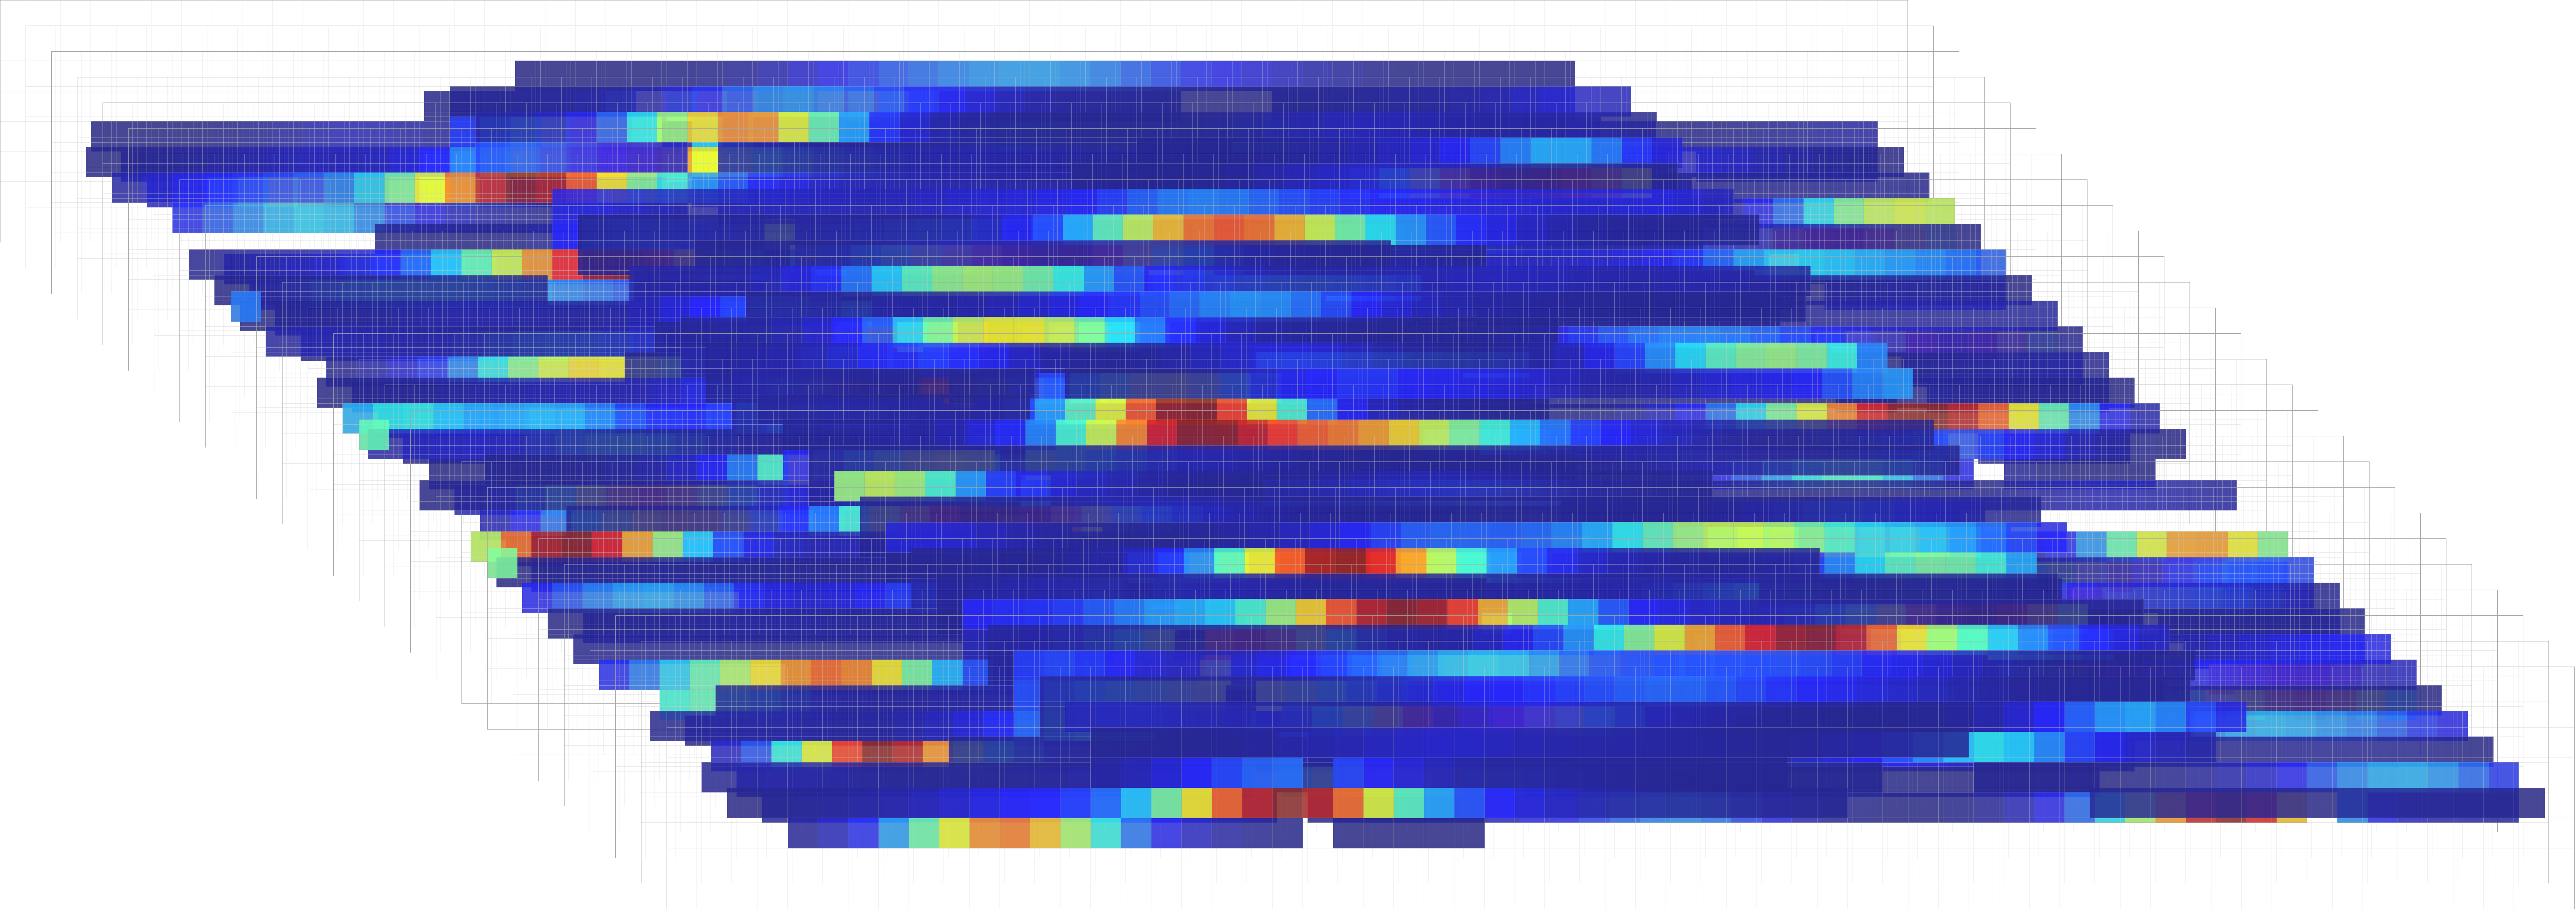

In [35]:
output_img

In [36]:
final_context = curr_active_pipeline.build_display_context_for_session(display_fn_name='directional_merged_pfs', track_config='All-Directions', cell=a_name)
curr_active_pipeline.output_figure(final_context, a_plot.getViewBox(), write_vector_format=True, write_png=True)


exported plot to "C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\Screenshots\ProgrammaticDisplayFunctionTesting\2024-01-12\kdiba\pin01\one\fet11-01_12-58-54\directional_merged_pfs_All-Directions_pf[Cell 32-(shk 4, clu 6) - 22.svg"
	 saved C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\Screenshots\ProgrammaticDisplayFunctionTesting\2024-01-12\kdiba\pin01\one\fet11-01_12-58-54\directional_merged_pfs_All-Directions_pf[Cell 32-(shk 4, clu 6) - 22.svg
exported plot to "C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\Screenshots\ProgrammaticDisplayFunctionTesting\2024-01-12\kdiba\pin01\one\fet11-01_12-58-54\directional_merged_pfs_All-Directions_pf[Cell 32-(shk 4, clu 6) - 22.png"
	 saved C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\Screenshots\ProgrammaticDisplayFunctionTesting\2024-01-12\kdiba\pin01\one\fet11-01_12-58-54\directional_merged_pfs_All-Directions_pf[Cell 32-(shk 4, clu 6) - 22.png


([WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/EXTERNAL/Screenshots/ProgrammaticDisplayFunctionTesting/2024-01-12/kdiba/pin01/one/fet11-01_12-58-54/directional_merged_pfs_All-Directions_pf[Cell 32-(shk 4, clu 6) - 22.svg'),
  WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/EXTERNAL/Screenshots/ProgrammaticDisplayFunctionTesting/2024-01-12/kdiba/pin01/one/fet11-01_12-58-54/directional_merged_pfs_All-Directions_pf[Cell 32-(shk 4, clu 6) - 22.png')],
 Context(format_name: 'kdiba'
         animal: 'pin01'
         exper_name: 'one'
         session_name: 'fet11-01_12-58-54'
         display_fn_name: 'directional_merged_pfs'
         track_config: 'All-Directions'
         cell: 'pf[Cell 32-(shk 4, clu 6) - 22.75 Hz]'))

In [ ]:
# final_context

curr_active_pipeline.get_output_path()

In [16]:
a_name = 'pf[Cell 2-(shk 1, clu 2) - 12.36 Hz]'
a_plot = all_dir_outputs.plots[a_name].mainPlotItem # PlotItem 
# a_plot.setTitle('test')
# type(a_plot.titleLabel) # LabelItem


# adjust margins (left, top, right, bottom)
# a_plot.getViewBox().setContentsMargins(0, 10, 0, 0)

# TypeError: arguments did not match any overloaded call:
#   boundingRect(self, rect: QRectF, flags: int, text: Optional[str]): argument 3 has unexpected type 'numpy.int32'
#   boundingRect(self, rect: QRect, flags: int, text: Optional[str]): argument 1 has unexpected type 'QRectF'
#   boundingRect(self, rectangle: QRectF, text: Optional[str], option: QTextOption = QTextOption()): argument 2 has unexpected type 'AlignmentFlag'
#   boundingRect(self, x: int, y: int, w: int, h: int, flags: int, text: Optional[str]): argument 1 has unexpected type 'QRectF'

# a_plot.setStyle({'showValues': False})


NameError: name 'all_dir_outputs' is not defined

In [ ]:



final_context = curr_active_pipeline.build_display_context_for_session(display_fn_name='directional_merged_pfs', track_config='All-Directions', cell=a_name)
curr_active_pipeline.output_figure(final_context, a_plot.getViewBox())

In [ ]:
a_plot.titleLabel.setContentsMargins(50, 0, 0, 0)
a_plot.titleLabel.

for i in range(4):
	a_plot.layout.setRowPreferredHeight(i, 0)
	a_plot.layout.setRowMinimumHeight(i, 0)
	a_plot.layout.setRowSpacing(i, 0)
	a_plot.layout.setRowStretchFactor(i, 1)


In [ ]:
a_plot.layout.setRowMinimumHeight(0, 500) # idk...
a_plot.layout.setRowPreferredHeight(1, 0) # nothing
a_plot.layout.setRowPreferredHeight(2, 30) # the plot item
a_plot.layout.setRowPreferredHeight(3, 0) 
a_plot.layout.setRowPreferredHeight(4, 0)

In [ ]:
# no clue why 2 is a good value for this...
a_plot.titleLabel.setMaximumHeight(2)
a_plot.layout.setRowFixedHeight(0, 2)

## Could be the plot item size that should be changed?



In [ ]:
# this gets rid of the annoying white bounding box in the ViewBox of the plot
# a_plot.hideAxis('left') # Hide left border
a_plot.hideAxis('right') # Hide right border
# a_plot.hideAxis('top') # Hide top border
a_plot.hideAxis('bottom') # Hide bottom border

a_plot.showAxes('left')
a_plot.showAxes('top')

In [ ]:
vb: pg.ViewBox = a_plot.getViewBox()
# vb.background = pg.mkColor('red')
# vb.border
# vb.setBorder(None)
vb.setBackgroundColor(pg.mkColor('red')) # works
vb.setBackgroundColor(None)
vb.setBorder(pg.mkPen('blue'))
# vb.setXRange(
vb.setYRange(0, 0.2, 0.0, update=True)

In [ ]:
# a_plot.titleLabel.setText(f"<span style = 'font-size : 10px; color : rgb(50, 65, 75);' >{a_name}</span>")
# a_plot.titleLabel.setText(f"<span style = 'font-size : 10px;' >{a_name}</span>")

a_plot.setTitle(f"<span style = 'font-size : 12px;' >{a_name}</span>")

In [ ]:
all_dir_outputs.plots

In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult

directional_merged_decoders_result = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders']

laps_filter_epochs_decoder_result = directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result

laps_filter_epochs_decoder_result.p_x_given_n_list[0].shape # (n_x_bins, 4, n_curr_epoch_time_bins) - (63, 4, 120)

len(laps_filter_epochs_decoder_result.p_x_given_n_list) # n_epochs = 72

laps_filter_epochs_decoder_result.nbins



In [ ]:
print_keys_if_possible('laps_filter_epochs_decoder_result', laps_filter_epochs_decoder_result, depth=2)

In [ ]:

# Valid use of Unicode in a variable name
my_variable_δ = 42
# This is a comment with Unicode characters: 🐍
# Parentheses: ()
# Square brackets: []
# Curly brackets: {}
# Angle brackets: <>
# Double angle brackets: « »
# Double square brackets: ⟦ ⟧
# Mathematical brackets: 〈〉
# Tortoise shell brackets: 〔〕
# White square brackets: ⟦ ⟧
# Brackets with quills: ⸤⸥

@define(slots=True)
class BracketGroup:
	open: str = field()
	close: str = field()
	

native_python_list_brackets = BracketGroup("[", "]")
numpy_array_brackets = BracketGroup("⟦", "⟧")



In [ ]:
# _display_directional_merged_pf_decoded_epochs ______________________________________________________________________ #
try:
	# Interactive-mode parameters:
	_interactive_mode_kwargs = dict(should_use_MatplotlibTimeSynchronizedWidget=True, scrollable_figure=True, defer_render=False)
	_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
	_curr_interaction_mode_kwargs = _interactive_mode_kwargs # interactive mode

	# Non-interactive:
	# _non_interactive_mode_kwargs = dict(should_use_MatplotlibTimeSynchronizedWidget=False, scrollable_figure=False, defer_render=True)
	# _restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=False, backend='AGG')
	# _curr_interaction_mode_kwargs = _non_interactive_mode_kwargs # non-interactive mode

	_out = curr_active_pipeline.display('_display_directional_merged_pf_decoded_epochs', curr_active_pipeline.get_session_context(),
				max_num_lap_epochs = 100, max_num_ripple_epochs = 10,
				render_merged_pseudo2D_decoder_laps=True, 
				render_directional_marginal_laps=False, render_directional_marginal_ripples=False, render_track_identity_marginal_laps=False, render_track_identity_marginal_ripples=False,
				# render_directional_marginal_laps=True, render_directional_marginal_ripples=False, render_track_identity_marginal_laps=False, render_track_identity_marginal_ripples=False,
				# constrained_layout=True, # layout='none',
				build_fn='basic_view', constrained_layout=True, 
				# build_fn='insets_view', constrained_layout=None, layout='none', # , constrained_layout=False constrained_layout=None, layout='none', # , constrained_layout=None, layout='none' extrodinarily fast
				**_curr_interaction_mode_kwargs, # interactive mode
				skip_plotting_measured_positions=True, skip_plotting_most_likely_positions=True, save_figure=save_figure)
	
except Exception as e:
	print(f'batch_extended_programmatic_figures(...): "_display_directional_merged_pf_decoded_epochs" failed with error: {e}\n skipping.')
	raise


### Plot the z-scores differences and their raw-values

In [ ]:
# from PyQt5.QtWidgets import QGraphicsTextItem
from pyphoplacecellanalysis.General.Model.Configs.LongShortDisplayConfig import DisplayColorsEnum, LongShortDisplayConfigManager
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderAnalyses, plot_rank_order_epoch_inst_fr_result_tuples
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import export_pyqtgraph_plot

# histogram_display_context = active_context.adding_context('display_fn', display_fn_name='plot_rank_order_epoch_inst_fr_result_tuples')
ripple_outputs = plot_rank_order_epoch_inst_fr_result_tuples(curr_active_pipeline, ripple_result_tuple, 'Ripple', show=False)
# _out_ripple_result_tuple_histograms.context = histogram_display_context.adding_context('subplot', subplot_name='ripple_result_tuple')
diff_app, diff_win, diff_p1, diff_out_plot_1D, diff_label_tuple, raw_app, raw_win, raw_p1, raw_out_plot_1D, raw_label_tuple = ripple_outputs
diff_header_label, diff_footer_label = diff_label_tuple
raw_header_label, raw_footer_label = raw_label_tuple


## 2024-01-02 - Almost working for building footer/header strings in pyqtgraph plots:

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderGlobalDisplayFunctions

curr_active_pipeline.reload_default_display_functions()
_out = curr_active_pipeline.display('_display_rank_order_z_stats_results', defer_show=False)


In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import plot_rank_order_epoch_inst_fr_result_tuples

ripple_outputs = plot_rank_order_epoch_inst_fr_result_tuples(curr_active_pipeline, ripple_result_tuple, 'Ripple')
ripple_outputs

In [ ]:
# Usage of the function for Lap
lap_outputs = plot_rank_order_epoch_inst_fr_result_tuples(curr_active_pipeline, laps_result_tuple, 'Lap')
lap_outputs

In [ ]:
# result_tuple.plot_histograms()
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import plot_rank_order_histograms

# Plot histograms:
active_context = curr_active_pipeline.sess.get_context()

def _perform_write_to_file_callback(final_context, fig):
	return curr_active_pipeline.output_figure(final_context, fig)

post_title_info: str = f'{minimum_inclusion_fr_Hz} Hz'
collector_histograms = plot_rank_order_histograms(rank_order_results, post_title_info=post_title_info, active_context=active_context, perform_write_to_file_callback=_perform_write_to_file_callback)

## 2023-12-23 - Good for lap direction debugging:


In [ ]:
# rank_order_results.laps_most_likely_result_tuple.directional_likelihoods_df.plot.bar(y=['long_relative_direction_likelihoods', 'short_relative_direction_likelihoods'])

# _temp_dir_like_df = rank_order_results.laps_most_likely_result_tuple.directional_likelihoods_df.copy()
_temp_dir_like_df = rank_order_results.ripple_most_likely_result_tuple.directional_likelihoods_df.copy()
_temp_dir_like_df[['long_relative_direction_likelihoods', 'short_relative_direction_likelihoods']] -= 0.5 # Subtract 0.5 so y is centered on zero, above zero showing LR favor below RL
_temp_dir_like_df.plot.bar(y=['long_relative_direction_likelihoods'])

In [ ]:
import seaborn as sns

# directional_likelihoods_df = pd.DataFrame({
#   "long_relative_direction_likelihoods": [0.41, 0.48, 0.27, 0.33, 0.69, 0.50],
#   "short_relative_direction_likelihoods": [0.58, 0.51, 0.72, 0.66, 0.30, 0.49],
#   "long_best_direction_indices": [0, 1, 1, 1, 0, 0]
# })


fig = plt.figure(num='directional_likelihoods_df figure')
sns.scatterplot(x=directional_likelihoods_df.index, y=directional_likelihoods_df["long_relative_direction_likelihoods"], hue=directional_likelihoods_df["long_best_direction_indices"], palette="hls")
plt.show()

In [ ]:
import seaborn as sns
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import plot_quantile_diffs

_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
global_epoch = curr_active_pipeline.filtered_epochs[global_epoch_name]
short_epoch = curr_active_pipeline.filtered_epochs[short_epoch_name]
split_time_t: float = short_epoch.t_start
active_context = curr_active_pipeline.sess.get_context()

def _perform_write_to_file_callback(final_context, fig):
	return curr_active_pipeline.output_figure(final_context, fig)

collector = plot_quantile_diffs(ripple_merged_complete_epoch_stats_df, t_split=split_time_t, active_context=active_context, perform_write_to_file_callback=_perform_write_to_file_callback)

In [ ]:
#TODO 2023-11-16 22:23: - [ ] The other display functions using matplotlib do things like this:
# final_context = active_context
# graphics_output_dict['context'] = final_context
# graphics_output_dict['plot_data'] |= {'df': neuron_replay_stats_df, 'rdf':rdf, 'aclu_to_idx':aclu_to_idx, 'irdf':irdf, 'time_binned_unit_specific_spike_rate': global_computation_results.computed_data['jonathan_firing_rate_analysis'].time_binned_unit_specific_spike_rate,
#     'time_variable_name':time_variable_name, 'fignum':curr_fig_num}

# def _perform_write_to_file_callback():
#     ## 2023-05-31 - Reference Output of matplotlib figure to file, along with building appropriate context.
#     return owning_pipeline_reference.output_figure(final_context, graphics_output_dict.figures[0])

# if save_figure:
#     active_out_figure_paths = _perform_write_to_file_callback()
# else:
#     active_out_figure_paths = []

# graphics_output_dict['saved_figures'] = active_out_figure_paths

## Weighted Correlation can only be applied to decoded posteriors, not spikes themselves.
### It works by assessing the degree to which a change in position corresponds to a change in time. For a simple diagonally increasing trajectory across the track at early timebins position will start at the bottom of the track, and as time increases the position also increases. The "weighted" part just corresponds to making use of the confidence probabilities of the decoded posterior: instead of relying on only the most-likely position we can include all information returned. Naturally will emphasize sharp decoded positions and de-emphasize diffuse ones.


In [ ]:
from PendingNotebookCode import add_weighted_correlation_result, compute_epoch_weighted_correlation

# add_weighted_correlation_result(xbin_centers, a_long_decoder_result: DecodedFilterEpochsResult, a_short_decoder_result: DecodedFilterEpochsResult, method=('pearson', 'spearman'), debug_print = False)

In [ ]:
## Get decoded posteriors for each replay epoch:
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult
from PendingNotebookCode import add_weighted_correlation_result, _add_maze_id_to_epochs

## 2023-10-19 - Weighted Correlation:
a_long_decoder_result: DecodedFilterEpochsResult = long_results_obj.all_included_filter_epochs_decoder_result
a_short_decoder_result: DecodedFilterEpochsResult = short_results_obj.all_included_filter_epochs_decoder_result
# Get the xbin_centers which are the same for long/short:
xbin_centers = long_results_obj.original_1D_decoder.xbin_centers.copy()
# Compute the weighte correlation:
epoch_long_weighted_corr_results, epoch_short_weighted_corr_results = add_weighted_correlation_result(xbin_centers, a_long_decoder_result, a_short_decoder_result, debug_print=False)
epoch_long_weighted_corr_results

In [ ]:
## 2023-10-19 - Weighted Correlation:

directional_merged_decoders_result: DirectionalMergedDecodersResult  = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders']
laps_filter_epochs_decoder_result = directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result
laps_filter_epochs_decoder_result


In [ ]:


# laps_filter_epochs_decoder_result


## 2023-10-19 - Weighted Correlation:
a_long_decoder_result: DecodedFilterEpochsResult = long_results_obj.all_included_filter_epochs_decoder_result
a_short_decoder_result: DecodedFilterEpochsResult = short_results_obj.all_included_filter_epochs_decoder_result
# Get the xbin_centers which are the same for long/short:
xbin_centers = directional_merged_decoders_result.all_directional_pf1D_Decoder.xbin_centers.copy()
# Compute the weighte correlation:
epoch_long_weighted_corr_results, epoch_short_weighted_corr_results = add_weighted_correlation_result(xbin_centers, a_long_decoder_result, a_short_decoder_result, debug_print=False)
epoch_long_weighted_corr_results


In [ ]:
debug_print = True
method = ('pearson', 'spearman')
epoch_long_weighted_corr_results = []

# Get the xbin_centers which are the same for long/short:
xbin_centers = directional_merged_decoders_result.all_directional_pf1D_Decoder.xbin_centers.copy()
a_long_decoder_result: DecodedFilterEpochsResult = deepcopy(laps_filter_epochs_decoder_result)


for decoded_epoch_idx in np.arange(a_long_decoder_result.num_filter_epochs):
	# decoded_epoch_idx:int = 0
	curr_epoch_time_bin_container = a_long_decoder_result.time_bin_containers[decoded_epoch_idx]
	curr_time_bins = curr_epoch_time_bin_container.centers
	curr_n_time_bins = len(curr_time_bins)
	if debug_print:
		print(f'curr_n_time_bins: {curr_n_time_bins}')

	## Long Decoding:
	curr_long_epoch_p_x_given_n = a_long_decoder_result.p_x_given_n_list[decoded_epoch_idx] # .shape: (239, 5) - (n_x_bins, n_epoch_time_bins)
	weighted_corr_result = compute_epoch_weighted_correlation(xbin_centers, curr_time_bins, curr_long_epoch_p_x_given_n, method=method)
	epoch_long_weighted_corr_results.append(weighted_corr_result)

	# ## Short Decoding:
	# curr_short_epoch_p_x_given_n = a_short_decoder_result.p_x_given_n_list[decoded_epoch_idx] # .shape: (239, 5) - (n_x_bins, n_epoch_time_bins)
	# weighted_corr_result = compute_epoch_weighted_correlation(xbin_centers, curr_time_bins, curr_short_epoch_p_x_given_n, method=method)
	# epoch_short_weighted_corr_results.append(weighted_corr_result)

# ## Build separate result dataframe:
# epoch_weighted_corr_results_df = pd.DataFrame({'weighted_corr_LONG': np.array(epoch_long_weighted_corr_results), 'weighted_corr_SHORT': np.array(epoch_short_weighted_corr_results)})
# epoch_weighted_corr_results_df

epoch_long_weighted_corr_results = np.array(epoch_long_weighted_corr_results)



In [ ]:

a_long_decoder_result: DecodedFilterEpochsResult = long_results_obj.all_included_filter_epochs_decoder_result
a_short_decoder_result: DecodedFilterEpochsResult = short_results_obj.all_included_filter_epochs_decoder_result
# Get the xbin_centers which are the same for long/short:
xbin_centers = long_results_obj.original_1D_decoder.xbin_centers.copy()
# Compute the weighte correlation:
epoch_long_weighted_corr_results, epoch_short_weighted_corr_results = add_weighted_correlation_result(xbin_centers, a_long_decoder_result, a_short_decoder_result, debug_print=False)

In [ ]:
epoch_long_weighted_corr_results.shape # (151, 2)

In [ ]:

## Add new weighted correlation results as new columns in existing filter_epochs df:
active_filter_epochs = long_results_obj.active_filter_epochs
# Add the maze_id to the active_filter_epochs so we can see how properties change as a function of which track the replay event occured on:
active_filter_epochs = _add_maze_id_to_epochs(active_filter_epochs, short_session.t_start)
active_filter_epochs._df['weighted_corr_LONG'] = epoch_long_weighted_corr_results[:,0]
active_filter_epochs._df['weighted_corr_SHORT'] = epoch_short_weighted_corr_results[:,0]
active_filter_epochs._df['weighted_corr_spearman_LONG'] = epoch_long_weighted_corr_results[:,1]
active_filter_epochs._df['weighted_corr_spearman_SHORT'] = epoch_short_weighted_corr_results[:,1]


active_filter_epochs

In [ ]:
active_filter_epochs.to_dataframe()

In [ ]:
## plot the `weighted_corr_LONG` over time

# fig, axes = plt.subplots(ncols=1, nrows=active_num_rows, sharex=True, sharey=sharey, figsize=figsize)

## Weighted Correlation during replay epochs:
_out_ax = active_filter_epochs._df.plot.scatter(x='start', y='weighted_corr_LONG', title='weighted_corr during replay events', marker="s",  s=5, label=f'Long', alpha=0.8)
active_filter_epochs._df.plot.scatter(x='start', y='weighted_corr_SHORT', xlabel='Replay Epoch Time', ylabel='Weighted Correlation', ax=_out_ax, marker="s", c='r', s=5, label=f'Short', alpha=0.8)
_out_ax.axhline(y=0.0, linewidth=1, color='k') # the y=0.0 line

In [ ]:
## Weighted Spearman Correlation during replay epochs:
_out_ax = active_filter_epochs._df.plot.scatter(x='start', y='weighted_corr_spearman_LONG', title='weighted_spearman_corr during replay events', marker="s",  s=5, label=f'Long', alpha=0.8)
active_filter_epochs._df.plot.scatter(x='start', y='weighted_corr_spearman_SHORT', xlabel='Replay Epoch Time', ylabel='Weighted Spearman Correlation', ax=_out_ax, marker="s", c='r', s=5, label=f'Short', alpha=0.8)
_out_ax.axhline(y=0.0, linewidth=1, color='k') # the y=0.0 line

In [ ]:
_out_ax = active_filter_epochs._df.plot.scatter(x='start', y='score_LONG', title='Radon Transform Score during replay events', marker="s",  s=5, label=f'Long', alpha=0.8)
active_filter_epochs._df.plot.scatter(x='start', y='score_SHORT', xlabel='Replay Epoch Time', ylabel='Replay Radon Transform Score', ax=_out_ax, marker="s", c='r', s=5, label=f'Short', alpha=0.8)
_out_ax.axhline(y=0.0, linewidth=1, color='k') # the y=0.0 line